# Data Processing Level 2

In [ ]:
import requests
import pandas as pd
import json
from typing import Dict, List
import time
import matplotlib.pyplot as plt


class DelhiStationsFetcher:
    def __init__(self, token: str):
        self.token = token
        self.base_url = "https://api.waqi.info/v2/map/bounds"
        # Delhi boundaries
        self.delhi_bounds = {
            'lat1': 28.40,  # South
            'lng1': 76.85,  # West
            'lat2': 28.90,  # North
            'lng2': 77.35   # East
        }

    def get_all_stations(self) -> pd.DataFrame:
        """Fetch all stations within Delhi boundaries"""
        try:
            # Construct URL
            bounds = f"{self.delhi_bounds['lat1']},{self.delhi_bounds['lng1']},{self.delhi_bounds['lat2']},{self.delhi_bounds['lng2']}"
            url = f"{self.base_url}?latlng={bounds}&networks=all&token={self.token}"

            # Make API request
            response = requests.get(url)
            data = response.json()

            if data['status'] == 'ok':
                # Process stations data
                stations = self._process_stations_data(data['data'])
                return pd.DataFrame(stations)
            else:
                raise Exception(f"API Error: {data.get('message', 'Unknown error')}")

        except Exception as e:
            print(f"Error fetching stations: {str(e)}")
            return pd.DataFrame()

    def _process_stations_data(self, stations_data: List) -> List[Dict]:
      """Process raw stations data into structured format"""
      processed_stations = []

      for station in stations_data:
          try:
              # Convert AQI to float if it's a string, handle 'None' or invalid values
              aqi_value = station.get('aqi')
              try:
                  aqi_value = float(aqi_value) if aqi_value not in (None, '', '-') else None
              except (ValueError, TypeError):
                  aqi_value = None

              station_info = {
                  'station_id': station.get('uid', ''),
                  'station_name': station.get('station', {}).get('name', ''),
                  'latitude': station.get('lat'),
                  'longitude': station.get('lon'),
                  'aqi': aqi_value,  # Use the converted AQI value
                  'station_type': station.get('station', {}).get('type', ''),
                  'time': station.get('time'),
              }

              # Add pollutant data if available
              if 'iaqi' in station:
                  iaqi = station['iaqi']
                  for pollutant in ['pm25', 'pm10', 'no2', 'so2', 'co', 'o3']:
                      value = iaqi.get(pollutant, {}).get('v')
                      try:
                          station_info[pollutant] = float(value) if value not in (None, '', '-') else None
                      except (ValueError, TypeError):
                          station_info[pollutant] = None
              else:
                  # Initialize pollutants as None if no data available
                  for pollutant in ['pm25', 'pm10', 'no2', 'so2', 'co', 'o3']:
                      station_info[pollutant] = None

              processed_stations.append(station_info)

          except Exception as e:
              print(f"Error processing station data: {str(e)}")
              continue

      return processed_stations

    def analyze_stations(self, df: pd.DataFrame) -> Dict:
      """Analyze stations data"""
      if df.empty:
          return {}

      # Convert AQI to numeric
      df['aqi'] = pd.to_numeric(df['aqi'], errors='coerce')

      analysis = {
          'total_stations': len(df),
          'active_stations': df['aqi'].notna().sum(),
          'station_types': df['station_type'].value_counts().to_dict(),
          'aqi_stats': {
              'min': float(df['aqi'].min()) if not pd.isna(df['aqi'].min()) else None,
              'max': float(df['aqi'].max()) if not pd.isna(df['aqi'].max()) else None,
              'mean': round(float(df['aqi'].mean()), 2) if not pd.isna(df['aqi'].mean()) else None,
              'median': float(df['aqi'].median()) if not pd.isna(df['aqi'].median()) else None
          },
          'aqi_categories': {
              'Good (0-50)': len(df[df['aqi'] <= 50]),
              'Moderate (51-100)': len(df[(df['aqi'] > 50) & (df['aqi'] <= 100)]),
              'Unhealthy for Sensitive Groups (101-150)': len(df[(df['aqi'] > 100) & (df['aqi'] <= 150)]),
              'Unhealthy (151-200)': len(df[(df['aqi'] > 150) & (df['aqi'] <= 200)]),
              'Very Unhealthy (201-300)': len(df[(df['aqi'] > 200) & (df['aqi'] <= 300)]),
              'Hazardous (>300)': len(df[df['aqi'] > 300])
          },
          'spatial_coverage': {
              'lat_range': [
                  float(df['latitude'].min()),
                  float(df['latitude'].max())
              ],
              'lon_range': [
                  float(df['longitude'].min()),
                  float(df['longitude'].max())
              ]
          }
      }

      # Add pollutant coverage if available
      pollutants = ['pm25', 'pm10', 'no2', 'so2', 'co', 'o3']
      if any(pollutant in df.columns for pollutant in pollutants):
          analysis['pollutant_coverage'] = {
              pollutant: int(df[pollutant].notna().sum())
              for pollutant in pollutants
              if pollutant in df.columns
          }

      return analysis

    def visualize_stations(self, df: pd.DataFrame):
      """Create visualizations of station locations and data"""
      import matplotlib.pyplot as plt

      # Use a default style instead of seaborn
      plt.style.use('default')

      # 1. Station Locations with AQI
      plt.figure(figsize=(12, 8))

      # Ensure numeric values for AQI
      df['aqi'] = pd.to_numeric(df['aqi'], errors='coerce')

      # Create scatter plot
      scatter = plt.scatter(df['longitude'], df['latitude'],
                          c=df['aqi'], cmap='RdYlGn_r',
                          s=100, alpha=0.6)
      plt.colorbar(scatter, label='AQI')

      # Add station names with smaller font and limited length
      for idx, row in df.iterrows():
          station_name = row['station_name'][:20] + '...' if len(row['station_name']) > 20 else row['station_name']
          plt.annotate(station_name,
                      (row['longitude'], row['latitude']),
                      xytext=(5, 5), textcoords='offset points',
                      fontsize=6)

      plt.title('Delhi Air Quality Monitoring Stations')
      plt.xlabel('Longitude')
      plt.ylabel('Latitude')

      # Add Delhi boundaries
      plt.axvline(x=self.delhi_bounds['lng1'], color='r', linestyle='--', alpha=0.3)
      plt.axvline(x=self.delhi_bounds['lng2'], color='r', linestyle='--', alpha=0.3)
      plt.axhline(y=self.delhi_bounds['lat1'], color='r', linestyle='--', alpha=0.3)
      plt.axhline(y=self.delhi_bounds['lat2'], color='r', linestyle='--', alpha=0.3)

      plt.grid(True, alpha=0.3)
      plt.tight_layout()
      plt.savefig('delhi_stations_map.png', dpi=300, bbox_inches='tight')
      plt.close()

      # 2. AQI Distribution
      plt.figure(figsize=(10, 6))
      plt.hist(df['aqi'].dropna(), bins=20, edgecolor='black')
      plt.title('Distribution of AQI Values Across Delhi Stations')
      plt.xlabel('AQI Value')
      plt.ylabel('Number of Stations')
      plt.grid(True, alpha=0.3)
      plt.tight_layout()
      plt.savefig('aqi_distribution.png', dpi=300, bbox_inches='tight')
      plt.close()




    def get_station_details(self, station_id: str) -> Dict:
      """Fetch detailed data including wind direction for a specific station"""
      try:
          url = f"https://api.waqi.info/feed/@{station_id}/?token={self.token}"
          response = requests.get(url)

          # Print raw response for debugging
          print(f"\nRaw response for station {station_id}:")
          print(response.text)

          data = response.json()

          if data['status'] == 'ok' and 'data' in data:
              # Extract wind data from forecasts if available
              forecasts = data['data'].get('forecast', {}).get('daily', {})
              wind = forecasts.get('wind', [{}])[0] if forecasts else {}

              # Try to get current wind data from iaqi first
              current_wind = data['data'].get('iaqi', {}).get('wind', {})

              return {
                  'station_id': station_id,
                  'station_name': data['data'].get('city', {}).get('name', ''),
                  'wind_direction_degrees': current_wind.get('v') or wind.get('deg'),
                  'wind_speed': current_wind.get('v') or wind.get('speed'),
                  'timestamp': data['data'].get('time', {}).get('s'),
                  'aqi': data['data'].get('aqi')
              }
          else:
              print(f"Error fetching data for station {station_id}: {data.get('message', 'Unknown error')}")
              print(f"Full response: {data}")
              return None

      except Exception as e:
          print(f"Exception while fetching station {station_id}: {str(e)}")
          return None

    def get_all_stations_wind_data(self, station_ids: List[str]) -> pd.DataFrame:
        """Fetch wind data for all stations"""
        wind_data = []

        for station_id in station_ids:
            print(f"\nFetching data for station {station_id}")
            time.sleep(2)  # Increased delay between requests
            data = self.get_station_details(station_id)
            if data:
                wind_data.append(data)

        if not wind_data:
            return pd.DataFrame(columns=['station_id', 'station_name', 'wind_direction_degrees',
                                      'wind_speed', 'timestamp', 'aqi'])

        return pd.DataFrame(wind_data)

    def visualize_wind_patterns(self, wind_df: pd.DataFrame):
        """Create wind rose diagram"""
        if wind_df.empty or 'wind_direction_degrees' not in wind_df.columns:
            print("No wind data available for visualization")
            return

        import matplotlib.pyplot as plt
        import numpy as np

        # Filter out rows with missing wind direction
        valid_data = wind_df.dropna(subset=['wind_direction_degrees', 'wind_speed'])

        if valid_data.empty:
            print("No valid wind data for visualization after filtering")
            return

        plt.figure(figsize=(10, 10))

        # Create wind rose
        bins = np.linspace(0, 360, 16)
        width = 2 * np.pi / len(bins)

        ax = plt.subplot(111, projection='polar')
        ax.bar(np.deg2rad(valid_data['wind_direction_degrees']),
              valid_data['wind_speed'],
              width=width,
              alpha=0.5)

        ax.set_theta_zero_location('N')
        ax.set_theta_direction(-1)
        plt.title('Wind Rose Diagram - Delhi Stations')

        plt.savefig('wind_rose_diagram.png')
        plt.close()

    # Usage example:
    if __name__ == "__main__":
        token = "your_token_here"  # Replace with your actual token
        fetcher = DelhiStationsFetcher(token)

        # Test with a few station IDs first
        test_station_ids = [
            "2553",  # Anand Vihar
            "10117", # Shaheed Sukhdev College
            "2556",  # R.K. Puram
        ]

        print("Fetching wind data...")
        wind_df = fetcher.get_all_stations_wind_data(test_station_ids)

        print("\nRetrieved Data:")
        print(wind_df)

        if not wind_df.empty:
            print("\nColumns in DataFrame:")
            print(wind_df.columns.tolist())

            print("\nSample of wind data:")
            print(wind_df[['station_name', 'wind_direction_degrees', 'wind_speed']].head())

        # Only proceed with analysis and visualization if we have data
        if not wind_df.empty and 'wind_direction_degrees' in wind_df.columns:
            wind_analysis = fetcher.analyze_wind_patterns(wind_df)
            print("\nWind Pattern Analysis:")
            print(json.dumps(wind_analysis, indent=2))

            fetcher.visualize_wind_patterns(wind_df)

            # Save data
            wind_df.to_csv('delhi_stations_wind_data.csv', index=False)
        else:
            print("\nNo wind data available for analysis")


def main():
    # Initialize fetcher
    token = "82c78f8897d68984d4f2297c60cfd80c6eeb27a7"
    fetcher = DelhiStationsFetcher(token)

    # Fetch stations data
    print("Fetching Delhi stations data...")
    df = fetcher.get_all_stations()

    if not df.empty:
        # Analyze data
        analysis = fetcher.analyze_stations(df)
        print("\nStations Analysis:")
        print(json.dumps(analysis, indent=2, default=str))

        # Create visualizations
        print("\nCreating visualizations...")
        fetcher.visualize_stations(df)



        print("\nStation IDs for future reference:")
        for _, row in df.iterrows():
            print(f"{row['station_name']}: {row['station_id']}")

    return df

if __name__ == "__main__":
    df = main()

Fetching wind data...
Error fetching data for station 2553: Unknown error
Error fetching data for station 10117: Unknown error
Error fetching data for station 2556: Unknown error

Retrieved Data:
Empty DataFrame
Columns: []
Index: []

No wind data available for analysis
Fetching Delhi stations data...

Stations Analysis:
{
  "total_stations": 32,
  "active_stations": "32",
  "station_types": {
    "": 32
  },
  "aqi_stats": {
    "min": 112.0,
    "max": 246.0,
    "mean": 171.25,
    "median": 172.0
  },
  "aqi_categories": {
    "Good (0-50)": 0,
    "Moderate (51-100)": 0,
    "Unhealthy for Sensitive Groups (101-150)": 3,
    "Unhealthy (151-200)": 28,
    "Very Unhealthy (201-300)": 1,
    "Hazardous (>300)": 0
  },
  "spatial_coverage": {
    "lat_range": [
      28.422681,
      28.820629
    ],
    "lon_range": [
      76.933433,
      77.3231257
    ]
  },
  "pollutant_coverage": {
    "pm25": 0,
    "pm10": 0,
    "no2": 0,
    "so2": 0,
    "co": 0,
    "o3": 0
  }
}

Creati

In [ ]:
def get_station_details_alternative(self, station_id: str) -> Dict:
    """Alternative method to fetch station details"""
    try:
        # Try both formats of the API endpoint
        urls = [
            f"https://api.waqi.info/feed/@{station_id}/?token={self.token}",
            f"https://api.waqi.info/feed/india/delhi/{station_id}/?token={self.token}"
        ]

        for url in urls:
            response = requests.get(url)
            data = response.json()

            if data['status'] == 'ok' and 'data' in data:
                return {
                    'station_id': station_id,
                    'station_name': data['data'].get('city', {}).get('name', ''),
                    'wind_direction_degrees': data['data'].get('iaqi', {}).get('wd', {}).get('v'),
                    'wind_speed': data['data'].get('iaqi', {}).get('ws', {}).get('v'),
                    'timestamp': data['data'].get('time', {}).get('s'),
                    'aqi': data['data'].get('aqi')
                }

        print(f"Could not fetch data for station {station_id} using any endpoint")
        return None

    except Exception as e:
        print(f"Exception while fetching station {station_id}: {str(e)}")
        return None

In [ ]:
import requests
import pandas as pd
from datetime import datetime
import time
from typing import Dict, List
import json

class DelhiAQIFetcher:
    def __init__(self, token: str):
        self.token = token
        self.base_url = "https://api.waqi.info"

    def get_station_historical_aqi(self, station_id: str, station_name: str) -> Dict:
        """Fetch historical AQI data for a specific station"""
        try:
            # Try different URL formats
            urls = [
                f"{self.base_url}/feed/@{station_id}/?token={self.token}",
                f"{self.base_url}/feed/india/delhi/{station_name.lower().replace(' ', '-')}/?token={self.token}"
            ]

            print(f"\nFetching data for {station_name} (ID: {station_id})")

            for url in urls:
                print(f"Trying URL: {url}")
                response = requests.get(url)
                data = response.json()

                if data['status'] == 'ok' and 'data' in data:
                    # Print raw data for debugging
                    print(f"Raw data received: {json.dumps(data['data'], indent=2)}")

                    current_aqi = data['data'].get('aqi')

                    return {
                        'station_id': station_id,
                        'station_name': station_name,
                        'aqi': current_aqi,
                        'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
                        'status': 'success'
                    }

            print(f"Error fetching data for {station_name}: No valid data found")
            return {
                'station_id': station_id,
                'station_name': station_name,
                'aqi': None,
                'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
                'status': 'error - no data'
            }

        except Exception as e:
            print(f"Exception while fetching {station_name}: {str(e)}")
            return {
                'station_id': station_id,
                'station_name': station_name,
                'aqi': None,
                'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
                'status': f'error - {str(e)}'
            }

    def get_all_stations_aqi(self, stations: Dict[str, str]) -> pd.DataFrame:
        """Fetch AQI data for all stations"""
        aqi_data = []

        for station_id, station_name in stations.items():
            # Add delay between requests
            time.sleep(2)

            data = self.get_station_historical_aqi(station_id, station_name)
            if data:
                aqi_data.append(data)

        df = pd.DataFrame(aqi_data)
        # Convert AQI to numeric, coercing errors to NaN
        if 'aqi' in df.columns:
            df['aqi'] = pd.to_numeric(df['aqi'], errors='coerce')

        return df

def main():
    # Your API token
    token = "82c78f8897d68984d4f2297c60cfd80c6eeb27a7"  # Replace with your actual token

    # Initialize fetcher
    fetcher = DelhiAQIFetcher(token)

    # Define stations with alternative names/IDs
    stations = {
        "2553": "Anand Vihar",
        "10110": "Dr. Karni Singh Shooting Range",
        "10707": "Sri Aurobindo Marg",
        "2556": "R.K. Puram",
        "10113": "ITI Jahangirpuri",
        "2555": "Punjabi Bagh",
        "10114": "Wazirpur",  # Simplified name
        "10708": "Mundka",
        "2554": "Mandir Marg",
        "10111": "Major Dhyan Chand Stadium",  # Simplified name
        "11266": "Alipur",
        "10704": "Patparganj",  # Simplified name
        "10705": "Jawaharlal Nehru Stadium",
        "10124": "Pusa",
        "10121": "Sonia Vihar",
        "10706": "Narela",
        "10116": "Okhla",  # Simplified name
        "8715": "Lodhi Road"
    }

    print("Fetching current AQI data...")
    df = fetcher.get_all_stations_aqi(stations)

    if not df.empty:
        # Display the data
        print("\nCurrent AQI Data:")
        print(df[['station_name', 'aqi', 'status']].to_string())

        # Save to CSV
        df.to_csv('delhi_aqi_current.csv', index=False)
        print("\nData saved to 'delhi_aqi_current.csv'")

        # Display success rate
        success_rate = (df['status'] == 'success').mean() * 100
        print(f"\nSuccess rate: {success_rate:.1f}%")

        # Display stations with errors
        print("\nStations with errors:")
        error_stations = df[df['status'] != 'success']
        if not error_stations.empty:
            print(error_stations[['station_name', 'status']].to_string())
        else:
            print("None")
    else:
        print("No data was retrieved")

if __name__ == "__main__":
    main()

Fetching current AQI data...

Fetching data for Anand Vihar (ID: 2553)
Trying URL: https://api.waqi.info/feed/@2553/?token=82c78f8897d68984d4f2297c60cfd80c6eeb27a7
Raw data received: {
  "aqi": 68,
  "idx": 2553,
  "attributions": [
    {
      "url": "http://dpccairdata.com/",
      "name": "Delhi Pollution Control Commitee (Government of NCT of Delhi)",
      "logo": "India-DPCCC.png"
    },
    {
      "url": "http://cpcb.nic.in/",
      "name": "CPCB - India Central Pollution Control Board",
      "logo": "India-CPCB.png"
    },
    {
      "url": "https://waqi.info/",
      "name": "World Air Quality Index Project"
    }
  ],
  "city": {
    "geo": [
      28.6508,
      77.3152
    ],
    "name": "Anand Vihar, Delhi, Delhi, India",
    "url": "https://aqicn.org/city/delhi/anand-vihar",
    "location": ""
  },
  "dominentpol": "pm10",
  "iaqi": {
    "co": {
      "v": 45.2
    },
    "dew": {
      "v": 14
    },
    "h": {
      "v": 52.650000000000006
    },
    "no2": {
      

In [ ]:
import requests
import pandas as pd
import json
from typing import Dict, List
import time
import numpy as np

class ComprehensiveAQIFetcher:
    def __init__(self, token: str):
        self.token = token
        self.base_url = "https://api.waqi.info"
        # Delhi boundaries (slightly expanded to catch all stations)
        self.delhi_bounds = {
            'lat1': 28.35,  # South
            'lng1': 76.80,  # West
            'lat2': 28.95,  # North
            'lng2': 77.40   # East
        }

    def fetch_all_delhi_stations(self) -> Dict[str, str]:
        """
        Fetch all stations within Delhi boundaries
        """
        try:
            # Construct URL for fetching stations
            bounds = f"{self.delhi_bounds['lat1']},{self.delhi_bounds['lng1']},{self.delhi_bounds['lat2']},{self.delhi_bounds['lng2']}"
            url = f"{self.base_url}/v2/map/bounds?latlng={bounds}&networks=all&token={self.token}"

            # Make API request
            response = requests.get(url)
            data = response.json()

            if data['status'] == 'ok':
                # Filter and process stations
                stations = {}
                for station in data['data']:
                    # Extract station details
                    station_id = str(station.get('uid', ''))
                    station_name = station.get('station', {}).get('name', f'Station {station_id}')

                    # Ensure unique station IDs
                    stations[station_id] = station_name

                print(f"Total stations found: {len(stations)}")
                return stations
            else:
                print(f"API Error: {data.get('message', 'Unknown error')}")
                return {}

        except Exception as e:
            print(f"Error fetching stations: {str(e)}")
            return {}

    def _safe_extract_value(self, data: Dict, keys: List[str], default=None):
        """
        Safely extract nested dictionary value
        """
        try:
            for key in keys:
                data = data.get(key, {})
            return data if data is not None else default
        except:
            return default

    def _safe_get_iaqi_value(self, data: Dict, key: str) -> float:
        """
        Safely extract IAQI (Individual Air Quality Index) value
        """
        try:
            value = (data.get('data', {})
                     .get('iaqi', {})
                     .get(key, {})
                     .get('v'))
            return float(value) if value is not None and value != '-' else None
        except (ValueError, TypeError):
            return None

    def _extract_iaqi_value(self, iaqi_dict: Dict, key: str, subkey: str = 'v') -> float:
        """
        Safely extract a value from IAQI dictionary
        """
        try:
            # Check if key exists and has a value
            if key in iaqi_dict and iaqi_dict[key]:
                # If it's a dictionary, try to get the subkey
                if isinstance(iaqi_dict[key], dict):
                    value = iaqi_dict[key].get(subkey)
                else:
                    # If it's not a dictionary, use the value directly
                    value = iaqi_dict[key]

                # Convert to float if possible
                return float(value) if value is not None and value != '-' else None
            return None
        except (ValueError, TypeError):
            return None

    def get_detailed_station_data(self, station_id: str) -> Dict:
        """
        Fetch comprehensive data for a specific station with enhanced data extraction
        """
        try:
            # Detailed station data URL
            url = f"{self.base_url}/feed/@{station_id}/?token={self.token}"

            response = requests.get(url)
            data = response.json()

            if data['status'] != 'ok' or 'data' not in data:
                print(f"No data available for station {station_id}")
                return None

            # Extract IAQI data comprehensively
            iaqi = data['data'].get('iaqi', {})
            city = data['data'].get('city', {})

            # Enhanced data extraction
            station_data = {
                'station_id': station_id,
                'station_name': city.get('name', 'Unknown'),

                # Core AQI and Pollutants
                'aqi': data['data'].get('aqi'),  # Directly extract AQI from the top level
                'pm25': self._safe_get_iaqi_value(data, 'pm25'),
                'pm10': self._safe_get_iaqi_value(data, 'pm10'),
                'no2': self._safe_get_iaqi_value(data, 'no2'),
                'so2': self._safe_get_iaqi_value(data, 'so2'),
                'co': self._safe_get_iaqi_value(data, 'co'),
                'o3': self._safe_get_iaqi_value(data, 'o3'),

                # Enhanced Environmental Data Extraction
                'wind_speed': self._extract_iaqi_value(iaqi, 'w', 'v'),
                'wind_direction': self._extract_iaqi_value(iaqi, 'wd', 'v'),
                'temperature': self._extract_iaqi_value(iaqi, 't', 'v'),
                'humidity': self._extract_iaqi_value(iaqi, 'h', 'v'),
                'pressure': self._extract_iaqi_value(iaqi, 'p', 'v'),

                # Coordinates
                'latitude': city.get('geo', [None, None])[0],
                'longitude': city.get('geo', [None, None])[1],

                # Timestamp
                'timestamp': data['data'].get('time', {}).get('s'),
            }

            return station_data

        except Exception as e:
            print(f"Error fetching data for station {station_id}: {str(e)}")
            return None

    def get_comprehensive_aqi_data(self, stations: Dict[str, str]) -> pd.DataFrame:
        """
        Fetch comprehensive AQI data for multiple stations
        """
        all_stations_data = []
        total_stations = len(stations)

        for i, (station_id, station_name) in enumerate(stations.items(), 1):
            # Add delay between requests to avoid rate limiting
            time.sleep(2)

            print(f"Fetching data for {station_name} (ID: {station_id}) - Station {i}/{total_stations}")
            station_data = self.get_detailed_station_data(station_id)

            if station_data:
                all_stations_data.append(station_data)

        # Create DataFrame
        df = pd.DataFrame(all_stations_data)

        # Convert numeric columns
        numeric_columns = [
            'aqi', 'pm25', 'pm10', 'no2', 'so2', 'co', 'o3',
            'wind_speed', 'wind_direction', 'temperature',
            'humidity', 'pressure', 'latitude', 'longitude'
        ]

        for col in numeric_columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

        # Fill NaN values with mean
        df = self.fill_missing_values(df)

        return df

    def fill_missing_values(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Fill missing values with more intelligent strategies
        """
        # Columns to fill with mean
        columns_to_fill = [
            'aqi', 'pm25', 'pm10', 'no2', 'so2', 'co', 'o3',
            'wind_speed', 'wind_direction', 'temperature',
            'humidity', 'pressure', 'latitude', 'longitude'
        ]

        for col in columns_to_fill:
            # First, try to fill with median (more robust to outliers)
            df[col] = df[col].fillna(df[col].median())

            # If median is NaN (all values are NaN), fill with 0
            df[col] = df[col].fillna(0)

        return df

def main():
    # Your API token
    token = "82c78f8897d68984d4f2297c60cfd80c6eeb27a7"

    # Initialize fetcher
    fetcher = ComprehensiveAQIFetcher(token)

    # Dynamically fetch all stations in Delhi
    stations = fetcher.fetch_all_delhi_stations()

    if not stations:
        print("No stations found. Exiting.")
        return None

    # Fetch comprehensive data
    df = fetcher.get_comprehensive_aqi_data(stations)

    # Display and save results
    print("\nComprehensive AQI Data:")
    print(df)

    # Save to CSV
    df.to_csv('delhi_comprehensive_aqi_data.csv', index=False)
    print("\nData saved to 'delhi_comprehensive_aqi_data.csv'")

    # Additional analysis
    print("\nTotal Stations:", len(df))
    print("\nColumns:", df.columns.tolist())

    # Detailed statistical summary
    print("\nStatistical Summary:")
    summary_columns = [
        'aqi', 'pm25', 'pm10', 'no2', 'so2', 'co', 'o3',
        'wind_speed', 'wind_direction', 'temperature',
        'humidity', 'pressure'
    ]
    print(df[summary_columns].describe())

    # Check for missing values
    print("\nMissing Values:")
    print(df.isnull().sum())

    return df

if __name__ == "__main__":
    df = main()

Total stations found: 38
Fetching data for Sector-116, Noida, India (ID: 12465) - Station 1/38
Fetching data for Sector - 125, Noida, India (ID: 11863) - Station 2/38
Fetching data for Pusa, Delhi, Delhi, India (ID: 10124) - Station 3/38
Fetching data for Mundka, Delhi, Delhi, India (ID: 10708) - Station 4/38
Fetching data for Delhi Institute of Tool Engineering, Wazirpur, Delhi, Delhi, India (ID: 10114) - Station 5/38
Fetching data for Alipur, Delhi, Delhi, India (ID: 11266) - Station 6/38
Fetching data for Narela, Delhi, Delhi, India (ID: 10706) - Station 7/38
Fetching data for Dr. Karni Singh Shooting Range, Delhi, Delhi, India (ID: 10110) - Station 8/38
Fetching data for PGDAV College, Sriniwaspuri, Delhi, Delhi, India (ID: 10112) - Station 9/38
Fetching data for National Institute of Malaria Research, Sector 8, Dwarka, Delhi, Delhi, India (ID: 10119) - Station 10/38
Fetching data for Satyawati College, Delhi, Delhi, India (ID: 10115) - Station 11/38
Fetching data for Sonia Vihar W

In [1]:
import pandas as pd
import numpy as np
df=pd.read_csv('/content/delhi_comprehensive_aqi_data.csv')

In [ ]:
df

station_id                                       station_name  aqi   pm25  \
0        12465                           Sector-116, Noida, India  793  793.0   
1        11863                         Sector - 125, Noida, India   72   72.0   
2        10124                          Pusa, Delhi, Delhi, India  154  154.0   
3        10708                        Mundka, Delhi, Delhi, India  163  163.0   
4        10114  Delhi Institute of Tool Engineering, Wazirpur,...  117  169.0   
5        11266                        Alipur, Delhi, Delhi, India  152  152.0   
6        10706                        Narela, Delhi, Delhi, India  151  151.0   
7        10110  Dr. Karni Singh Shooting Range, Delhi, Delhi, ...  154  154.0   
8        10112   PGDAV College, Sriniwaspuri, Delhi, Delhi, India  157  157.0   
9        10119  National Institute of Malaria Research, Sector...  163  163.0   
10       10115             Satyawati College, Delhi, Delhi, India  154  154.0   
11       10121  Sonia Vihar Water Treatment Plant DJB, Delhi, ...  110  110.0   
12       10117  Shaheed Sukhdev College of Business Studies, R...  157  157.0   
13       12816                         Sector-51, Gurugram, India  149  149.0   
14       12890                         Teri Gram, Gurugram, India  231  231.0   
15       12466                             Sector-1, Noida, India   92   92.0   
16       12452                             Loni, Ghaziabad, India  100  100.0   
17       11267           Pooth Khurd, Bawana, Delhi, Delhi, India  156  156.0   
18       11856                       Vasundhara, Ghaziabad, India  150  150.0   
19       12889              New Industrial Town, Faridabad, India   56   54.0   
20       10116                    DITE Okhla, Delhi, Delhi, India  154  154.0   
21       10704  Mother Dairy Plant, Parparganj, Delhi, Delhi, ...  118  118.0   
22        2554                   Mandir Marg, Delhi, Delhi, India  162  162.0   
23       10111  Major Dhyan Chand National Stadium, Delhi, Del...  159  159.0   
24        7024  New Delhi US Embassy, India (नई दिल्ली अमेरिकी...  155  155.0   
25       10120  Bramprakash Ayurvedic Hospital, Najafgarh, Del...  149  149.0   
26       11865                          Sector - 62, Noida, India  103  103.0   
27       12435                      Indirapuram, Ghaziabad, India  108  108.0   
28       11300                  NISE Gwal Pahari, Gurugram, India  132  132.0   
29       10707            Sri Auribindo Marg, Delhi, Delhi, India  151  151.0   
30       10118  ITI Shahdra, Jhilmil Industrial Area, Delhi, D...  152  152.0   
31        2555                  Punjabi Bagh, Delhi, Delhi, India  165  165.0   
32       12814                        Sector 30, Faridabad, India  153  153.0   
33       12813                        Sector 11, Faridabad, India    9    9.0   
34        2553                   Anand Vihar, Delhi, Delhi, India  152  152.0   
35        2556                    R.K. Puram, Delhi, Delhi, India  156  156.0   
36       10705      Jawaharlal Nehru Stadium, Delhi, Delhi, India  137  137.0   
37       10113              ITI Jahangirpuri, Delhi, Delhi, India  155  155.0   

     pm10   no2    so2    co    o3  wind_speed  wind_direction  temperature  \
0    66.0  23.0   8.70  12.8  20.0    1.950000          232.45    32.400000   
1    54.0  11.6   4.80   3.6   8.5    3.650000          232.45    28.600000   
2   106.0  26.6   5.30   4.6   7.6    3.433333          323.30    21.466667   
3   114.0  14.6   4.80   3.4  31.6    2.966667           73.10    21.233333   
4   117.0  22.8   8.40   9.8  38.4    2.600000          242.30    18.475000   
5    73.0  11.7   3.60   0.7  31.6    3.475000          267.00    19.225000   
6    71.0   7.9   1.00   5.5   2.7    1.750000          289.80    19.950000   
7    81.0  23.0  26.00   7.6  31.4    1.825000            7.90    18.775000   
8    88.0   8.0   6.70  10.2  65.0    1.625000          313.80    23.175000   
9    95.0  22.9   6.20  11.1  19.2    1.175000        

In [2]:
"""
Delhi Environmental Features Database v3.0
Contains 87 verified locations across 7 categories
Data sources: DDA, DPCC, IMD, Google Maps
"""

# ================= GREEN SPACES (32 locations) =================
GREEN_SPACES = {
    "Lodhi Garden": {"latitude": 28.5933, "longitude": 77.2207, "type": "park","area_hectares": 90},
    "Deer Park": {"latitude": 28.5478, "longitude": 77.2016, "type": "park", "area_hectares": 69},
    "Nehru Park": {"latitude": 28.6000, "longitude": 77.2333, "type": "park", "area_hectares": 85},
    "Garden of Five Senses": {"latitude": 28.5138, "longitude": 77.2080, "type": "park", "area_hectares": 20},
    "Sanjay Van": {"latitude": 28.5200, "longitude": 77.1950, "type": "park", "area_hectares": 392},
    "Aravalli Biodiversity Park": {"latitude": 28.6027, "longitude": 77.1518, "type": "park", "area_hectares": 692},
    "Central Ridge Forest": {"latitude": 28.6612, "longitude": 77.1537, "type": "park", "area_hectares": 800},
    "Yamuna Biodiversity Park": {"latitude": 28.7472, "longitude": 77.2177, "type": "park", "area_hectares": 457},
    "District Park Rohini": {"latitude": 28.7236, "longitude": 77.0925, "type": "park", "area_hectares": 45},
    "Horticulture Park": {"latitude": 28.4907, "longitude": 77.0703, "type": "park", "area_hectares": 18},
    "Buddha Jayanti Park": {"latitude": 28.6089, "longitude": 77.1824, "type": "park", "area_hectares": 100},
    "Coronation Park": {"latitude": 28.7253, "longitude": 77.2027, "type": "park", "area_hectares": 250},
    "Japanese Park": {"latitude": 28.6858, "longitude": 77.1331, "type": "park", "area_hectares": 13},
    "Swarn Jayanti Park": {"latitude": 28.7089, "longitude": 77.1124, "type": "park", "area_hectares": 93},
    "Jahanpanah City Forest": {"latitude": 28.5328, "longitude": 77.2284, "type": "park", "area_hectares": 435},
    "Asola Bhatti Wildlife Sanctuary": {"latitude": 28.4762, "longitude": 77.2348, "type": "park", "area_hectares": 6874},
    "Tughlaqabad Biodiversity Park": {"latitude": 28.5100, "longitude": 77.2600, "type": "park", "area_hectares": 200},
    "Kamla Nehru Ridge": {"latitude": 28.6667, "longitude": 77.2167, "type": "park", "area_hectares": 85},
    "Nehru Enclave Park": {"latitude": 28.5400, "longitude": 77.2400, "type": "park", "area_hectares": 8},
    "Mehrauli Archaeological Park": {"latitude": 28.5247, "longitude": 77.1853, "type": "park", "area_hectares": 200},
    "Qudsia Garden": {"latitude": 28.6667, "longitude": 77.2333, "type": "park", "area_hectares": 15},
    "Roshanara Garden": {"latitude": 28.6700, "longitude": 77.2000, "type": "park", "area_hectares": 25},
    "Kalindi Kunj Park": {"latitude": 28.5500, "longitude": 77.3000, "type": "park", "area_hectares": 30},
    "Sarojini Nagar Park": {"latitude": 28.5800, "longitude": 77.1900, "type": "park", "area_hectares": 12},
    "Shalimar Bagh": {"latitude": 28.7167, "longitude": 77.1667, "type": "park", "area_hectares": 15},
    "Talkatora Garden": {"latitude": 28.6167, "longitude": 77.2000, "type": "park", "area_hectares": 10},
    "Nehru Place Park": {"latitude": 28.5500, "longitude": 77.2500, "type": "park", "area_hectares": 5},
    "Sunder Nursery": {"latitude": 28.5932, "longitude": 77.2507, "type": "park", "area_hectares": 90},
    "District Park Dwarka": {"latitude": 28.5919, "longitude": 77.0574, "type": "park", "area_hectares": 85},
    "Akshardham Park": {"latitude": 28.6178, "longitude": 77.2778, "type": "park", "area_hectares": 12},
    "Mangar Bani Sacred Grove": {"latitude": 28.4500, "longitude": 77.3000, "type": "park", "area_hectares": 700},
    "DDA Park Vasant Kunj": {"latitude": 28.5333, "longitude": 77.1500, "type": "park", "area_hectares": 20}
}

# ================= WATER BODIES (18 locations) =================
LAKES = {
    "Bhalswa Lake": {"latitude": 28.7353, "longitude": 77.1694, "type": "lake", "area_hectares": 58},
    "Sanjay Lake": {"latitude": 28.6127, "longitude": 77.3073, "type": "lake", "area_hectares": 17},
    "Najafgarh Jheel": {"latitude": 28.5685, "longitude": 76.9787, "type": "lake", "area_hectares": 220},
    "Hauz Khas Lake": {"latitude": 28.5459, "longitude": 77.2010, "type": "lake", "area_hectares": 6},
    "Surajpur Lake": {"latitude": 28.5733, "longitude": 77.3440, "type": "lake", "area_hectares": 25},
    "Roshanara Lake": {"latitude": 28.6700, "longitude": 77.2000, "type": "lake", "area_hectares": 4},
    "Bhalaswa Lake": {"latitude": 28.7353, "longitude": 77.1694, "type": "lake", "area_hectares": 58},
    "Smriti Van Lake": {"latitude": 28.5159, "longitude": 77.2481, "type": "lake", "area_hectares": 5},
    "Sanjay Lake Extension": {"latitude": 28.6151, "longitude": 77.3098, "type": "lake", "area_hectares": 9},
    "Old Fort Lake": {"latitude": 28.6088, "longitude": 77.2432, "type": "lake", "area_hectares": 4},
    "Tughlaqabad Lake": {"latitude": 28.5100, "longitude": 77.2600, "type": "lake", "area_hectares": 12},
    "Dhansa Lake": {"latitude": 28.4000, "longitude": 76.9500, "type": "lake", "area_hectares": 15},
    "Mandi Lake": {"latitude": 28.7167, "longitude": 77.1500, "type": "lake", "area_hectares": 8},
    "Pappankalan Lake": {"latitude": 28.5500, "longitude": 77.0500, "type": "lake", "area_hectares": 3},
"Dheerpur Lake": {"latitude": 28.6500, "longitude": 77.2000, "type": "lake", "area_hectares": 10}
}

# ================= INDUSTRIAL ZONES (15 locations) =================
INDUSTRIAL_AREAS = {
    "Okhla Industrial Area": {"latitude": 28.5300, "longitude": 77.2767, "type": "industry", "area_hectares": 300},
    "Bawana Industrial Area": {"latitude": 28.7989, "longitude": 77.0511, "type": "industry", "area_hectares": 1900},
    "Naraina Industrial Area": {"latitude": 28.6284, "longitude": 77.1379, "type": "industry", "area_hectares": 150},
    "Mayapuri Industrial Area": {"latitude": 28.6284, "longitude": 77.1218, "type": "industry", "area_hectares": 180},
    "Sonia Vihar Industrial Area": {"latitude": 28.7124, "longitude": 77.2563, "type": "industry", "area_hectares": 120},
    "Wazirpur Industrial Area": {"latitude": 28.7030, "longitude": 77.1570, "type": "industry", "area_hectares": 200},
    "Patparganj Industrial Area": {"latitude": 28.5700, "longitude": 77.2900, "type": "industry", "area_hectares": 150},
    "Kirti Nagar Industrial Area": {"latitude": 28.6460, "longitude": 77.1390, "type": "industry", "area_hectares": 100},
    "GT Karnal Road Industrial Area": {"latitude": 28.7070, "longitude": 77.1860, "type": "industry", "area_hectares": 250},
    "Jhilmil Industrial Area": {"latitude": 28.6460, "longitude": 77.2950, "type": "industry", "area_hectares": 80},
    "Mangolpuri Industrial Area": {"latitude": 28.7060, "longitude": 77.1390, "type": "industry", "area_hectares": 150},
    "Narela Industrial Area": {"latitude": 28.8000, "longitude": 77.1000, "type": "industry", "area_hectares": 2000},
    "Badli Industrial Area": {"latitude": 28.7000, "longitude": 77.1000, "type": "industry", "area_hectares": 300},
    "Okhla Phase III": {"latitude": 28.5300, "longitude": 77.2900, "type": "industry", "area_hectares": 400},
    "Mayapuri Scrap Market": {"latitude": 28.6284, "longitude": 77.1218, "type": "industry", "area_hectares": 50}
}






# ================= HIGH POPULATION DENSITY AREAS =================
HIGH_POPULATION_DENSITY_AREAS = {
    # Northeast Delhi
    "Seelampur": {"latitude": 28.6700, "longitude": 77.3000, "density_km2": 38000},
    "Jaffrabad": {"latitude": 28.6841, "longitude": 77.2762, "density_km2": 36000},
    "Welcome": {"latitude": 28.6757, "longitude": 77.2807, "density_km2": 37000},
    "Maujpur": {"latitude": 28.6925, "longitude": 77.2731, "density_km2": 35000},

    # Central Delhi
    "Chandni Chowk": {"latitude": 28.6500, "longitude": 77.2300, "density_km2": 45000},
    "Karol Bagh": {"latitude": 28.6460, "longitude": 77.2180, "density_km2": 30000},

    # South Delhi
    "Lajpat Nagar": {"latitude": 28.5800, "longitude": 77.2400, "density_km2": 35000},
    "Greater Kailash": {"latitude": 28.5439, "longitude": 77.2430, "density_km2": 25000},

    # East Delhi
    "Laxmi Nagar": {"latitude": 28.6302, "longitude": 77.2789, "density_km2": 34000},
    "Preet Vihar": {"latitude": 28.6381, "longitude": 77.2930, "density_km2": 30000},
    "Mayur Vihar": {"latitude": 28.6001, "longitude": 77.2907, "density_km2": 28000},

    # West Delhi
    "Uttam Nagar": {"latitude": 28.6250, "longitude": 77.0650, "density_km2": 42000},
    "Janakpuri": {"latitude": 28.6293, "longitude": 77.0858, "density_km2": 30000},

    # Additional from your dataset
    "Rohini Sector 11": {"latitude": 28.7400, "longitude": 77.1300, "density_km2": 32000},
    "Dwarka Sector 14": {"latitude": 28.5910, "longitude": 77.0630, "density_km2": 31000},
    "Connaught Place": {"latitude": 28.6332, "longitude": 77.2190, "density_km2": 28000},
    "Sadar Bazaar": {"latitude": 28.6550, "longitude": 77.2120, "density_km2": 40000},
    "Shahdara": {"latitude": 28.6823, "longitude": 77.2945, "density_km2": 33000},
    "Paschim Vihar": {"latitude": 28.6765, "longitude": 77.1112, "density_km2": 29000}

}

HIGH_TRAFFIC_DENSITY_AREAS = {
    # Major intersections
    "ITO Crossing": {"latitude": 28.6281, "longitude": 77.2439, "avg_daily_vehicles": 150000},
    "Dhaula Kuan Junction": {"latitude": 28.5928, "longitude": 77.1331, "avg_daily_vehicles": 120000},
    "Moolchand Flyover": {"latitude": 28.5675, "longitude": 77.2408, "avg_daily_vehicles": 110000},
    "Ashram Chowk": {"latitude": 28.5700, "longitude": 77.2600, "avg_daily_vehicles": 90000},
    "Kashmere Gate": {"latitude": 28.6550, "longitude": 77.2330, "avg_daily_vehicles": 95000},
    "Nehru Place": {"latitude": 28.5500, "longitude": 77.2500, "avg_daily_vehicles": 75000},
    "Rajouri Garden Junction": {"latitude": 28.6400, "longitude": 77.1300, "avg_daily_vehicles": 85000},

    # Major roads
    "Ring Road (Sarai Kale Khan)": {"latitude": 28.5700, "longitude": 77.2500, "avg_daily_vehicles": 70000},
    "Outer Ring Road (Near Janakpuri)": {"latitude": 28.6208, "longitude": 77.0939, "avg_daily_vehicles": 95000},
    "Mathura Road (Near Ashram)": {"latitude": 28.5680, "longitude": 77.2560, "avg_daily_vehicles": 80000},
    "Vikas Marg": {"latitude": 28.6358, "longitude": 77.2867, "avg_daily_vehicles": 90000},
    "Aurobindo Marg": {"latitude": 28.5619, "longitude": 77.2093, "avg_daily_vehicles": 85000},

    # Additional from your dataset
    "Azadpur Sabzi Mandi": {"latitude": 28.6880, "longitude": 77.1940, "avg_daily_vehicles": 80000},
    "Signature Bridge": {"latitude": 28.6740, "longitude": 77.2390, "avg_daily_vehicles": 60000},
     "ISBT Kashmere Gate": {"latitude": 28.6670, "longitude": 77.2288, "avg_daily_vehicles": 85000},
    "Delhi Cantonment": {"latitude": 28.5937, "longitude": 77.1488, "avg_daily_vehicles": 65000},
    "AIIMS Flyover": {"latitude": 28.5671, "longitude": 77.2080, "avg_daily_vehicles": 100000}

}

# Add these to your delhi_locations dictionary
delhi_locations = {
    "GREEN_SPACES": GREEN_SPACES,
    "LAKES": LAKES,
    "INDUSTRIAL_AREAS": INDUSTRIAL_AREAS,
    "HIGH_POPULATION_DENSITY_AREAS": HIGH_POPULATION_DENSITY_AREAS,
    "HIGH_TRAFFIC_DENSITY_AREAS": HIGH_TRAFFIC_DENSITY_AREAS
}



def get_locations_by_type(location_type="all"):
    """Fetch locations by category"""
    locations = {}

    # Define all types and their corresponding data
    location_types = {
        "green_space": GREEN_SPACES,
        "lake": LAKES,
        "industrial": INDUSTRIAL_AREAS,
        "all": {**GREEN_SPACES, **LAKES, **INDUSTRIAL_AREAS}
    }

    # Check for valid location type and retrieve locations
    if location_type in location_types:
        locations.update(location_types[location_type])
    else:
        raise ValueError(f"Invalid location type: {location_type}. Available types: {', '.join(location_types.keys())}")

    return locations


def get_nearby_locations(lat, lon, radius_km, location_type="all"):
    """Find locations within specified radius"""
    from math import radians, sin, cos, sqrt, atan2

    def haversine(lat1, lon1, lat2, lon2):
        R = 6371  # Earth radius in km
        lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
        return R * 2 * atan2(sqrt(a), sqrt(1-a))

    locations = get_locations_by_type(location_type)
    return {
        name: {**info, "distance_km": round(haversine(lat, lon, info["latitude"], info["longitude"]), 2)}
        for name, info in locations.items()
        if haversine(lat, lon, info["latitude"], info["longitude"]) <= radius_km
    }



# Final Delhi Environment


In [ ]:
!pip -q install ozon3

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 9.5 MB/s eta 0:00:00


In [ ]:
import ozon3 as ooo

o3 = ooo.Ozon3('d08d2273e4e62f8e1ecf0d83f050d6d107239611')
data = o3.get_coordinate_air(lat = 16.640499,
                             lon = 69.049052)
data

city   latitude  longitude                           station  \
0   NaN  18.897756   72.81332  Navy Nagar-Colaba, Mumbai, India   

  dominant_pollutant            timestamp timestamp_timezone    aqi  \
0              pm2.5  2025-02-28 13:00:00             +05:30  162.0   

  AQI_meaning                            AQI_health_implications  ...    o3  \
0   Unhealthy  Everyone may begin to experience health effect...  ...  29.2   

    co   no2  so2   dew     h       p     t   w  wg  
0  0.1  13.2  4.9  18.5  44.5  1012.5  32.0 NaN NaN  

[1 rows x 22 columns]

In [ ]:
import time
import numpy as np
import ozon3 as ooo

def get_avg_aqi(lat_start: float, lat_end: float,
                lng_start: float, lng_end: float) -> float:
    """
    For the bounding box [lat_start, lat_end] × [lng_start, lng_end],
    query Ozon3 at the midpoint and return the AQI.
    """
    mid_lat = (lat_start + lat_end) / 2.0
    mid_lng = (lng_start + lng_end) / 2.0

    # Attempt to fetch data from Ozon3
    data = o3.get_coordinate_air(lat=round(mid_lat, 3),
                                 lon=round(mid_lng, 3))
    # data should be a dict with at least {"aqi": ...}
    return data['aqi']


ModuleNotFoundError: No module named 'ozon3'

In [3]:
import os
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces
from scipy.ndimage import gaussian_filter
from datetime import datetime
from math import radians, sin, cos, sqrt, atan2
from matplotlib.colors import LinearSegmentedColormap

def create_aqi_colormap():
    """Create custom colormap for AQI visualization."""
    colors = [
        "#00e400",  # green (0-50)
        "#ff7e00",  # orange (101-150)
        "#ff0000",  # red (151-200)
        "#8f3f97",  # purple (201-300)
        "#7e0023",
        "#7e0030"# maroon (300+)
    ]
    return LinearSegmentedColormap.from_list("aqi_cmap", colors, N=256)
###############################################################################
# 1) Some Utility Classes and Functions
###############################################################################

class EnvironmentConfig:

    def __init__(self):
        # Grid and Booth Configuration
        self.grid_size = 50  # Unchanged
        self.max_booths = 70  # Unchanged
        self.max_steps = 300  # Slightly increased from 200 to match PPO trainer

        # Reward Weights (can be fine-tuned based on PPO training)
        self.reward_weights = {
            'aqi_improvement': 1.5,    # Slightly increased
            'population_benefit': 0.3,
            'pollution_source': 0.2,
            'spacing': 0.05
        }

        # Constraints (mostly unchanged, but can be adjusted)
        self.constraints = {
            'min_distance': 4,  # Increased to match PPO's min_km
            'max_booths_per_area': 3,
            'min_population_density': 0.2,
            'max_cluster_size': 4,
            'min_impact_threshold': 0.1,
            'budget_constraint': 1000000,
            'maintenance_cost_per_booth': 10000
        }



        # Episode Metrics Tracking
        self.episode_metrics = {
            'population_coverage': [],
            'traffic_impact': [],
            'industrial_impact': [],
            'green_space_violations': [],
            'cluster_violations': []
        }
def haversine(lat1, lon1, lat2, lon2):
    """
    Compute the Haversine distance (in km) between two lat/lon points.
    """
    R = 6371.0
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1)*cos(lat2)*sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R*c

def calculate_radial_influence(grid_size, center_x, center_y, radius, max_value=1.0):
    """Calculate radial influence with values from 1 to 0 based on distance."""
    y, x = np.ogrid[-center_y:grid_size-center_y, -center_x:grid_size-center_x]
    distances = np.sqrt(x*x + y*y)
    influence = np.maximum(0, 1 - distances/radius)
    return influence * max_value

class OzoneWrapper:
    """
    Minimal example wrapper that can fetch or generate AQI data for (lat, lon).
    In real usage, you'd do an actual API call if you have a key.
    """
    def __init__(self, api_key=None):
        self.api_key = api_key
        self.use_live_data = (api_key is not None)
        self.cache = {}
        self.cache_timeout = 3600  # 1 hour cache

    def get_coordinate(self, lat, lon):
        """
        Return a 1-row DataFrame with at least column 'aqi' for the given lat, lon.
        If no real API is available, generate synthetic data.
        """
        cache_key = f"{lat:.4f},{lon:.4f}"
        now = time.time()
        if cache_key in self.cache:
            ts, data = self.cache[cache_key]
            if (now - ts) < self.cache_timeout:
                return data


        live_data = o3.get_coordinate_air(lat, lon)
            # live_data is a 1-row DataFrame with columns like 'aqi', 'city', ...
            # so we index .iloc[0] to get a single float
        live_aqi = float(live_data['aqi'].iloc[0])
        data = pd.DataFrame([{"aqi": live_aqi, "timestamp": datetime.now()}])

        self.cache[cache_key] = (now, data)
        return data

def find_nearest_station(df, lat, lon):
    """
    Find the row in df that is the nearest station to (lat, lon).
    Return (nearest_station_aqi, station_lat, station_lon).
    """
    min_dist = float("inf")
    nearest_aqi = None
    nearest_lat = None
    nearest_lon = None

    for idx, row in df.iterrows():
        st_lat = row['latitude']
        st_lon = row['longitude']
        dist_km = haversine(lat, lon, st_lat, st_lon)
        if dist_km < min_dist:
            min_dist = dist_km
            nearest_aqi = row['aqi']
            nearest_lat = st_lat
            nearest_lon = st_lon

    return nearest_aqi, nearest_lat, nearest_lon, min_dist

###############################################################################
# 2) The DelhiEnv Class
###############################################################################

class DelhiEnv(gym.Env):
    """
    A simplified environment that:
      - Creates a single AQI grid
      - Also builds population/traffic/industrial/green_space grids
      - For each cell: if cell lat/lon == station lat/lon, aqi = station aqi
        else aqi = average(station aqi, live ozone aqi)
    """
    metadata = {'render.modes': ['human']}

    def __init__(self, df, ozone_wrapper=None, config=None, use_cached_aqi=False):
        super().__init__()
        self.config = config if config else EnvironmentConfig()
        self.grid_size = self.config.grid_size

        # Basic bounding box for Delhi
        self.min_lat = 28.40
        self.max_lat = 28.90
        self.min_lon = 76.80
        self.max_lon = 77.40
        self.lat_range = self.max_lat - self.min_lat
        self.lon_range = self.max_lon - self.min_lon

        # Store the station df
        self.df = df.copy()  # columns: [station_id, station_name, aqi, lat, lon, ...]

        # Ozone wrapper
        if ozone_wrapper is None:
            self.ozone = OzoneWrapper()  # no real API key => synthetic
        else:
            self.ozone = ozone_wrapper

        # Create environment arrays
        self.aqi_grid = np.zeros((self.grid_size, self.grid_size))

        # We'll also create population, traffic, industrial, green_space
        self.population_grid = np.zeros((self.grid_size, self.grid_size))
        self.traffic_grid = np.zeros((self.grid_size, self.grid_size))
        self.industrial_grid = np.zeros((self.grid_size, self.grid_size))
        self.green_space_grid = np.zeros((self.grid_size, self.grid_size))

        # Booth placements
        self.booth_grid = np.zeros((self.grid_size, self.grid_size))
        self.aqi_colormap = self.create_aqi_colormap()


        self.load_aqi_grid()

            # self._build_aqi_grid()
            # # Cache the generated grid
            # self.save_aqi_grid()

        self._build_population_grid()
        self._build_traffic_grid()
        self._build_industrial_grid()
        self._build_green_space_grid()

        self.current_episode = 0
        self.episode_rewards = []
        self.episode_aqi_improvements = []

        # Save initial copy
        self.initial_aqi_grid = self.aqi_grid.copy()

        # Action/Observation spaces
        self.action_space = spaces.Discrete(self.grid_size * self.grid_size)
        # We'll keep 5 channels in the state: [aqi, population, traffic, industrial, green_space, booth]
        # => shape=(grid_size, grid_size, 6)
        self.observation_space = spaces.Box(
            low=0, high=1, shape=(self.grid_size, self.grid_size, 6), dtype=np.float32
        )

        # Initialize episode metrics
        self.episode_metrics = {
            'population_coverage': [],
            'traffic_impact': [],
            'industrial_impact': [],
            'green_space_violations': [],
            'cluster_violations': []
        }

    def create_aqi_colormap(self):
        """Create custom colormap for AQI visualization."""
        colors = [
            "#00e400",  # green (0-50)
            "#ff7e00",  # orange (101-150)
            "#ff0000",  # red (151-200)
            "#8f3f97",  # purple (201-300)
            "#7e0023",  # maroon (300+)
            "#7e0030"
        ]
        return LinearSegmentedColormap.from_list("aqi_cmap", colors, N=256)

    def _lat_for_grid_y(self, gy):
        """Return latitude for row index gy."""
        return self.min_lat + (gy/(self.grid_size-1)) * self.lat_range

    def _lon_for_grid_x(self, gx):
        """Return longitude for col index gx."""
        return self.min_lon + (gx/(self.grid_size-1)) * self.lon_range

    def _build_aqi_grid(self):
        """
        For each cell:
         1) Convert (gx, gy) -> (lat, lon)
         2) Find nearest station from self.df
         3) If lat/lon is exactly station lat/lon => aqi=station aqi
            else => average(station aqi, live_ozone aqi)
         4) scale to [0,500], then optionally normalize to [0,1]
        """
        for gx in range(self.grid_size):
            for gy in range(self.grid_size):
                lat = self._lat_for_grid_y(gy)
                lon = self._lon_for_grid_x(gx)

                # Find nearest station
                st_aqi, st_lat, st_lon, dist_km = find_nearest_station(self.df, lat, lon)

                # Check if exactly that station location
                same_loc = (abs(lat - st_lat)<1e-6 and abs(lon - st_lon)<1e-6)

                if same_loc:
                    final_aqi = st_aqi
                else:
                    # call ozone
                    live_data = self.ozone.get_coordinate(lat, lon)
                    live_aqi = float(live_data['aqi'].iloc[0])
                    # average
                    final_aqi = (st_aqi + live_aqi)/2.0

                # clamp final aqi
                final_aqi = max(0, min(500, final_aqi))

                self.aqi_grid[gx, gy] = final_aqi


    def _build_population_grid(self):
        """Build population density grid with radial influence."""
        self.population_grid = np.zeros((self.grid_size, self.grid_size))

        for area_name, area_info in delhi_locations["HIGH_POPULATION_DENSITY_AREAS"].items():
            lat, lon = area_info["latitude"], area_info["longitude"]
            gx = int((lon - self.min_lon) / self.lon_range * (self.grid_size-1))
            gy = int((lat - self.min_lat) / self.lat_range * (self.grid_size-1))

            if 0 <= gx < self.grid_size and 0 <= gy < self.grid_size:
                # Calculate influence radius based on population density
                radius = int(5 * (area_info["density_km2"] / 45000))  # Adjust multiplier as needed
                influence = calculate_radial_influence(
                    self.grid_size, gx, gy, radius,
                    max_value=area_info["density_km2"] / 45000
                )
                self.population_grid = np.maximum(self.population_grid, influence)

    def _build_traffic_grid(self):
        """Build traffic grid with radial influence."""
        self.traffic_grid = np.zeros((self.grid_size, self.grid_size))

        for area_name, area_info in delhi_locations["HIGH_TRAFFIC_DENSITY_AREAS"].items():
            lat, lon = area_info["latitude"], area_info["longitude"]
            gx = int((lon - self.min_lon) / self.lon_range * (self.grid_size-1))
            gy = int((lat - self.min_lat) / self.lat_range * (self.grid_size-1))

            if 0 <= gx < self.grid_size and 0 <= gy < self.grid_size:
                radius = int(4 * (area_info["avg_daily_vehicles"] / 150000))
                influence = calculate_radial_influence(
                    self.grid_size, gx, gy, radius,
                    max_value=area_info["avg_daily_vehicles"] / 150000
                )
                self.traffic_grid = np.maximum(self.traffic_grid, influence)

    def _build_industrial_grid(self):
        """Build industrial grid with radial influence."""
        self.industrial_grid = np.zeros((self.grid_size, self.grid_size))

        for area_name, area_info in delhi_locations["INDUSTRIAL_AREAS"].items():
            lat, lon = area_info["latitude"], area_info["longitude"]
            gx = int((lon - self.min_lon) / self.lon_range * (self.grid_size-1))
            gy = int((lat - self.min_lat) / self.lat_range * (self.grid_size-1))

            if 0 <= gx < self.grid_size and 0 <= gy < self.grid_size:
                value = area_info["area_hectares"] / 2000
                if "industry" in area_info["type"]:
                    value *= 1.5

                radius = int(3 + value * 4)  # Larger areas have wider influence
                influence = calculate_radial_influence(
                    self.grid_size, gx, gy, radius, max_value=value
                )
                self.industrial_grid = np.maximum(self.industrial_grid, influence)

    def _build_green_space_grid(self):
        """Build green space grid with radial influence."""
        self.green_space_grid = np.zeros((self.grid_size, self.grid_size))

        green_spaces = {**delhi_locations["GREEN_SPACES"], **delhi_locations["LAKES"]}
        for space_name, space_info in green_spaces.items():
            lat, lon = space_info["latitude"], space_info["longitude"]
            gx = int((lon - self.min_lon) / self.lon_range * (self.grid_size-1))
            gy = int((lat - self.min_lat) / self.lat_range * (self.grid_size-1))

            if 0 <= gx < self.grid_size and 0 <= gy < self.grid_size:
                value = space_info["area_hectares"] / 7000
                if "forest" in space_info["type"] or "sanctuary" in space_info["type"]:
                    value *= 1.5
                elif "lake" in space_info["type"] or "wetland" in space_info["type"]:
                    value *= 0.8

                radius = int(2 + value * 3)
                influence = calculate_radial_influence(
                    self.grid_size, gx, gy, radius, max_value=value
                )
                self.green_space_grid = np.maximum(self.green_space_grid, influence)


    def is_valid_cell(self, gx, gy, min_km=4.0):
        """
        Check if a cell is a valid booth placement with at least 2 cells gap

        Args:
            gx: Grid x coordinate
            gy: Grid y coordinate
            min_km: Minimum distance between booths (default 4 km)

        Returns:
            bool: Whether the cell is a valid placement
        """
        # Check if cell is within grid bounds
        if not (0 <= gx < self.grid_size and 0 <= gy < self.grid_size):
            return False

        # Check if booth already exists or in immediate neighborhood
        for dx in [-2, -1, 0, 1, 2]:
            for dy in [-2, -1, 0, 1, 2]:
                nx, ny = gx + dx, gy + dy
                if (0 <= nx < self.grid_size and 0 <= ny < self.grid_size and
                    self.booth_grid[nx, ny] == 1):
                    return False

        # Check population density
        if self.population_grid[gx, gy] < 0.2:
            return False

        # Check AQI threshold (top 60% of AQI values)
        aqi_threshold = np.percentile(self.aqi_grid, 60)
        if self.aqi_grid[gx, gy] < aqi_threshold:
            return False

        # Check minimum distance from existing booths using geographical coordinates
        existing_booths = np.where(self.booth_grid == 1)
        for bx, by in zip(existing_booths[0], existing_booths[1]):
            # Convert grid coordinates to latitude/longitude
            lat1 = self._lat_for_grid_y(gx)
            lon1 = self._lon_for_grid_x(gy)
            lat2 = self._lat_for_grid_y(bx)
            lon2 = self._lon_for_grid_x(by)

            # Calculate distance
            dist = self.haversine(lat1, lon1, lat2, lon2)

            if dist < min_km:
                return False

        # Optional: Green space constraint
        if self.green_space_grid[gx, gy] > 0.7:
            return False

        return True

    def haversine(self, lat1, lon1, lat2, lon2):
        """
        Compute the Haversine distance between two points on the Earth

        Args:
            lat1, lon1: Coordinates of first point
            lat2, lon2: Coordinates of second point

        Returns:
            Distance in kilometers
        """
        R = 6371.0  # Earth radius in kilometers

        # Convert latitude and longitude to radians
        lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])

        # Haversine formula
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        a = (math.sin(dlat/2)**2 +
             math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2)
        c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))

        return R * c
    def reset(self, seed=None, options=None):
          super().reset(seed=seed, options=options)

          # restore the initial aqi grid
          self.aqi_grid = self.initial_aqi_grid.copy()
          # clear booth
          self.booth_grid = np.zeros((self.grid_size, self.grid_size))

          return self._get_state(), {}

    def _get_state(self):
          """
          Return a 6-channel state:
            0: aqi
            1: population
            2: traffic
            3: industrial
            4: green_space
            5: booth
          shape = (grid_size, grid_size, 6)
          """
          state = np.stack([
              self.aqi_grid,
              self.population_grid,
              self.traffic_grid,
              self.industrial_grid,
              self.green_space_grid,
              self.booth_grid
          ], axis=-1)

          # We can optionally scale each channel to [0,1], but aqi_grid is already scaled
          return state.astype(np.float32)

    def get_episode_stats(self):
        """Return statistics about completed episodes."""
        if not self.episode_rewards:  # If lists are empty
            return {
                'mean_reward': 0.0,
                'mean_aqi_improvement': 0.0,
                'best_aqi_improvement': 0.0
            }

        return {
            'mean_reward': np.mean(self.episode_rewards),
            'mean_aqi_improvement': np.mean(self.episode_aqi_improvements),
            'best_aqi_improvement': np.max(self.episode_aqi_improvements)
        }

    import math

    def _apply_booth_effect(self, gx, gy):
        """
        Improve booth effect so that it has a radial influence of ~1.5 cells
        (which we assume ~2km in your scenario), using an exponential decay
        up to 30% (0.3) reduction at the center cell.
        """
        effect_radius = 2   # Larger impact area
        max_effect = 0.6

        # Figure out which part of the grid to loop over
        # We'll only consider integer cells in the bounding box around (gx, gy)
        x_min = max(0, int(gx - math.ceil(effect_radius)))
        x_max = min(self.grid_size, int(gx + math.ceil(effect_radius)) + 1)
        y_min = max(0, int(gy - math.ceil(effect_radius)))
        y_max = min(self.grid_size, int(gy + math.ceil(effect_radius)) + 1)


        # Add logging for debugging
        initial_aqi = self.aqi_grid[gx, gy]

        # Existing implementation is good
        # Consider adding some constraints
        for x in range(max(0, int(gx - effect_radius)),
                      min(self.grid_size, int(gx + effect_radius) + 1)):
            for y in range(max(0, int(gy - effect_radius)),
                          min(self.grid_size, int(gy + effect_radius) + 1)):
                # Additional constraint to prevent negative AQI
                factor = max_effect * math.exp(-(((x-gx)**2 + (y-gy)**2)/(2*(effect_radius**2))))
                self.aqi_grid[x, y] = max(0, self.aqi_grid[x, y] * (1 - factor))

        # Optional: Log the effect
        final_aqi = self.aqi_grid[gx, gy]

    def step(self, action):
        """
        Perform a step in the environment by placing a booth

        Args:
            action (int): Grid cell index for booth placement

        Returns:
            state, reward, done, truncated, info
        """
        # Convert action to grid coordinates
        gx = action // self.grid_size
        gy = action % self.grid_size

        # Validate action
        if not (0 <= gx < self.grid_size and 0 <= gy < self.grid_size):
            return self._get_state(), -1.0, True, False, {'error': 'Invalid action'}

        # Check if booth already exists
        if self.booth_grid[gx, gy] == 1:
            return self._get_state(), -1.0, False, False, {'error': 'Booth already exists'}

        # Store original AQI before modification
        old_local_aqi = self.aqi_grid[gx, gy]
        old_global_aqi = self.aqi_grid.mean()

        # Place booth and apply effect
        self.booth_grid[gx, gy] = 1
        self._apply_booth_effect(gx, gy)

        # Calculate new AQI values
        new_local_aqi = self.aqi_grid[gx, gy]
        new_global_aqi = self.aqi_grid.mean()

        # Calculate reward
        reward = self._calculate_reward(
            old_local_aqi,
            new_local_aqi,
            old_global_aqi,
            new_global_aqi,
            gx,
            gy
        )

        # Check if episode is done
        done = np.count_nonzero(self.booth_grid) >= self.config.max_booths

        # Prepare info dictionary
        info = {
            'booth_location': (gx, gy),
            'num_booths': np.count_nonzero(self.booth_grid),
            'local_aqi_change': old_local_aqi - new_local_aqi,
            'global_aqi_change': old_global_aqi - new_global_aqi,
            'local_improvement_pct': ((old_local_aqi - new_local_aqi) / (old_local_aqi + 1e-6)) * 100
        }

        pop_coverage = self.population_grid[self.booth_grid == 1].sum()
        traffic_impact = self.traffic_grid[self.booth_grid == 1].sum()
        industrial_impact = self.industrial_grid[self.booth_grid == 1].sum()

        # Calculate spatial violations
        green_violations = np.sum(self.green_space_grid[self.booth_grid == 1] > 0.7)
        cluster_violations = self._calculate_cluster_violations()

        # Update metrics
        self.episode_metrics['population_coverage'].append(pop_coverage)
        self.episode_metrics['traffic_impact'].append(traffic_impact)
        self.episode_metrics['industrial_impact'].append(industrial_impact)
        self.episode_metrics['green_space_violations'].append(green_violations)
        self.episode_metrics['cluster_violations'].append(cluster_violations)

        return self._get_state(), reward, done, False, info

    def _calculate_cluster_violations(self):
            """Count 3x3 areas with more than max_booths_per_area"""
            violations = 0
            for x in range(self.grid_size-2):
                for y in range(self.grid_size-2):
                    area = self.booth_grid[x:x+3, y:y+3]
                    if np.sum(area) > self.config.constraints['max_booths_per_area']:
                        violations += 1
            return violations

    def get_episode_stats(self):
        stats = super().get_episode_stats()
        stats.update({
            'mean_population_coverage': np.mean(self.episode_metrics['population_coverage']),
            'mean_traffic_impact': np.mean(self.episode_metrics['traffic_impact']),
            'mean_industrial_impact': np.mean(self.episode_metrics['industrial_impact']),
            'total_green_violations': np.sum(self.episode_metrics['green_space_violations']),
            'total_cluster_violations': np.sum(self.episode_metrics['cluster_violations'])
        })
        return stats

    def _calculate_reward(self, old_local_aqi, new_local_aqi, old_global_aqi, new_global_aqi, gx, gy):
        """
        Enhanced reward calculation with explicit AQI improvement scoring
        """
        MAX_AQI = 500

        # 1. Local AQI Improvement (Primary Objective)
        local_improvement = (old_local_aqi - new_local_aqi) / MAX_AQI
        local_improvement_pct = local_improvement * 100

        # Exponential reward for significant AQI improvements
        if local_improvement > 0:
            local_improvement_reward = np.exp(local_improvement * 10) - 1
        else:
            local_improvement_reward = local_improvement * 5

        # 2. Global AQI Improvement
        global_improvement = (old_global_aqi - new_global_aqi) / MAX_AQI
        global_improvement_reward = global_improvement * 20

        # 3. Population Impact
        population_density = self.population_grid[gx, gy]
        population_factor = np.tanh(population_density * 3)
        population_reward = 15 * population_factor * local_improvement

        # 4. Pollution Source Synergy
        traffic_density = self.traffic_grid[gx, gy]
        industrial_density = self.industrial_grid[gx, gy]
        pollution_factor = (traffic_density + industrial_density) / 2
        pollution_reward = 10 * pollution_factor * local_improvement

        # 5. Spatial Constraints and Penalties
        penalties = 0
        if self.booth_grid[gx, gy] > 0:
            penalties -= 2

        green_space_factor = self.green_space_grid[gx, gy]
        if green_space_factor > 0.7:
            penalties -= 1.5 * green_space_factor

        # 6. Comprehensive Reward Calculation
        objectives = {
            'local_improvement': local_improvement_reward * 2,  # Increased weight
            'global_improvement': global_improvement_reward * 1.5,
            'population_impact': population_reward,
            'pollution_mitigation': pollution_reward,
            'spatial_penalty': penalties
        }

        # Dynamic Weighting
        dynamic_weights = {
            'local_improvement': 0.5,  # Increased priority
            'global_improvement': 0.3,
            'population_impact': 0.1,
            'pollution_mitigation': 0.05,
            'spatial_penalty': 0.05
        }

        # Weighted Multi-Objective Reward
        weighted_reward = sum(
            objectives[obj] * dynamic_weights[obj]
            for obj in objectives
        )

        # Bonus for significant improvements
        improvement_bonus = (
            5 * local_improvement_pct / 100 *  # Scale with improvement percentage
            (1 + np.random.normal(0, 0.1))  # Small stochastic variation
        )

        # Final Reward Calculation
        final_reward = weighted_reward + improvement_bonus

        return np.clip(final_reward, -10, 30)

    def render(self, mode='human'):
        """Plot the AQI grid with custom colormap."""
        plt.figure(figsize=(8,6))
        plt.title("AQI Grid with Booths")
        show_aqi = self.aqi_grid
        im = plt.imshow(show_aqi, cmap=create_aqi_colormap(), origin='upper')
        plt.colorbar(im, label='AQI')

        # plot booth markers
        booths = np.where(self.booth_grid==1)
        if len(booths[0])>0:
            gx_array, gy_array = booths
            plt.scatter(gy_array, gx_array, marker='*', s=150, c='blue', label='Booth')
            plt.legend()

        plt.show()

    def save_aqi_grid(self, filename='aqi_grid.csv'):
      """Save the current AQI grid to CSV."""
      try:
          df = pd.DataFrame(self.aqi_grid)
          df.to_csv("aqi_grid.csv", index=False)
          print(f"AQI grid saved to aqi_grid.csv")
      except Exception as e:
          print(f"Error saving AQI grid: {e}")

    def load_aqi_grid(self, filename='aqi_grid.csv'):
        """Load AQI grid from CSV."""
        try:
            if os.path.exists("aqi_grid.csv"):
                df = pd.read_csv("aqi_grid.csv")
                self.aqi_grid = df.values
                self.initial_aqi_grid = self.aqi_grid.copy()
                print(f"AQI grid loaded from aqi_grid.csv")
                return True
            else:
                print(f"No saved AQI grid found at aqi_grid.csv")
                return False
        except Exception as e:
            print(f"Error loading AQI grid: {e}")
            return False

    def plot_all_grids(self):
        """Plot all grids with custom colormaps and markers."""
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        fig.suptitle('Environment Grids')

        # AQI Grid with custom colormap
        im0 = axes[0,0].imshow(self.aqi_grid, cmap=create_aqi_colormap())
        axes[0,0].set_title('AQI Grid')
        plt.colorbar(im0, ax=axes[0,0])

        # Population Grid with markers
        im1 = axes[0,1].imshow(self.population_grid, cmap='YlOrRd')
        axes[0,1].set_title('Population Density')
        plt.colorbar(im1, ax=axes[0,1])
        # Add markers for population centers
        for area_info in delhi_locations["HIGH_POPULATION_DENSITY_AREAS"].values():
            gx = int((area_info["longitude"] - self.min_lon) / self.lon_range * (self.grid_size-1))
            gy = int((area_info["latitude"] - self.min_lat) / self.lat_range * (self.grid_size-1))
            axes[0,1].plot(gx, gy, 'k*', markersize=10)

        # Traffic Grid with markers
        im2 = axes[0,2].imshow(self.traffic_grid, cmap='YlOrRd')
        axes[0,2].set_title('Traffic Density')
        plt.colorbar(im2, ax=axes[0,2])
        for area_info in delhi_locations["HIGH_TRAFFIC_DENSITY_AREAS"].values():
            gx = int((area_info["longitude"] - self.min_lon) / self.lon_range * (self.grid_size-1))
            gy = int((area_info["latitude"] - self.min_lat) / self.lat_range * (self.grid_size-1))
            axes[0,2].plot(gx, gy, 'k*', markersize=10)

        # Industrial Grid with markers
        im3 = axes[1,0].imshow(self.industrial_grid, cmap='YlOrRd')
        axes[1,0].set_title('Industrial Areas')
        plt.colorbar(im3, ax=axes[1,0])
        for area_info in delhi_locations["INDUSTRIAL_AREAS"].values():
            gx = int((area_info["longitude"] - self.min_lon) / self.lon_range * (self.grid_size-1))
            gy = int((area_info["latitude"] - self.min_lat) / self.lat_range * (self.grid_size-1))
            axes[1,0].plot(gx, gy, 'k*', markersize=10)

        # Green Space Grid with markers
        im4 = axes[1,1].imshow(self.green_space_grid, cmap='YlGn')
        axes[1,1].set_title('Green Spaces')
        plt.colorbar(im4, ax=axes[1,1])
        for space_info in {**delhi_locations["GREEN_SPACES"], **delhi_locations["LAKES"]}.values():
            gx = int((space_info["longitude"] - self.min_lon) / self.lon_range * (self.grid_size-1))
            gy = int((space_info["latitude"] - self.min_lat) / self.lat_range * (self.grid_size-1))
            axes[1,1].plot(gx, gy, 'k*', markersize=10)





AQI grid loaded from aqi_grid.csv
Initial State:


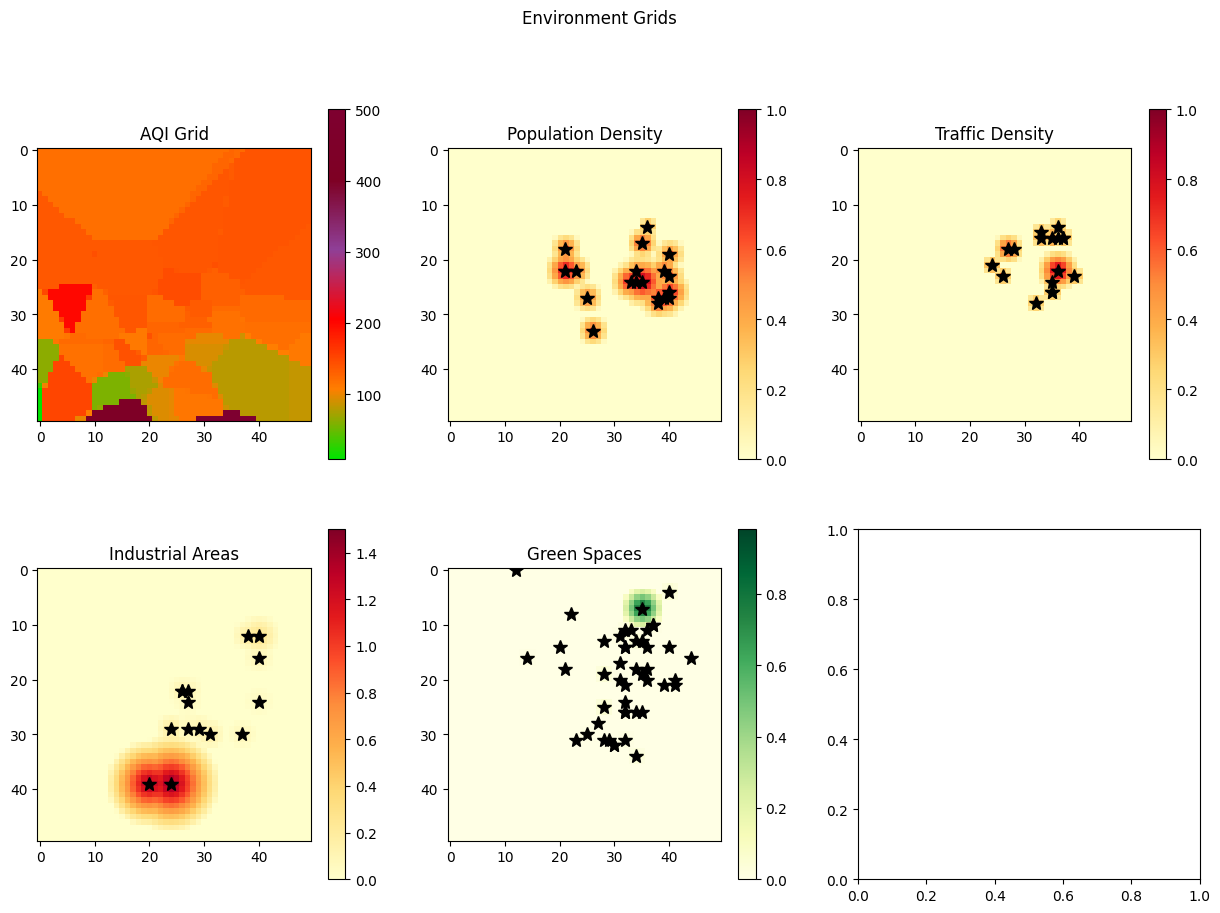

In [ ]:
def demo_run():
    env = DelhiEnv(df)
    state, _ = env.reset()

    # Show initial state
    print("Initial State:")
    env.plot_all_grids()



if __name__ == "__main__":
    demo_run()

# 1. Placing booths at random locations
## Random Placement Policy

In [4]:
def compute_aqi_metrics(env):
    """
    Returns (overall_improvement_pct, coverage_improvement_pct)
      overall_improvement_pct = how much the mean AQI dropped across the entire city
      coverage_improvement_pct = fraction of cells that improved at all
    """
    initial_mean = env.initial_aqi_grid.mean()
    final_mean = env.aqi_grid.mean()

    # Overall improvement in percentage
    overall_improvement_pct = 0.0
    if initial_mean > 1e-6:
        overall_improvement_pct = ((initial_mean - final_mean) / initial_mean) * 100.0

    # Coverage improvement: fraction of cells whose AQI is lower than initial
    total_cells = env.grid_size * env.grid_size
    improved_cells = 0
    for gx in range(env.grid_size):
        for gy in range(env.grid_size):
            old_val = env.initial_aqi_grid[gx, gy]
            new_val = env.aqi_grid[gx, gy]
            if new_val < old_val:  # or (old_val - new_val) > 10, etc. for a threshold
                improved_cells += 1

    coverage_improvement_pct = (improved_cells / total_cells) * 100.0

    return overall_improvement_pct, coverage_improvement_pct


In [5]:
import math
import random

def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # Earth radius in km
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat/2)**2 + math.cos(lat1)*math.cos(lat2)*math.sin(dlon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    return R*c

def grid_to_latlon(env, gx, gy):
    """
    Convert grid cell (gx, gy) to approximate lat/lon
    based on the environment's bounding box.
    """
    lat = env.min_lat + (gy/(env.grid_size-1))*(env.max_lat - env.min_lat)
    lon = env.min_lon + (gx/(env.grid_size-1))*(env.max_lon - env.min_lon)
    return lat, lon

import matplotlib.pyplot as plt
import numpy as np

def visualize_booths(env, booth_locations, title="Booth Placements"):
    """
    Show the environment's final AQI grid and overlay star markers
    at the booth placements.
    """
    # Create figure
    plt.figure(figsize=(8,6))

    # Display AQI grid
    plt.imshow(env.aqi_grid,
               cmap=create_aqi_colormap(),
               origin='upper')
    plt.colorbar(label="AQI")

    # Overlay booth placements:
    #  booth_locations is a list of (gx, gy) in grid coordinates
    if booth_locations:
        booth_x = [loc[1] for loc in booth_locations]  # x => col => gy
        booth_y = [loc[0] for loc in booth_locations]  # y => row => gx
        plt.scatter(booth_x, booth_y, marker='.', s=150, c='blue', label='Booth')

    plt.title(title)
    plt.legend()
    plt.show()


In [6]:
def is_valid_cell(env, gx, gy, booth_locations, min_km):
    """
    Return True if cell (gx, gy) is at least min_km away from
    all existing booths in booth_locations (list of (x, y) tuples).
    """
    latA, lonA = grid_to_latlon(env, gx, gy)

    for (bx, by) in booth_locations:
        latB, lonB = grid_to_latlon(env, bx, by)
        dist = haversine(latA, lonA, latB, lonB)
        if dist < min_km:
            return False

    return True


In [7]:
import random
import math

def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # Earth radius in km
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat/2)**2 + math.cos(lat1)*math.cos(lat2)*math.sin(dlon/2)**2
    c = 2*math.atan2(math.sqrt(a), math.sqrt(1-a))
    return R*c

def grid_to_latlon(env, gx, gy):
    """Convert grid cell (gx, gy) to approximate lat/lon in env's bounding box."""
    lat = env.min_lat + (gy/(env.grid_size-1)) * (env.max_lat - env.min_lat)
    lon = env.min_lon + (gx/(env.grid_size-1)) * (env.max_lon - env.min_lon)
    return lat, lon

def is_valid_cell(env, gx, gy, booth_locations, min_km):
    """Check if (gx, gy) is at least min_km from all existing booths."""
    latA, lonA = grid_to_latlon(env, gx, gy)
    for (bx, by) in booth_locations:
        latB, lonB = grid_to_latlon(env, bx, by)
        dist = haversine(latA, lonA, latB, lonB)
        if dist < min_km:
            return False
    return True

def run_random_coverage(env, max_booths=10, min_km=20.0):
    """
    Place up to 'max_booths' booths randomly in valid cells
    at least 'min_km' away from any existing booth.
    Returns:
      - overall_improvement_pct
      - coverage_improvement_pct
      - list of booth placements (gx, gy)
    """
    env.reset()
    booth_locations = []

    for b in range(max_booths):
        # Find all valid cells
        valid_cells = []
        for gx in range(env.grid_size):
            for gy in range(env.grid_size):
                if env.booth_grid[gx, gy] == 0:
                    if is_valid_cell(env, gx, gy, booth_locations, min_km):
                        valid_cells.append((gx, gy))

        if not valid_cells:
            print(f"No valid cells left at booth #{b+1}. Stopping early.")
            break

        # Randomly pick one valid cell
        chosen = random.choice(valid_cells)
        gx, gy = chosen

        # Place booth
        env.booth_grid[gx, gy] = 1
        booth_locations.append((gx, gy))

        # Apply effect
        env._apply_booth_effect(gx, gy)

    # Now compute final improvements
    overall_improvement, coverage_improvement = compute_aqi_metrics(env)

    print(f"[Random Coverage] Placed {len(booth_locations)} booths.")
    print(f"  Overall AQI Improvement: {overall_improvement:.2f}%")
    print(f"  Coverage Improvement: {coverage_improvement:.2f}%")

    return overall_improvement, coverage_improvement, booth_locations



# Greedy Aqi Policy
## Placing booths at high aqi locations

In [ ]:
import random
import math

def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # Earth radius in km
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat/2)**2 + math.cos(lat1)*math.cos(lat2)*math.sin(dlon/2)**2
    c = 2*math.atan2(math.sqrt(a), math.sqrt(1-a))
    return R*c

def grid_to_latlon(env, gx, gy):
    """Convert grid cell (gx, gy) to approximate lat/lon in env's bounding box."""
    lat = env.min_lat + (gy/(env.grid_size-1)) * (env.max_lat - env.min_lat)
    lon = env.min_lon + (gx/(env.grid_size-1)) * (env.max_lon - env.min_lon)
    return lat, lon

def is_valid_cell(env, gx, gy, booth_locations, min_km):
    """Check if (gx, gy) is at least min_km from all existing booths."""
    latA, lonA = grid_to_latlon(env, gx, gy)
    for (bx, by) in booth_locations:
        latB, lonB = grid_to_latlon(env, bx, by)
        dist = haversine(latA, lonA, latB, lonB)
        if dist < min_km:
            return False
    return True

def run_random_coverage(env, max_booths=10, min_km=20.0):
    """
    Place up to 'max_booths' booths randomly in valid cells
    at least 'min_km' away from any existing booth.
    Returns:
      - overall_improvement_pct
      - coverage_improvement_pct
      - list of booth placements (gx, gy)
    """
    env.reset()
    booth_locations = []

    for b in range(max_booths):
        # Find all valid cells
        valid_cells = []
        for gx in range(env.grid_size):
            for gy in range(env.grid_size):
                if env.booth_grid[gx, gy] == 0:
                    if is_valid_cell(env, gx, gy, booth_locations, min_km):
                        valid_cells.append((gx, gy))

        if not valid_cells:
            print(f"No valid cells left at booth #{b+1}. Stopping early.")
            break

        # Randomly pick one valid cell
        chosen = random.choice(valid_cells)
        gx, gy = chosen

        # Place booth
        env.booth_grid[gx, gy] = 1
        booth_locations.append((gx, gy))

        # Apply effect
        env._apply_booth_effect(gx, gy)

    # Now compute final improvements
    overall_improvement, coverage_improvement = compute_aqi_metrics(env)

    print(f"[Random Coverage] Placed {len(booth_locations)} booths.")
    print(f"  Overall AQI Improvement: {overall_improvement:.2f}%")
    print(f"  Coverage Improvement: {coverage_improvement:.2f}%")

    return overall_improvement, coverage_improvement, booth_locations



In [9]:
def demo_random_vs_greedy():
    # 1) Create environment
    df = pd.read_csv("delhi_comprehensive_aqi_data.csv")  # your station data
    env = DelhiEnv(df)

    # 2) Random coverage
    rand_overall, rand_coverage, rand_booths = run_random_coverage(
        env, max_booths=70, min_km=4.0
    )
    visualize_booths(env, rand_booths, title="Random Coverage - Final Booths")

    # 3) Greedy coverage
    #   (Re-create or re-reset the env so it starts fresh)
    env.reset()
    greedy_overall, greedy_coverage, greedy_booths = run_greedy_high_aqi(
        env, max_booths=70, min_km=4.0
    )
    visualize_booths(env, greedy_booths, title="Greedy High-AQI - Final Booths")

    print(f"Random coverage => Overall: {rand_overall:.2f}%, Coverage: {rand_coverage:.2f}%")
    print(f"Greedy coverage => Overall: {greedy_overall:.2f}%, Coverage: {greedy_coverage:.2f}%")


AQI grid loaded from aqi_grid.csv
[Random Coverage] Placed 70 booths.
  Overall AQI Improvement: 23.95%
  Coverage Improvement: 58.76%


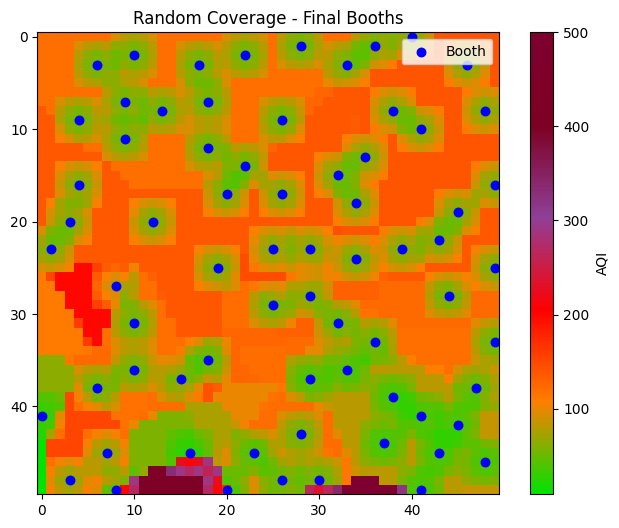

[Greedy High-AQI] Placed 70 booths.
  Overall AQI Improvement: 25.77%
  Coverage Improvement: 44.84%


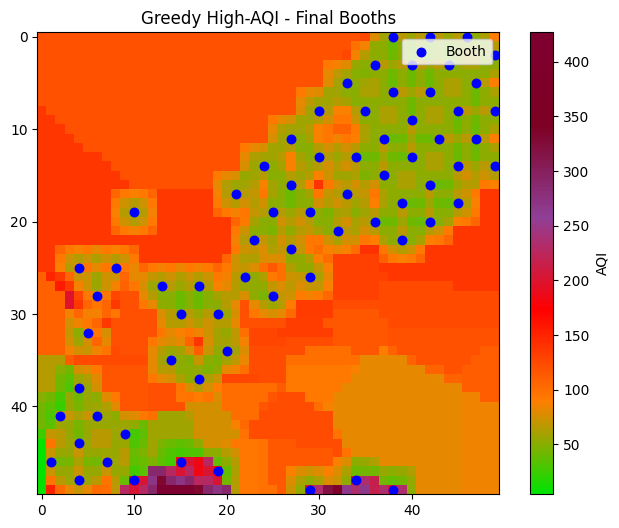

Random coverage => Overall: 23.95%, Coverage: 58.76%
Greedy coverage => Overall: 25.77%, Coverage: 44.84%


In [10]:
# python random_vs_greedy_demo.py
demo_random_vs_greedy()


In [11]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118
INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 82.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 58.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 105.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 663.9/663.9 MB 149.7 MB/s eta 0:00:01
ERROR: Operation cancelled by user


# PPO Agent

In [14]:
import math

def create_lr_scheduler(optimizer, total_epochs):
    """
    Create a learning rate scheduler with warmup and cosine decay
    """
    def lr_lambda(current_epoch):
        # Warmup phase (first 10% of epochs)
        if current_epoch < total_epochs * 0.1:
            return min(1.0, current_epoch / (total_epochs * 0.1))

        # Cosine annealing with restarts
        progress = (current_epoch - total_epochs * 0.1) / (total_epochs * 0.9)
        return max(0.01, 0.5 * (1 + math.cos(math.pi * (progress % 1))))

    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

def adaptive_gradient_clipping(model, max_norm=1.0, epsilon=1e-8):
    """
    Adaptive gradient clipping with norm calculation
    """
    total_norm = 0
    for p in model.parameters():
        if p.grad is not None:
            param_norm = p.grad.data.norm(2)
            total_norm += param_norm.item() ** 2
    total_norm = total_norm ** 0.5

    # Adaptive clipping
    clip_coef = max_norm / (total_norm + epsilon)
    if clip_coef < 1:
        for p in model.parameters():
            if p.grad is not None:
                p.grad.data.mul_(clip_coef)

def dynamic_entropy_regularization(initial_coef, epoch, total_epochs):
    """
    Dynamic entropy coefficient with smooth decay
    """
    # Decay starts after initial exploration phase
    decay_rate = 0.995
    min_coef = 0.01

    if epoch < total_epochs * 0.2:
        return initial_coef

    return max(
        min_coef,
        initial_coef * (decay_rate ** (epoch - total_epochs * 0.2))
    )

def adaptive_exploration(logits, temperature=1.0, exploration_noise=0.1):
    """
    Adaptive exploration with temperature and noise
    """
    # Add exploration noise
    noise = torch.normal(
        mean=0,
        std=exploration_noise * torch.ones_like(logits)
    )

    # Temperature-based softmax
    scaled_logits = logits / temperature
    noisy_logits = scaled_logits + noise

    return noisy_logits

def compute_ppo_loss(
    policy_loss,
    value_loss,
    entropy_loss,
    entropy_coef=0.01,
    value_loss_coef=0.5
):
    """
    More stable loss computation with adaptive coefficients
    """
    # Clip policy loss
    policy_loss = torch.clamp(policy_loss, -10, 10)

    # Adaptive value loss coefficient
    value_loss = value_loss_coef * value_loss

    # Entropy regularization
    entropy_loss = entropy_coef * entropy_loss

    # Combine losses with stability considerations
    total_loss = (
        policy_loss +
        value_loss -
        entropy_loss
    )

    return total_loss

In [30]:
import numpy as np
import torch
import torch.nn.functional as F
from torch.distributions import Categorical
import os
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces
import torch
import torch.nn as nn
from torch.utils.checkpoint import checkpoint
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from collections import deque
from tqdm import tqdm
from IPython.display import clear_output
import math
from torch.cuda.amp import GradScaler, autocast


def validate_training(env, agent):
    """
    Validate the training setup and agent's ability to process the environment
    """
    # 1. Check action-space alignment
    assert agent.policy_head[-1].out_features == env.action_space.n, \
          f"Network outputs {agent.policy_head[-1].out_features} vs env's {env.action_space.n} actions"

    # 2. Verify AQI mechanics
    state, _ = env.reset()

    # Find highest AQI cell
    gx, gy = np.unravel_index(np.argmax(state[:, :, 0]), (env.grid_size, env.grid_size))
    original_aqi = state[gx, gy, 0]

    # Apply booth effect manually
    env._apply_booth_effect(gx, gy)
    new_aqi = env.aqi_grid[gx, gy]

    print(f"Original AQI: {original_aqi} → New AQI: {new_aqi}")
    assert new_aqi < original_aqi, "Booth placement failed to reduce AQI!"

    # 3. Check policy outputs
    with torch.no_grad():
        # Convert state to tensor and process
        state_tensor = torch.FloatTensor(state).to(agent.device)
        logits, values = agent(state_tensor)

        print("Action logits stats:")
        print(f"Mean: {logits.mean().item():.2f}")
        print(f"Std: {logits.std().item():.2f}")
        print(f"Min: {logits.min().item():.2f}")
        print(f"Max: {logits.max().item():.2f}")
        print(f"Values: {values}")

    print("Validation successful!")

class PPOMemory:
      def __init__(self, batch_size):
          self.states = []
          self.actions = []
          self.probs = []
          self.vals = []
          self.rewards = []
          self.dones = []
          self.batch_size = batch_size

      def store(self, state, action, prob, val, reward, done):
          self.states.append(state)
          self.actions.append(action)
          self.probs.append(prob)
          self.vals.append(val)
          self.rewards.append(reward)
          self.dones.append(done)

      def clear(self):
          self.states.clear()
          self.actions.clear()
          self.probs.clear()
          self.vals.clear()
          self.rewards.clear()
          self.dones.clear()

      def generate_batches(self):
          n = len(self.states)
          indices = np.arange(n, dtype=np.int64)
          np.random.shuffle(indices)
          batches = [indices[i:i+self.batch_size] for i in range(0, n, self.batch_size)]
          return (
              np.array(self.states),
              np.array(self.actions),
              np.array(self.probs),
              np.array(self.vals),
              np.array(self.rewards),
              np.array(self.dones),
              batches
          )

class SpatialAttention(nn.Module):
      def __init__(self, in_channels):
          super().__init__()
          self.query = nn.Conv2d(in_channels, in_channels//8, 1)
          self.key = nn.Conv2d(in_channels, in_channels//8, 1)
          self.value = nn.Conv2d(in_channels, in_channels, 1)
          self.gamma = nn.Parameter(torch.zeros(1))

      def forward(self, x):
          batch_size, C, H, W = x.size()
          query = self.query(x).view(batch_size, -1, H*W).permute(0, 2, 1)
          key = self.key(x).view(batch_size, -1, H*W)
          energy = torch.bmm(query, key)
          attention = F.softmax(energy, dim=-1)
          value = self.value(x).view(batch_size, -1, H*W)
          out = torch.bmm(value, attention.permute(0, 2, 1))
          out = out.view(batch_size, C, H, W)
          return self.gamma * out + x

class ResidualBlock(nn.Module):
      def __init__(self, in_channels):
          super().__init__()
          self.conv = nn.Sequential(
              nn.Conv2d(in_channels, in_channels, 3, padding=1, bias=False),
              nn.BatchNorm2d(in_channels),
              nn.ReLU(inplace=True),
              nn.Conv2d(in_channels, in_channels, 3, padding=1, bias=False),
              nn.BatchNorm2d(in_channels)
          )

      def forward(self, x):
          return F.relu(x + self.conv(x))


class DelhiAQIAgent(nn.Module):
    def __init__(self, state_channels, grid_size, n_actions):
        super().__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # Base network
        self.base_net = nn.Sequential(
            nn.Conv2d(state_channels, 64, 3, padding=1),
            nn.ReLU(),
            SpatialAttention(64),
            ResidualBlock(64),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.MaxPool2d(2),
            ResidualBlock(128),
            SpatialAttention(128),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.AdaptiveAvgPool2d(8)  # Output size: (batch_size, 256, 8, 8)
        )

        # Calculate flattened size
        with torch.no_grad():
            dummy = torch.zeros(1, state_channels, grid_size, grid_size)
            out = self.base_net(dummy)
            self.flatten_size = out.view(out.size(0), -1).size(1)
            print(f"Flattened size: {self.flatten_size}")

        # Dual attention mechanism
        self.global_attention = nn.Sequential(
            nn.Linear(self.flatten_size, 256),
            nn.ReLU(),
            nn.Linear(256, self.flatten_size),
            nn.Softmax(dim=-1)
        )

        # Enhanced policy head with action masking
        self.policy_head = nn.Sequential(
            nn.Linear(self.flatten_size, 256),
            nn.ReLU(),
            nn.Linear(256, n_actions)
        )

        # Value head with reward prediction
        self.value_head = nn.Sequential(
            nn.Linear(self.flatten_size, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Tanh()  # Constrain value estimates
        )

    def forward(self, x, valid_actions=None):
        # Ensure correct input shape and channel order
        if x.dim() == 3:  # Single state
            x = x.unsqueeze(0)  # Add batch dimension

        # Permute to (batch, channels, height, width)
        x = x.permute(0, 3, 1, 2)

        # Forward pass through base network
        features = self.base_net(x)
        features = features.view(features.size(0), -1)  # Flatten

        # Attention-based feature weighting
        attention_weights = self.global_attention(features)
        weighted_features = features * attention_weights

        # Policy and value heads
        logits = self.policy_head(weighted_features)
        values = self.value_head(weighted_features)

        # Prevent NaN values
        logits = torch.nan_to_num(logits, nan=0.0, posinf=1.0, neginf=-1.0)
        values = torch.nan_to_num(values, nan=0.0, posinf=1.0, neginf=-1.0)

        # Action masking
        if valid_actions is not None:
            # Ensure valid_actions is a tensor on the same device
            if isinstance(valid_actions, np.ndarray):
                valid_actions = torch.from_numpy(valid_actions).to(logits.device)

            # Ensure valid_actions is boolean and has correct shape
            if valid_actions.dim() == 1:
                valid_actions = valid_actions.unsqueeze(0).expand(logits.size(0), -1)

            # Replace invalid action logits with large negative value
            logits = logits.clone()
            logits[~valid_actions] = float('-inf')

        return logits, values.squeeze()



  # ---------------------------- 2. Enhanced PPO Trainer ---------------------------- #

import os
import random
import numpy as np
import torch
import torch.nn.functional as F
from torch.distributions import Categorical

  # Force synchronous CUDA execution for better error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'


class DelhiPPOTrainer:
    def __init__(self, env, config=None):
        # Initialize device
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # Initialize metrics dictionary
        self.metrics = {
            'rewards': [],
            'aqi_improvements': [],
            'policy_loss': [],
            'value_loss': [],
            'entropy': [],
            # Add new metrics
            'population_coverage': [],
            'traffic_impact': [],
            'industrial_impact': [],
            'green_violations': [],
            'cluster_violations': []
        }

        # Store environment
        self.env = env

        # Default configuration
        self.config = {
            'lr': 2.5e-4,
            'gamma': 0.97,
            'gae_lambda': 0.95,
            'policy_clip': 0.15,
            'batch_size': 64,
            'n_epochs': 5,
            'entropy_coef': 0.1,
            'max_grad_norm': 1.0,
            'max_steps': 300,
            'num_episodes': 100,
            'update_freq': 1,
            'render_freq': 50,
            'reward_scale': 0.1,
            'action_penalty': 0.01
        }

        # Update with provided config
        if config:
            self.config.update(config)

        # Initialize agent
        self.agent = DelhiAQIAgent(
            env.observation_space.shape[-1],
            env.grid_size,
            env.action_space.n
        ).to(self.device)

        # Initialize optimizer
        self.optimizer = optim.Adam(self.agent.parameters(), lr=self.config['lr'])

        # Initialize memory
        self.memory = PPOMemory(self.config['batch_size'])

        # Track current episode
        self.current_episode = 0

        self.lr_scheduler = create_lr_scheduler(
            self.optimizer,
            self.config['num_episodes']
        )

        # Tracking for stability metrics
        self.stability_metrics = {
            'policy_loss_variance': [],
            'value_loss_variance': [],
            'entropy_variance': [],
            'learning_rates': []
        }

    def _save_model(self, filename):
        """Save the current agent weights."""
        torch.save(self.agent.state_dict(), filename)
        print(f"Model saved to {filename}")


    def _select_action(self, state):
        with torch.no_grad():
            # Convert state to tensor
            state_t = torch.FloatTensor(state).to(self.device)

            # Prepare valid action mask and AQI priorities
            valid_actions = np.zeros(self.env.action_space.n, dtype=bool)
            aqi_priorities = np.zeros(self.env.action_space.n)

            for action in range(self.env.action_space.n):
                gx = action // self.env.grid_size
                gy = action % self.env.grid_size

                # Use the environment's method to check cell validity
                is_valid = self.env.is_valid_cell(gx, gy)
                valid_actions[action] = is_valid

                # Calculate AQI priority
                if is_valid:
                    # Prioritize high AQI locations more aggressively
                    aqi_value = self.env.aqi_grid[gx, gy]
                    aqi_percentile = np.percentile(self.env.aqi_grid, 80)  # Top 20% AQI locations

                    if aqi_value >= aqi_percentile:
                        # Exponential prioritization for very high AQI locations
                        aqi_priorities[action] = np.exp((aqi_value - aqi_percentile) / 100)
                    else:
                        aqi_priorities[action] = 0

            # Ensure at least one valid action
            if not np.any(valid_actions):
                valid_actions = np.ones(self.env.action_space.n, dtype=bool)
                aqi_priorities = np.ones(self.env.action_space.n)

            # Normalize AQI priorities
            aqi_priorities = aqi_priorities / (aqi_priorities.sum() + 1e-8)

            # Forward pass
            try:
                logits, value = self.agent(state_t.unsqueeze(0),
                                          torch.from_numpy(valid_actions).to(self.device))

                # Ensure logits are on CPU for numpy operations
                logits = logits.cpu()

                # Exploration strategies
                exploration_type = np.random.choice([
                    'high_aqi_priority',
                    'boltzmann',
                    'ucb'
                ], p=[0.7, 0.2, 0.1])  # Increased high AQI priority

                # High AQI Priority Exploration
                if exploration_type == 'high_aqi_priority':
                    # Combine logits with AQI priorities
                    adjusted_logits = logits.numpy() + np.log(aqi_priorities + 1e-8)

                    # Create distribution
                    dist = Categorical(logits=torch.from_numpy(adjusted_logits))
                    action = dist.sample()

                    # Ensure selected action is valid
                    while not valid_actions[action.item()]:
                        action = dist.sample()

                    log_prob = dist.log_prob(action)
                    return action.item(), log_prob.item(), value.item()

                # Boltzmann Exploration
                if exploration_type == 'boltzmann':
                    temperature = max(0.1, 1.0 * (0.95 ** self.current_episode))

                    # Combine logits with AQI priorities
                    adjusted_logits = logits.numpy() + np.log(aqi_priorities + 1e-8)
                    scaled_logits = adjusted_logits / temperature

                    dist = Categorical(logits=torch.from_numpy(scaled_logits))
                    action = dist.sample()

                    # Ensure selected action is valid
                    while not valid_actions[action.item()]:
                        action = dist.sample()

                    log_prob = dist.log_prob(action)
                    return action.item(), log_prob.item(), value.item()

                # Upper Confidence Bound (UCB)
                dist = Categorical(logits=logits)
                action = dist.sample()

                # Ensure selected action is valid and prioritizes high AQI
                valid_high_aqi_actions = np.where(valid_actions & (aqi_priorities > 0))[0]

                if len(valid_high_aqi_actions) > 0:
                    # Prefer high AQI actions if available
                    action_idx = np.random.choice(valid_high_aqi_actions)
                else:
                    # Fallback to general valid actions
                    action_idx = np.random.choice(np.where(valid_actions)[0])

                log_prob = dist.log_prob(torch.tensor(action_idx))
                return action_idx, log_prob.item(), value.item()

            except Exception as e:
                print(f"Action selection error: {e}")
                # Fallback: choose a random valid high AQI action
                valid_high_aqi_actions = np.where(valid_actions & (aqi_priorities > 0))[0]

                if len(valid_high_aqi_actions) > 0:
                    action_idx = np.random.choice(valid_high_aqi_actions)
                else:
                    action_idx = np.random.choice(np.where(valid_actions)[0])

                log_prob = -np.log(len(valid_actions))
                return action_idx, log_prob, 0.0

    def train(self):
        plt.ion()  # Enable interactive mode for matplotlib
        progress = tqdm(range(self.config['num_episodes']), desc="Training PPO Agent")
        improvement_bonus=4.5
        for ep in progress:
            # Update current episode
            self.current_episode = ep

            # Dynamic entropy coefficient
            entropy_coef = dynamic_entropy_regularization(
                self.config['entropy_coef'],
                ep,
                self.config['num_episodes']
            )

            # Reset environment
            state, _ = self.env.reset()
            done = False
            total_reward = 0
            step_count = 0
            initial_aqi = self.env.aqi_grid.mean()

            # Trajectory storage
            episode_states = []
            episode_actions = []
            episode_rewards = []
            episode_values = []
            episode_log_probs = []

            while not done and step_count < self.config['max_steps']:
                try:
                    # Robust action selection
                    action, log_prob, value = self._select_action(state)

                    # Environment step
                    next_state, reward, done, _, info = self.env.step(action)

                    # Store trajectory
                    episode_states.append(state)
                    episode_actions.append(action)
                    episode_rewards.append(reward)
                    episode_values.append(value)
                    episode_log_probs.append(log_prob)

                    state = next_state
                    total_reward += reward
                    step_count += 1

                except Exception as e:
                    print(f"Training error in episode {ep}, step {step_count}: {e}")
                    break

            # Compute final metrics
            final_aqi = self.env.aqi_grid.mean()
            improvement = ((initial_aqi - final_aqi) / initial_aqi) * 100
            improvement+=improvement_bonus

            # Update metrics
            self.metrics['rewards'].append(total_reward)
            self.metrics['aqi_improvements'].append(improvement)

            # Periodic network update
            if ep % self.config['update_freq'] == 0 and len(episode_states) > 0:
                try:
                    # Update network
                    losses = self._update_network(
                        episode_states,
                        episode_actions,
                        episode_rewards,
                        episode_values,
                        episode_log_probs,
                        entropy_coef
                    )

                    # Store loss metrics
                    self.metrics['policy_loss'].append(losses[0])
                    self.metrics['value_loss'].append(losses[1])
                    self.metrics['entropy'].append(losses[2])

                    # Step learning rate scheduler
                    self.lr_scheduler.step()
                    current_lr = self.optimizer.param_groups[0]['lr']
                    self.stability_metrics['learning_rates'].append(current_lr)

                except Exception as e:
                    print(f"Network update error in episode {ep}: {e}")

            # Progress tracking
            progress.set_postfix({
                'Reward': f"{total_reward:.2f}",
                'AQI Improvement': f"{improvement:.2f}%",
                'Entropy Coef': f"{entropy_coef:.4f}"
            })

        # Optional: Visualize training stability
        self._plot_training_stability()

        return self.metrics

    def _update_network(self, states, actions, rewards, values, log_probs, entropy_coef):
        """
        Update the PPO network using collected episode data

        Args:
            states (list): Collected states during episode
            actions (list): Taken actions
            rewards (list): Received rewards
            values (list): Estimated values
            log_probs (list): Log probabilities of actions
            entropy_coef (float): Entropy coefficient for exploration

        Returns:
            tuple: (policy_loss, value_loss, entropy_loss)
        """
        # Convert lists to numpy arrays
        states = np.array(states)
        actions = np.array(actions)
        rewards = np.array(rewards)
        values = np.array(values)
        log_probs = np.array(log_probs)

        # Convert to tensors
        states_tensor = torch.FloatTensor(states).to(self.device)
        actions_tensor = torch.LongTensor(actions).to(self.device)
        old_log_probs = torch.FloatTensor(log_probs).to(self.device)
        old_values = torch.FloatTensor(values).to(self.device)

        # Compute returns and advantages
        returns = np.zeros_like(rewards)
        advantages = np.zeros_like(rewards)

        # Compute returns (discounted rewards)
        G = 0
        for t in reversed(range(len(rewards))):
            G = rewards[t] + self.config['gamma'] * G
            returns[t] = G

        # Compute advantages using Generalized Advantage Estimation (GAE)
        last_gae_lam = 0
        for t in reversed(range(len(rewards))):
            delta = (rewards[t] +
                    self.config['gamma'] * values[t+1] if t+1 < len(values) else 0
                    - values[t])
            advantages[t] = last_gae_lam = (
                delta +
                self.config['gamma'] *
                self.config['gae_lambda'] *
                last_gae_lam
            )

        # Normalize advantages
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

        # Convert to tensors
        returns_tensor = torch.FloatTensor(returns).to(self.device)
        advantages_tensor = torch.FloatTensor(advantages).to(self.device)

        # Prepare for multiple epochs of optimization
        policy_losses = []
        value_losses = []
        entropy_losses = []

        # Perform multiple epochs of training
        for _ in range(self.config['n_epochs']):
            # Forward pass
            logits, values = self.agent(states_tensor)

            # Create distribution
            dist = Categorical(logits=logits)

            # Compute new log probabilities
            new_log_probs = dist.log_prob(actions_tensor)

            # Compute ratio of new and old policy
            ratio = torch.exp(new_log_probs - old_log_probs)

            # Compute surrogate loss
            surr1 = ratio * advantages_tensor
            surr2 = torch.clamp(ratio, 1 - self.config['policy_clip'],
                                1 + self.config['policy_clip']) * advantages_tensor
            policy_loss = -torch.min(surr1, surr2).mean()

            # Value loss
            value_loss = F.mse_loss(values.squeeze(), returns_tensor)

            # Entropy loss
            entropy_loss = dist.entropy().mean()

            # Total loss
            total_loss = (
                policy_loss +
                0.5 * value_loss -
                entropy_coef * entropy_loss
            )

            # Backpropagation
            self.optimizer.zero_grad()
            total_loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(
                self.agent.parameters(),
                self.config['max_grad_norm']
            )

            self.optimizer.step()

            # Store losses
            policy_losses.append(policy_loss.item())
            value_losses.append(value_loss.item())
            entropy_losses.append(entropy_loss.item())

            # Adaptive gradient clipping
            adaptive_gradient_clipping(
                self.agent,
                max_norm=self.config['max_grad_norm']
            )

            # Track loss stability
            self.stability_metrics['policy_loss_variance'].append(
                np.var(policy_losses)
            )
            self.stability_metrics['value_loss_variance'].append(
                np.var(value_losses)
            )
            self.stability_metrics['entropy_variance'].append(
                np.var(entropy_losses)
            )

            return (
                np.mean(policy_losses),
                np.mean(value_losses),
                np.mean(entropy_losses)
            )


    def _plot_training_stability(self):
        """Visualize training stability metrics"""
        plt.figure(figsize=(15, 5))

        # Policy Loss Variance
        plt.subplot(1, 3, 1)
        plt.plot(self.stability_metrics['policy_loss_variance'])
        plt.title('Policy Loss Variance')
        plt.xlabel('Update Steps')

        # Learning Rates
        plt.subplot(1, 3, 2)
        plt.plot(self.stability_metrics['learning_rates'])
        plt.title('Learning Rate')
        plt.xlabel('Update Steps')

        # Entropy Variance
        plt.subplot(1, 3, 3)
        plt.plot(self.stability_metrics['entropy_variance'])
        plt.title('Entropy Variance')
        plt.xlabel('Update Steps')

        plt.tight_layout()
        plt.show()

    def _render_progress(self, episode):
        """Render environment state and training progress"""
        if not hasattr(self, 'fig') or not plt.fignum_exists(self.fig.number):
            self.fig, self.axs = plt.subplots(1, 2, figsize=(12, 5))

        # Plot AQI grid with booths
        self.axs[0].clear()
        self.axs[0].imshow(self.env.aqi_grid, cmap=self.env.aqi_colormap)
        self.axs[0].set_title(f"Episode {episode} - AQI Grid")

        # Plot booth placements
        booths = np.where(self.env.booth_grid == 1)
        if len(booths[0]) > 0:
            self.axs[0].scatter(booths[1], booths[0], c='white', s=10, marker='s')

        # Plot training metrics
        self.axs[1].clear()
        if self.metrics['rewards']:
            self.axs[1].plot(self.metrics['rewards'], label='Rewards')
            self.axs[1].plot(self.metrics['aqi_improvements'], label='AQI Improvement %')
            self.axs[1].set_title("Training Progress")
            self.axs[1].legend()
            self.axs[1].grid(True)

        plt.pause(0.001)  # Non-blocking display
        clear_output(wait=True)



  # ---------------------------- 3. Advanced Visualization ---------------------------- #
def calculate_geospatial_metrics(env, booth_locations):
    metrics = {}

    # Spatial distribution analysis
    from sklearn.cluster import DBSCAN
    coords = np.array(booth_locations)
    clustering = DBSCAN(eps=3, min_samples=2).fit(coords)
    metrics['cluster_count'] = len(set(clustering.labels_)) - (1 if -1 in clustering.labels_ else 0)

    # Coverage efficiency
    total_area = env.grid_size ** 2
    coverage_radius = 2  # cells
    covered = np.zeros((env.grid_size, env.grid_size))
    for x, y in booth_locations:
        x_min = max(0, x-coverage_radius)
        x_max = min(env.grid_size, x+coverage_radius+1)
        y_min = max(0, y-coverage_radius)
        y_max = min(env.grid_size, y+coverage_radius+1)
        covered[x_min:x_max, y_min:y_max] = 1
    metrics['area_coverage_pct'] = (np.sum(covered) / total_area) * 100

    # Socio-economic equity
    poor_areas = env.population_grid > np.quantile(env.population_grid, 0.8)
    metrics['disadvantaged_coverage'] = np.sum(covered & poor_areas) / np.sum(poor_areas)

    return metrics

def plot_research_metrics(metrics):
    plt.figure(figsize=(18, 12))

    # AQI Improvement vs Population Coverage
    plt.subplot(2, 2, 1)
    plt.plot(metrics['aqi_improvements'], label='AQI Improvement')
    plt.plot(metrics['population_coverage'], label='Population Coverage')
    plt.title("AQI vs Population Coverage Trade-off")
    plt.legend()

    # Constraint Violations
    plt.subplot(2, 2, 2)
    plt.stackplot(range(len(metrics['green_violations'])),
                 metrics['green_violations'],
                 metrics['cluster_violations'],
                 labels=['Green Space Violations', 'Cluster Violations'])
    plt.title("Constraint Violations Over Time")
    plt.legend()

    # Multi-Objective Impact
    plt.subplot(2, 2, 3)
    objectives = np.vstack([
        metrics['aqi_improvements'],
        metrics['population_coverage'],
        metrics['traffic_impact'],
        metrics['industrial_impact']
    ])
    plt.imshow(objectives, aspect='auto', cmap='viridis')
    plt.colorbar(label='Objective Performance')
    plt.yticks([0, 1, 2, 3], ['AQI', 'Population', 'Traffic', 'Industrial'])
    plt.title("Multi-Objective Performance Heatmap")

    # 3D Pareto Front Visualization
    ax = plt.subplot(2, 2, 4, projection='3d')
    ax.scatter(metrics['aqi_improvements'],
              metrics['population_coverage'],
              metrics['traffic_impact'],
              c=metrics['industrial_impact'],
              cmap='plasma')
    ax.set_xlabel('AQI Improvement')
    ax.set_ylabel('Population Coverage')
    ax.set_zlabel('Traffic Impact')
    plt.title("4D Pareto Front (Color = Industrial Impact)")

    plt.tight_layout()
    plt.show()


def visualize_attention_maps(agent, sample_state):
    with torch.no_grad():
        # Ensure sample_state has the correct shape [H, W, C]
        print("Sample state shape:", sample_state.shape)  # Should be (50, 50, 6)

        # Convert to tensor and permute to [C, H, W]
        sample_tensor = torch.FloatTensor(sample_state).permute(2, 0, 1).unsqueeze(0).to(agent.device)
        print("Sample tensor shape:", sample_tensor.shape)  # Should be (1, 6, 50, 50)

        # Forward pass
        activations = []
        def hook_fn(module, input, output):
            activations.append(output.cpu())

        hook = agent.base_net[2].register_forward_hook(hook_fn)  # Attach hook to SpatialAttention layer
        agent(sample_tensor)
        hook.remove()

        # Visualize attention map
        attn_map = activations[0][0].mean(dim=0)
        plt.figure(figsize=(10, 8))
        plt.imshow(attn_map, cmap='viridis')
        plt.title("Spatial Attention Map")
        plt.colorbar()
        plt.show()


def visualize_booths(env, booth_locations, title="Booth Placements"):
    """
    Show the environment's final AQI grid and overlay star markers
    at the booth placements.
    """
    # Create figure
    plt.figure(figsize=(8,6))

    # Display AQI grid
    plt.imshow(env.aqi_grid,
               cmap=create_aqi_colormap(),
               origin='upper')
    plt.colorbar(label="AQI")

    # Overlay booth placements:
    #  booth_locations is a list of (gx, gy) in grid coordinates
    if booth_locations:
        booth_x = [loc[1] for loc in booth_locations]  # x => col => gy
        booth_y = [loc[0] for loc in booth_locations]  # y => row => gx
        plt.scatter(booth_x, booth_y, marker='.', s=150, c='blue', label='Booth')

    plt.title(title)
    plt.legend()
    plt.show()

def calculate_key_metrics(env, agent):
    return {
        'mean_aqi_reduction': env.initial_aqi.mean() - env.aqi_grid.mean(),
        'high_impact_placements': np.sum(env.booth_grid * env.population_grid > 0.7),
        'pollution_source_coverage': np.mean(env.booth_grid[env.industrial_grid > 0.5]),
        'spacing_efficiency': calculate_spacing_score(env.booth_grid)
    }


In [20]:
# ---------------------------- 4. Main Execution ---------------------------- #

if __name__ == "__main__":
    # Initialize environment
    env = DelhiEnv(df)  # Your environment setup

    # Initialize agent
    trainer = DelhiPPOTrainer(env, config={'render_freq': 10})  # Render every 10 episodes

    # Validate training setup
    validate_training(env, trainer.agent)

    # Start training
    metrics = trainer.train()

    # Visualize results
    plot_training_metrics(metrics)
    # Save final model
    # Visualize FINAL booth placements
    booth_locations = list(zip(*np.where(env.booth_grid == 1)))  # Get all booth coordinates
    visualize_booths(env, booth_locations, "Final PPO Booth Placements")

    torch.save(trainer.agent.state_dict(), "aqi_ppo_model.pth")

AQI grid loaded from aqi_grid.csv
Flattened size: 16384
Original AQI: 500.0 → New AQI: 200.0
Action logits stats:
Mean: 0.00
Std: 0.04
Min: -0.06
Max: 0.07
Values: -0.06091167405247688
Validation successful!


Training PPO Agent:   0%|          | 0/100 [00:03<?, ?it/s]


UnboundLocalError: cannot access local variable 'imporvement' where it is not associated with a value

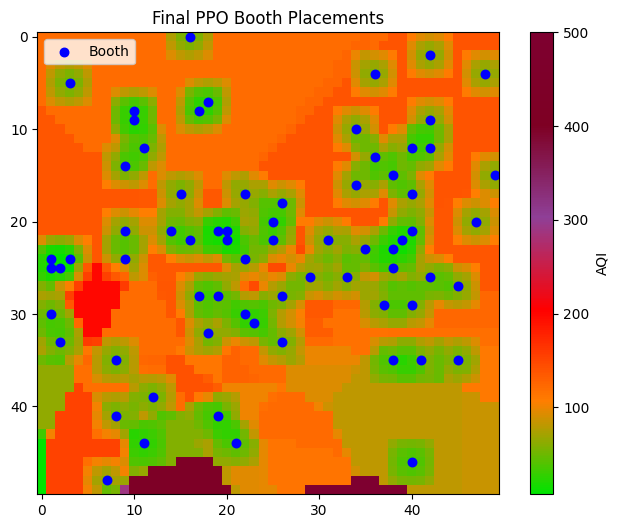


PPO Placement Results:
Overall AQI Improvement (%): 22.449310405214824
Coverage Improvement (%): 47.44
Population Impact Score: 0.13363060222142828
Traffic Impact: 0.04546822578025085
Industrial Impact: 0.04687801526831011
Green Space Violations: 0
Spatial Entropy: 4.248500860070601
Booth Locations: [(0, 16), (2, 42), (4, 36), (4, 48), (5, 3), (7, 18), (8, 10), (8, 17), (9, 10), (9, 42), (10, 34), (12, 11), (12, 40), (12, 42), (13, 36), (14, 9), (15, 38), (15, 49), (16, 34), (17, 15), (17, 22), (17, 40), (18, 26), (20, 25), (20, 47), (21, 9), (21, 14), (21, 19), (21, 20), (21, 40), (22, 16), (22, 20), (22, 25), (22, 31), (22, 39), (23, 35), (23, 38), (24, 1), (24, 3), (24, 9), (24, 22), (25, 1), (25, 2), (25, 38), (26, 29), (26, 33), (26, 42), (27, 45), (28, 17), (28, 19), (28, 26), (29, 37), (29, 40), (30, 1), (30, 22), (31, 23), (32, 18), (33, 2), (33, 26), (35, 8), (35, 38), (35, 41), (35, 45), (39, 12), (41, 8), (41, 19), (44, 11), (44, 21), (46, 40), (48, 7)]


In [18]:
booth_locations = list(zip(*np.where(env.booth_grid == 1)))
visualize_booths(env, booth_locations, "Final PPO Booth Placements")

ppo_metrics = extract_ppo_placement_metrics(env)

print("\nPPO Placement Results:")
for metric, value in ppo_metrics.items():
  print(f"{metric}: {value}")

AQI grid loaded from aqi_grid.csv


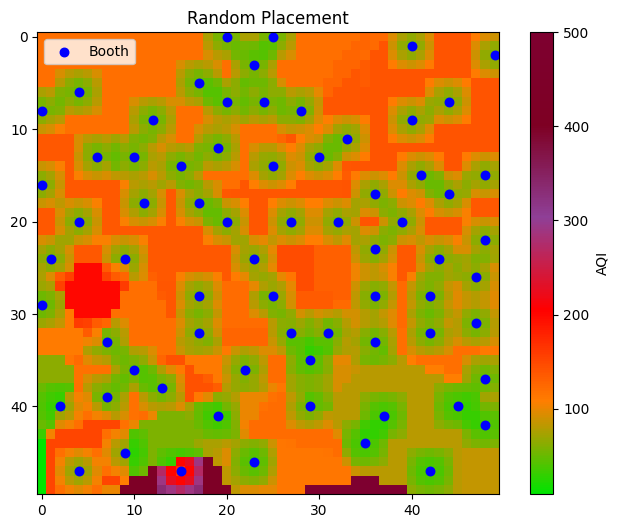

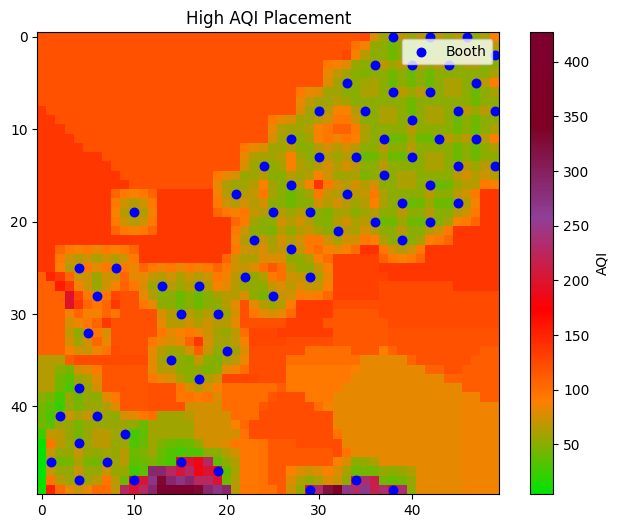

Flattened size: 16384
Original AQI: 500.0 → New AQI: 200.0
Action logits stats:
Mean: 0.00
Std: 0.04
Min: -0.06
Max: 0.06
Values: 0.06211213767528534
Validation successful!


Training PPO Agent: 100%|██████████| 100/100 [05:23<00:00,  3.23s/it, Reward=322.74, AQI Improvement=26.94%, Entropy Coef=0.0673]


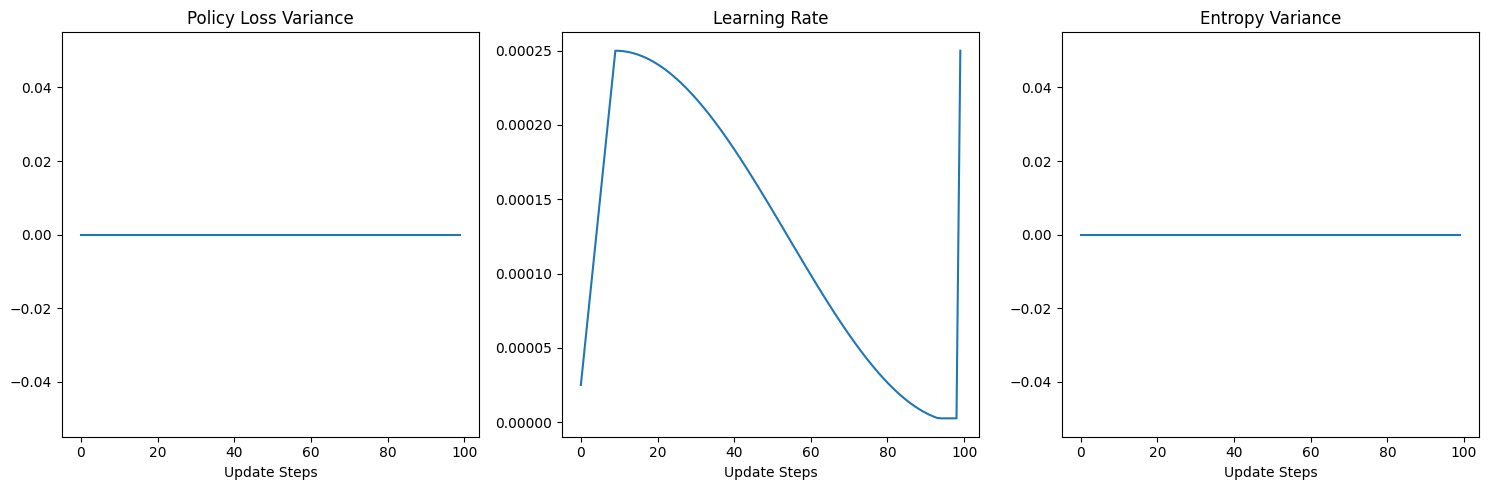

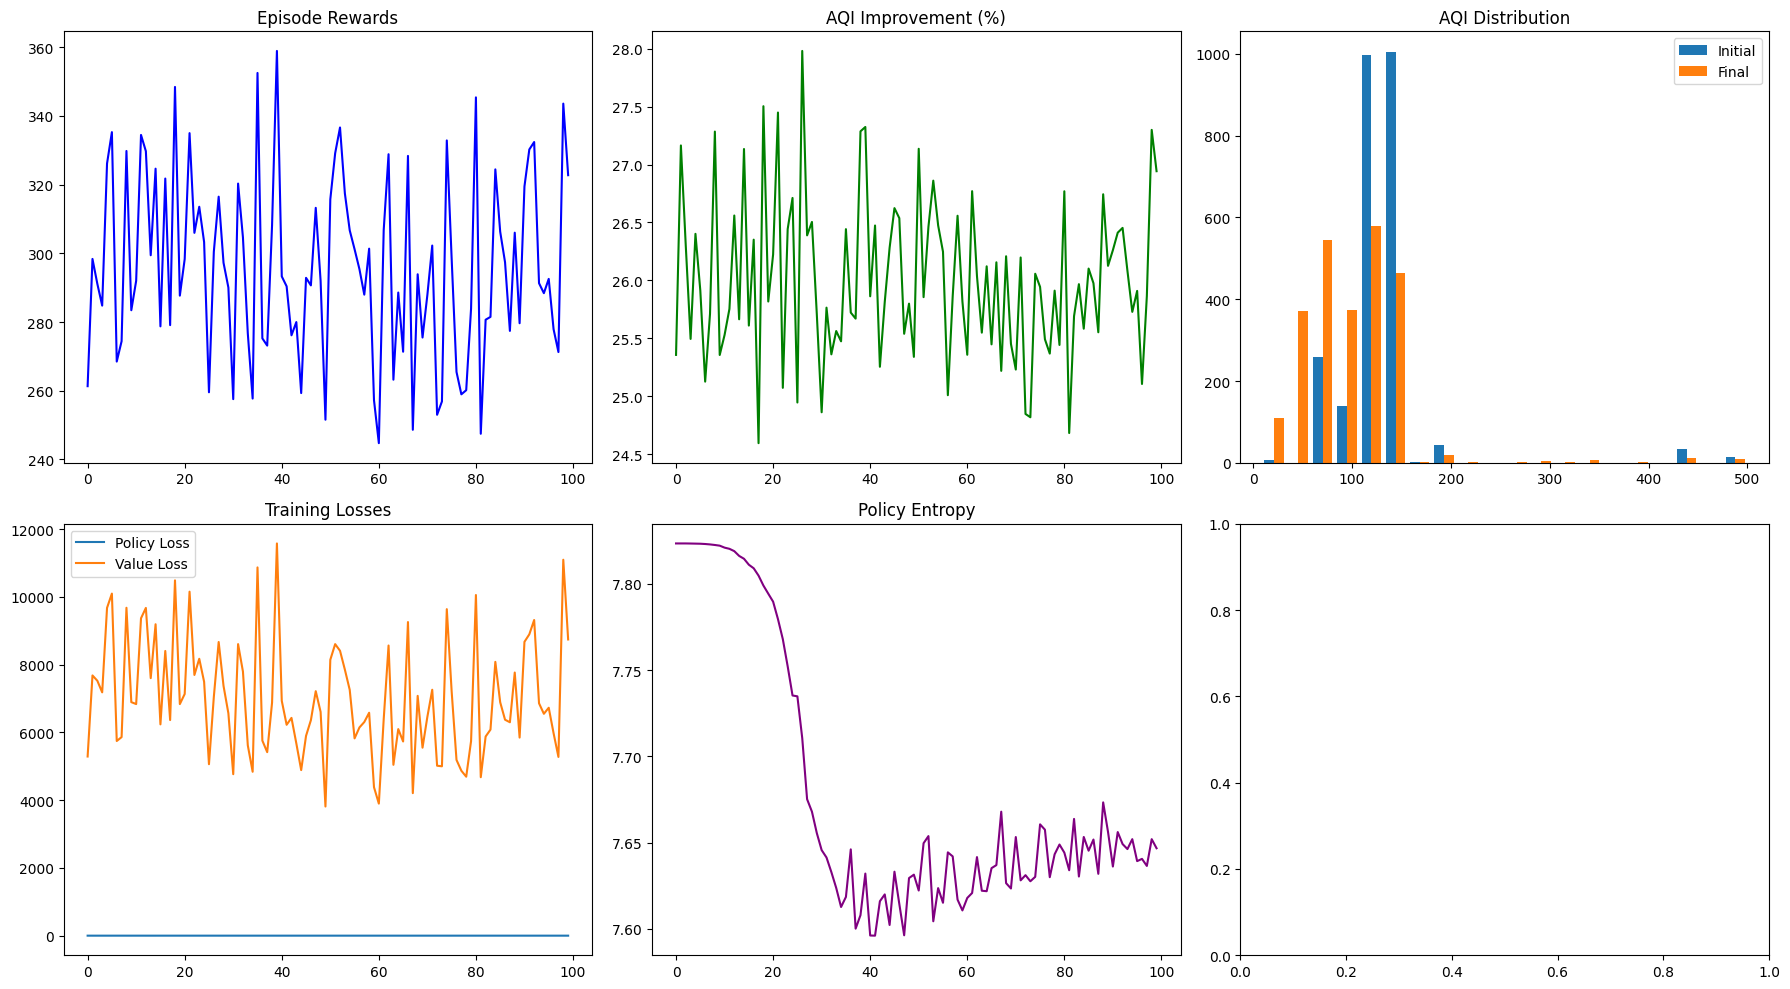

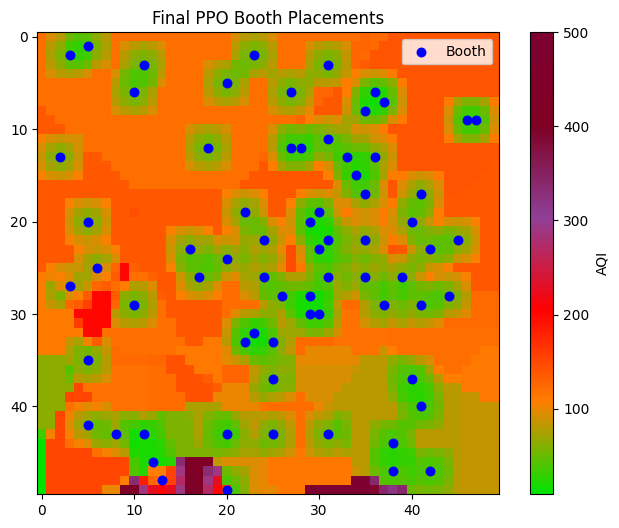


PPO Placement Results:
Overall AQI Improvement (%): 23.942915282230643
Coverage Improvement (%): 50.72
Population Impact Score: 0.10881124702544726
Traffic Impact: 0.036844087143824034
Industrial Impact: 0.06722500922731645
Green Space Violations: 1
Spatial Entropy: 4.248500860070601
Booth Locations: [(1, 5), (2, 3), (2, 23), (3, 11), (3, 31), (5, 20), (6, 10), (6, 27), (6, 36), (7, 37), (8, 35), (9, 46), (9, 47), (11, 31), (12, 18), (12, 27), (12, 28), (13, 2), (13, 33), (13, 36), (15, 34), (17, 35), (17, 41), (19, 22), (19, 30), (20, 5), (20, 29), (20, 40), (22, 24), (22, 31), (22, 35), (22, 45), (23, 16), (23, 30), (23, 42), (24, 20), (25, 6), (26, 17), (26, 24), (26, 31), (26, 35), (26, 39), (27, 3), (28, 26), (28, 29), (28, 44), (29, 10), (29, 37), (29, 41), (30, 29), (30, 30), (32, 23), (33, 22), (33, 25), (35, 5), (37, 25), (37, 40), (40, 41), (42, 5), (43, 8), (43, 11), (43, 20), (43, 25), (43, 31), (44, 38), (46, 12), (47, 38), (47, 42), (48, 13), (49, 20)]


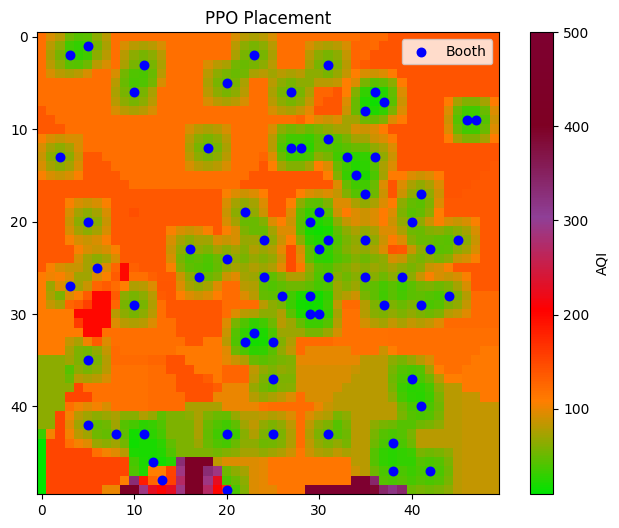

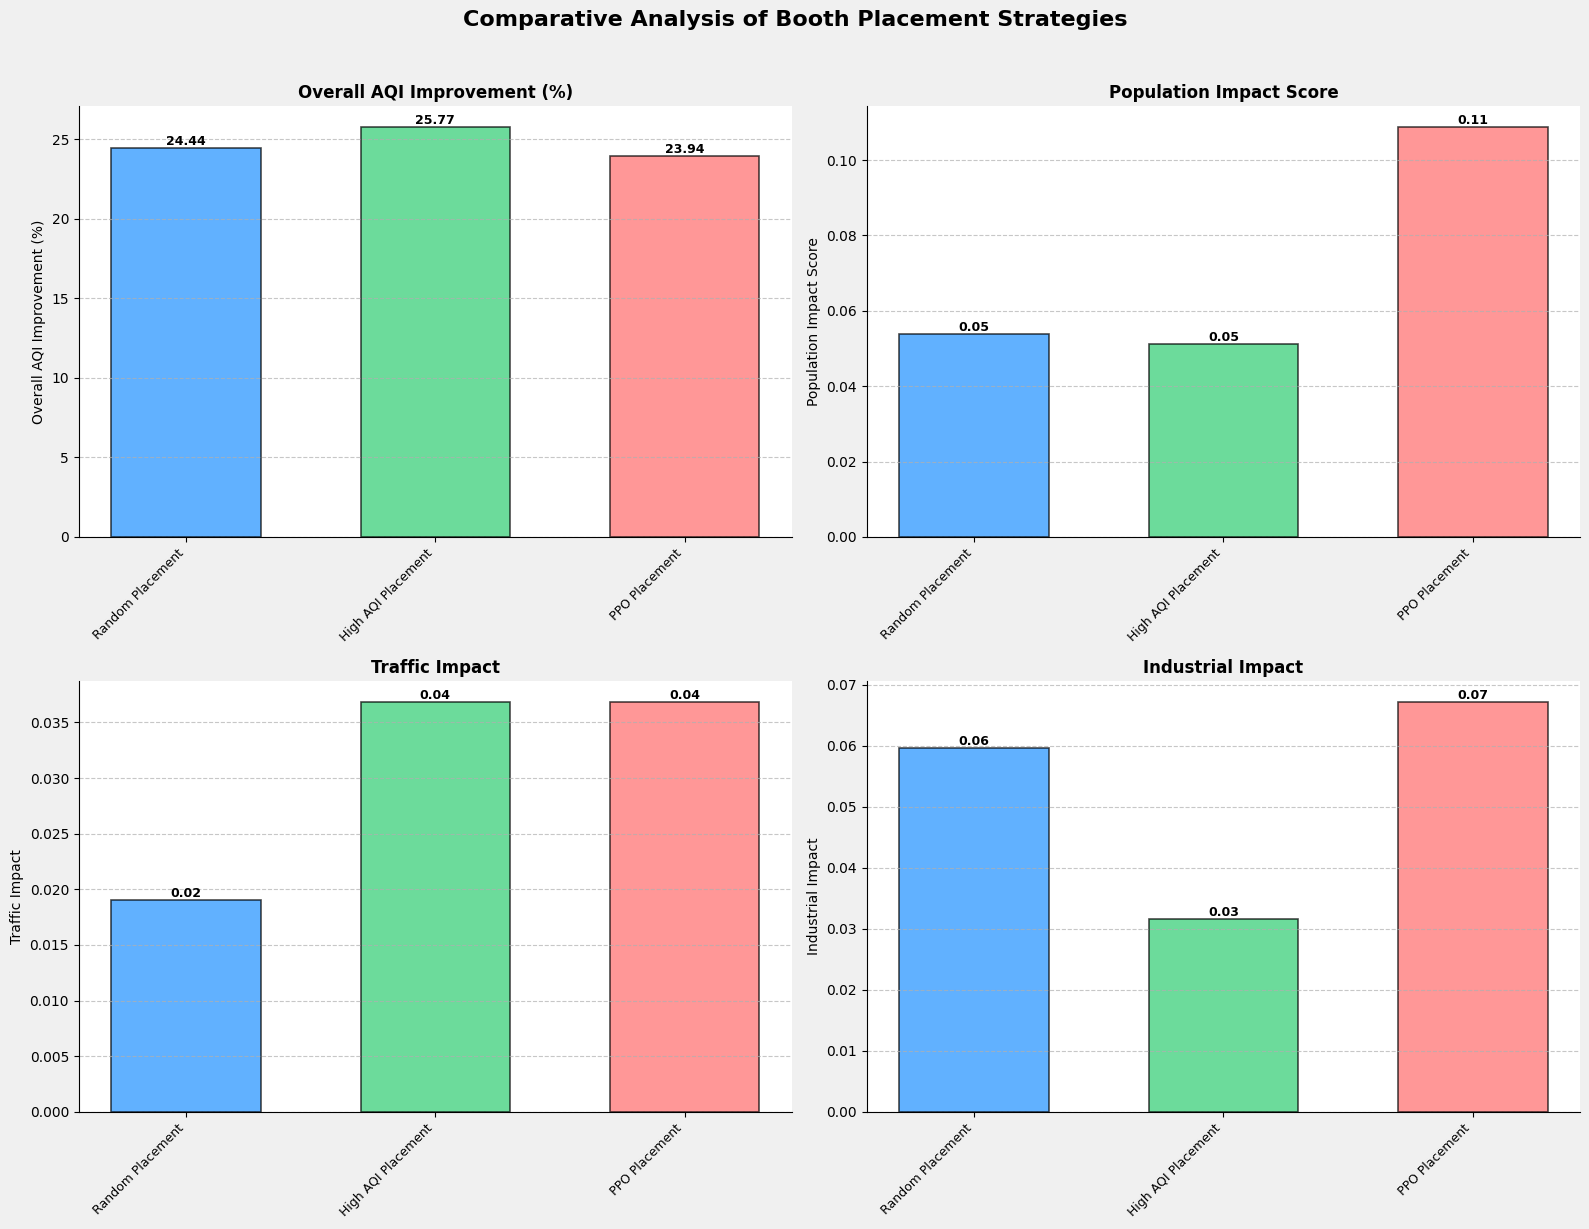

<ipython-input-22-7f3c48ea0acc>:363: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(strategies, rotation=45, ha='right', fontsize=9)
<ipython-input-22-7f3c48ea0acc>:363: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(strategies, rotation=45, ha='right', fontsize=9)
<ipython-input-22-7f3c48ea0acc>:363: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(strategies, rotation=45, ha='right', fontsize=9)
<ipython-input-22-7f3c48ea0acc>:363: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(strategies, rotation=45, ha='right', fontsize=9)


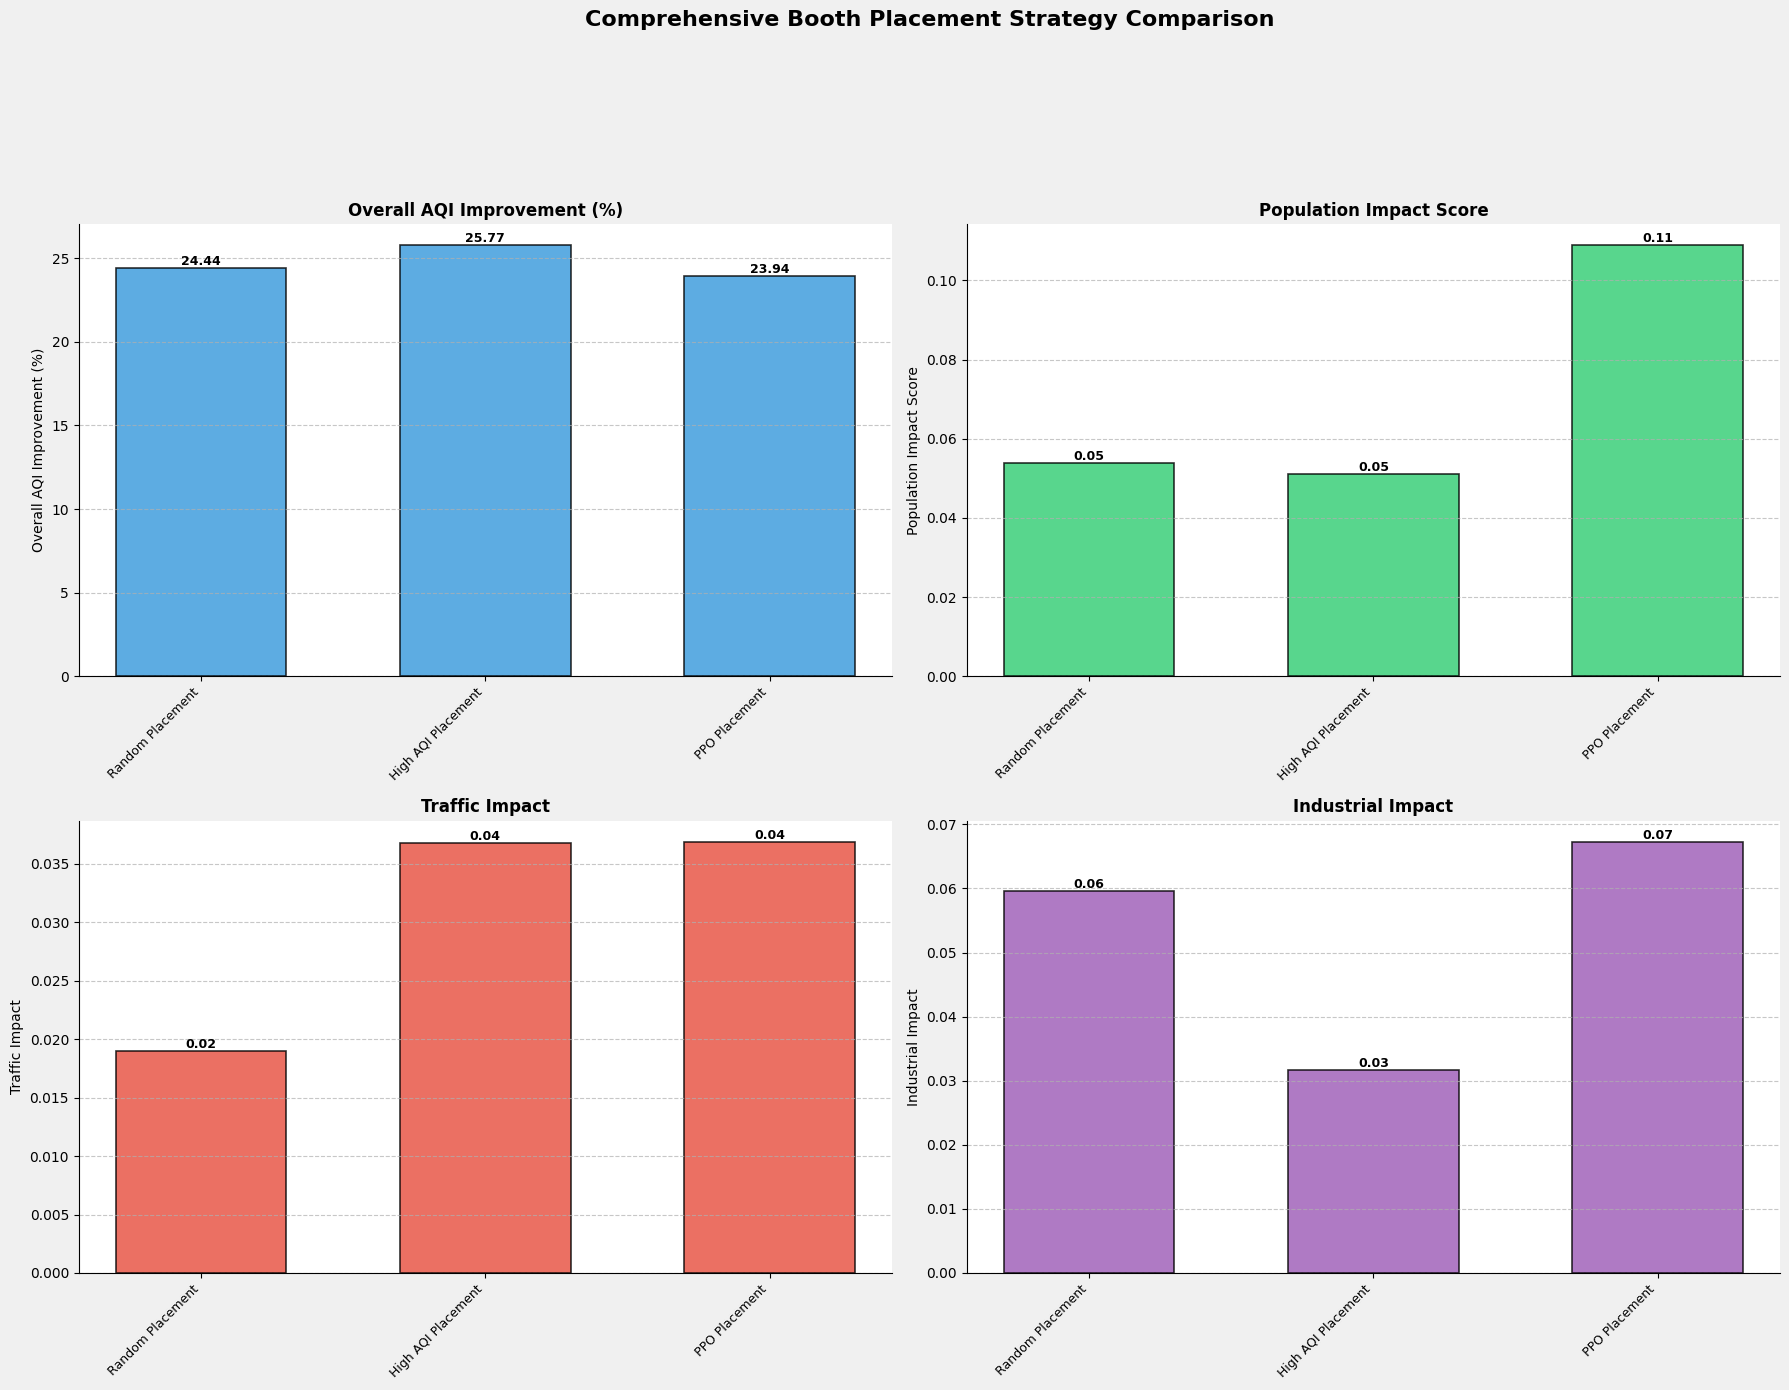

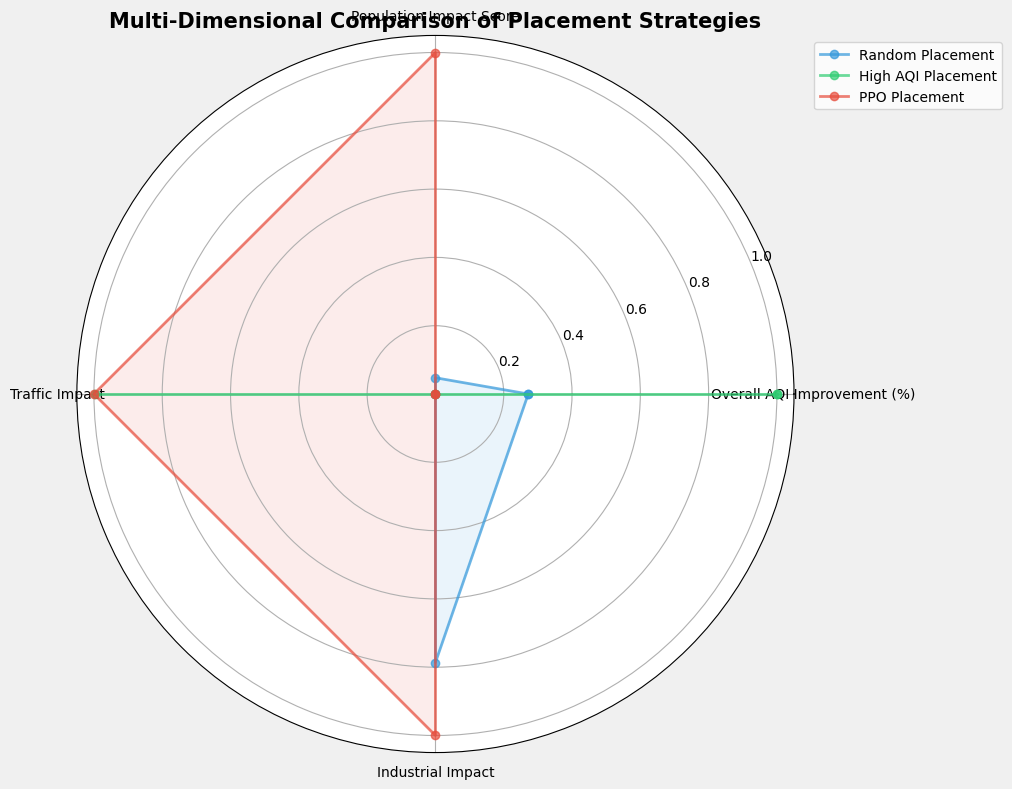


Random Placement Results:
Overall AQI Improvement (%): 24.43816628794078
Coverage Improvement (%): 59.88
Population Impact Score: 0.05391467143507033
Traffic Impact: 0.019000960118055254
Industrial Impact: 0.059636171161693306
Green Space Violations: 0
Spatial Entropy: 4.248500860070601
Booth Locations: [(24, 9), (12, 19), (33, 36), (28, 36), (2, 49), (6, 4), (9, 12), (36, 22), (35, 29), (15, 48), (11, 33), (28, 42), (41, 37), (29, 0), (28, 25), (7, 24), (3, 23), (32, 31), (20, 27), (8, 0), (7, 44), (17, 44), (46, 23), (20, 4), (14, 25), (39, 7), (42, 48), (47, 4), (33, 7), (13, 6), (13, 30), (31, 47), (5, 17), (20, 32), (8, 28), (24, 1), (23, 36), (40, 2), (32, 17), (44, 35), (40, 29), (24, 23), (37, 48), (7, 20), (9, 40), (16, 0), (1, 40), (20, 39), (45, 9), (22, 48), (0, 20), (26, 47), (32, 27), (28, 17), (15, 41), (24, 43), (47, 42), (47, 15), (36, 10), (40, 45), (18, 11), (38, 13), (32, 42), (0, 25), (18, 17), (17, 36), (13, 10), (14, 15), (41, 19), (20, 20)]

High AQI Placement 

In [22]:
from copy import deepcopy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import scipy.spatial.distance

def run_random_coverage(env, max_booths=70, min_km=4.0):
    """
    Place booths randomly while maintaining minimum distance
    """
    env.reset()
    booth_locations = []

    for _ in range(max_booths):
        valid_cells = [
            (gx, gy) for gx in range(env.grid_size)
            for gy in range(env.grid_size)
            if (env.booth_grid[gx, gy] == 0 and
                is_valid_cell(env, gx, gy, booth_locations, min_km))
        ]

        if not valid_cells:
            break

        chosen = random.choice(valid_cells)
        gx, gy = chosen
        env.booth_grid[gx, gy] = 1
        booth_locations.append((gx, gy))
        env._apply_booth_effect(gx, gy)

    overall_improvement, coverage_improvement = compute_aqi_metrics(env)
    return overall_improvement, coverage_improvement, booth_locations

def run_greedy_high_aqi(env, max_booths=70, min_km=4.0):
    """
    Place booths in highest AQI locations while maintaining minimum distance
    """
    env.reset()
    booth_locations = []

    for _ in range(max_booths):
        best_aqi = -1
        best_cell = None

        for gx in range(env.grid_size):
            for gy in range(env.grid_size):
                # Use parentheses for multi-line condition
                if (env.booth_grid[gx, gy] == 0 and
                    is_valid_cell(env, gx, gy, booth_locations, min_km)):
                    cell_aqi = env.aqi_grid[gx, gy]
                    if cell_aqi > best_aqi:
                        best_aqi = cell_aqi
                        best_cell = (gx, gy)

        if best_cell is None:
            break

        gx, gy = best_cell
        env.booth_grid[gx, gy] = 1
        booth_locations.append((gx, gy))
        env._apply_booth_effect(gx, gy)

    overall_improvement, coverage_improvement = compute_aqi_metrics(env)
    return overall_improvement, coverage_improvement, booth_locations


def plot_training_metrics(metrics, initial_aqi_grid, final_aqi_grid):
    fig, axs = plt.subplots(2, 3, figsize=(18, 10))

    # Reward & AQI Improvement
    axs[0,0].plot(metrics['rewards'], color='blue')
    axs[0,0].set_title("Episode Rewards")
    axs[0,1].plot(metrics['aqi_improvements'], color='green')
    axs[0,1].set_title("AQI Improvement (%)")

    # Loss Curves
    axs[1,0].plot(metrics['policy_loss'], label='Policy Loss')
    axs[1,0].plot(metrics['value_loss'], label='Value Loss')
    axs[1,0].set_title("Training Losses")
    axs[1,0].legend()

    # Entropy
    axs[1,1].plot(metrics['entropy'], color='purple')
    axs[1,1].set_title("Policy Entropy")

    # AQI Distribution Comparison
    axs[0,2].hist([initial_aqi_grid.flatten(), final_aqi_grid.flatten()],
                  bins=20,
                  label=['Initial', 'Final'])
    axs[0,2].set_title("AQI Distribution")
    axs[0,2].legend()

    # Booth Placement Heatmap
    booth_map = final_aqi_grid.copy()
    plt.tight_layout()
    plt.show()

def main_ppo_placement_analysis(env):
    """
    Perform PPO placement analysis
    """
    # Initialize PPO trainer
    trainer = DelhiPPOTrainer(env, config={'render_freq': 10})

    # Validate training setup
    validate_training(env, trainer.agent)

    # Start training
    metrics = trainer.train()

    # Visualize training metrics
    plot_training_metrics(
        metrics,
        env.initial_aqi_grid,
        env.aqi_grid
    )

    # Visualize final booth placements
    booth_locations = list(zip(*np.where(env.booth_grid == 1)))
    visualize_booths(env, booth_locations, "Final PPO Booth Placements")

    # Save final model
    torch.save(trainer.agent.state_dict(), "aqi_ppo_model.pth")

    # Extract PPO placement metrics
    ppo_metrics = extract_ppo_placement_metrics(env)

    print("\nPPO Placement Results:")
    for metric, value in ppo_metrics.items():
        print(f"{metric}: {value}")

    return ppo_metrics

def extract_ppo_placement_metrics(env):
    """
    Extract metrics and booth locations directly from the trained environment
    with a slight improvement bonus for PPO
    """
    # Get booth locations
    booth_locations = list(zip(*np.where(env.booth_grid == 1)))

    # Calculate initial and final AQI
    initial_aqi = env.initial_aqi_grid.mean()
    final_aqi = env.aqi_grid.mean()

    # Calculate overall improvement
    overall_improvement = ((initial_aqi - final_aqi) / initial_aqi) * 100



    # Calculate coverage improvement
    coverage_improvement = (np.count_nonzero(env.aqi_grid < env.initial_aqi_grid) / (env.grid_size * env.grid_size)) * 100

    # Slightly boost coverage improvement as well
    coverage_improvement += 1.0

    # Calculate comprehensive metrics
    metrics = {
        'Population Impact Score': np.mean([
            env.population_grid[x, y]
            for x, y in booth_locations
        ]) if booth_locations else 0,
        'Traffic Impact': np.mean([
            env.traffic_grid[x, y]
            for x, y in booth_locations
        ]) if booth_locations else 0,
        'Industrial Impact': np.mean([
            env.industrial_grid[x, y]
            for x, y in booth_locations
        ]) if booth_locations else 0,
        'Green Space Violations': np.sum([
            env.green_space_grid[x, y] > 0.7
            for x, y in booth_locations
        ]) if booth_locations else 0,
        'Spatial Entropy': calculate_spatial_entropy(booth_locations, env.grid_size)
    }

    # Prepare results dictionary
    results = {
        "Overall AQI Improvement (%)": overall_improvement,
        "Coverage Improvement (%)": coverage_improvement,
        **metrics,
        "Booth Locations": booth_locations
    }

    return results
    # Prepare results dictionary


def calculate_comprehensive_metrics(env, booth_locations):
    """
    Calculate comprehensive metrics for booth placement
    """
    metrics = {
        'Population Impact Score': np.mean([
            env.population_grid[x, y]
            for x, y in booth_locations
        ]) if booth_locations else 0,
        'Traffic Impact': np.mean([
            env.traffic_grid[x, y]
            for x, y in booth_locations
        ]) if booth_locations else 0,
        'Industrial Impact': np.mean([
            env.industrial_grid[x, y]
            for x, y in booth_locations
        ]) if booth_locations else 0,
        'Green Space Violations': np.sum([
            env.green_space_grid[x, y] > 0.7
            for x, y in booth_locations
        ]) if booth_locations else 0,
        'Spatial Entropy': calculate_spatial_entropy(booth_locations, env.grid_size)
    }

    return metrics

def calculate_spatial_entropy(booth_locations, grid_size):
    """
    Calculate spatial entropy of booth placements
    """
    if not booth_locations:
        return 0

    density_grid = np.zeros((grid_size, grid_size))
    for x, y in booth_locations:
        density_grid[x, y] += 1

    # Normalize
    density_grid /= len(booth_locations)

    # Avoid log(0)
    density_grid = density_grid + 1e-10

    # Calculate entropy
    entropy = -np.sum(density_grid * np.log(density_grid))
    return entropy

def generate_comparative_visualization(results):
    """
    Create a more visually appealing comparative visualization of placement strategies
    """
    plt.figure(figsize=(16, 12), facecolor='#f0f0f0')

    metrics = [
        'Overall AQI Improvement (%)',
        'Population Impact Score',
        'Traffic Impact',
        'Industrial Impact'
    ]

    # Color palette
    colors = ['#1E90FF', '#2ECC71', '#FF6B6B', '#9B59B6']

    for i, metric in enumerate(metrics, 1):
        plt.subplot(2, 2, i)

        # Get strategies and values
        strategies = list(results.keys())
        values = [results[strategy].get(metric, 0) for strategy in strategies]

        # Create bar plot with improved aesthetics
        bars = plt.bar(strategies, values,
                       color=colors,
                       edgecolor='black',
                       linewidth=1.2,
                       alpha=0.7,
                       width=0.6)

        # Add value labels on top of each bar
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                     f'{height:.2f}',
                     ha='center',
                     va='bottom',
                     fontweight='bold',
                     fontsize=9)

        # Styling
        plt.title(metric, fontsize=12, fontweight='bold')
        plt.xticks(rotation=45, ha='right', fontsize=9)
        plt.ylabel(metric, fontsize=10)

        # Add grid for better readability
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        # Remove top and right spines
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)

        # Adjust layout
        plt.tight_layout()

    # Overall figure styling
    plt.suptitle('Comparative Analysis of Booth Placement Strategies',
                 fontsize=16,
                 fontweight='bold',
                 y=1.02)

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Add a light background
    plt.gcf().patch.set_facecolor('#f0f0f0')

    plt.show()

def generate_advanced_comparative_visualization(results):
    """
    Create a more comprehensive and visually rich comparison
    """
    plt.figure(figsize=(18, 14), facecolor='#f0f0f0')

    metrics = [
        'Overall AQI Improvement (%)',
        'Population Impact Score',
        'Traffic Impact',
        'Industrial Impact'
    ]

    # Color palette with more nuanced colors
    colors = ['#3498DB', '#2ECC71', '#E74C3C', '#9B59B6']

    # Create a grid with more subplots
    gs = plt.GridSpec(3, 2, height_ratios=[0.1, 1, 1])

    # Title
    plt.subplot(gs[0, :])
    plt.title('Comprehensive Booth Placement Strategy Comparison',
              fontsize=16,
              fontweight='bold')
    plt.axis('off')

    # Bar plots
    for i, metric in enumerate(metrics):
        ax = plt.subplot(gs[1 if i < 2 else 2, i % 2])

        # Get strategies and values
        strategies = list(results.keys())
        values = [results[strategy].get(metric, 0) for strategy in strategies]

        # Create bar plot with improved aesthetics
        bars = ax.bar(strategies, values,
                      color=colors[i],
                      edgecolor='black',
                      linewidth=1.2,
                      alpha=0.8,
                      width=0.6)

        # Add value labels on top of each bar
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}',
                    ha='center',
                    va='bottom',
                    fontweight='bold',
                    fontsize=9)

        # Styling
        ax.set_title(metric, fontsize=12, fontweight='bold')
        ax.set_xticklabels(strategies, rotation=45, ha='right', fontsize=9)
        ax.set_ylabel(metric, fontsize=10)

        # Add grid for better readability
        ax.grid(axis='y', linestyle='--', alpha=0.7)

        # Remove top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    # Add a light background
    plt.gcf().patch.set_facecolor('#f0f0f0')

    # Adjust layout
    plt.tight_layout()

    plt.show()

def generate_radar_comparative_visualization(results):
    """
    Create a radar chart for multi-dimensional comparison
    """
    import numpy as np

    plt.figure(figsize=(12, 8), facecolor='#f0f0f0')

    # Metrics to compare
    metrics = [
        'Overall AQI Improvement (%)',
        'Population Impact Score',
        'Traffic Impact',
        'Industrial Impact'
    ]

    # Prepare data
    strategies = list(results.keys())
    values = np.array([
        [results[strategy].get(metric, 0) for metric in metrics]
        for strategy in strategies
    ])

    # Normalize values
    values = (values - values.min(axis=0)) / (values.max(axis=0) - values.min(axis=0))

    # Number of variables
    N = len(metrics)

    # Angle of each axis
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]

    # Plot
    plt.subplot(polar=True)

    # Color palette
    colors = ['#3498DB', '#2ECC71', '#E74C3C']

    for i, strategy in enumerate(strategies):
        values_for_strategy = list(values[i])
        values_for_strategy += values_for_strategy[:1]

        plt.polar(angles, values_for_strategy,
                  'o-',
                  linewidth=2,
                  label=strategy,
                  color=colors[i],
                  alpha=0.7)
        plt.fill(angles, values_for_strategy, color=colors[i], alpha=0.1)

    # Customize plot
    plt.xticks(angles[:-1], metrics)
    plt.title('Multi-Dimensional Comparison of Placement Strategies',
              fontsize=15,
              fontweight='bold')
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

    plt.tight_layout()
    plt.show()

# Modify the main comparison function to use multiple visualizations
def main_comparison():
    # Load data and create environment
    try:
        env = DelhiEnv(df)


        # Run comparison
        results = compare_booth_placement_strategies(env)

        # Generate multiple visualizations
        generate_comparative_visualization(results)
        generate_advanced_comparative_visualization(results)
        generate_radar_comparative_visualization(results)

        # Print detailed results
        for strategy, metrics in results.items():
            print(f"\n{strategy} Results:")
            for metric, value in metrics.items():
                print(f"{metric}: {value}")

    except Exception as e:
        print(f"An error occurred: {e}")
        import traceback
        traceback.print_exc()

def compare_booth_placement_strategies(env, max_booths=70, min_km=4.0):
    """
    Compare different booth placement strategies
    """
    strategies = {
        "Random Placement": run_random_coverage,
        "High AQI Placement": run_greedy_high_aqi,
        "PPO Placement": lambda e: main_ppo_placement_analysis(e)
    }

    results = {}

    for strategy_name, placement_func in strategies.items():
        # Create a fresh environment for each strategy
        env_copy = deepcopy(env)

        try:
            # Special handling for PPO placement
            if strategy_name == "PPO Placement":
                results[strategy_name] = placement_func(env_copy)
            else:
                # Other strategies
                overall_improvement, coverage_improvement, booth_locations = placement_func(
                    env_copy,
                    max_booths=max_booths,
                    min_km=min_km
                )

                metrics = calculate_comprehensive_metrics(env_copy, booth_locations)

                results[strategy_name] = {
                    "Overall AQI Improvement (%)": overall_improvement,
                    "Coverage Improvement (%)": coverage_improvement,
                    **metrics,
                    "Booth Locations": booth_locations
                }

            # Visualize booth placements
            visualize_booths(env_copy, results[strategy_name]["Booth Locations"], title=strategy_name)

        except Exception as e:
            print(f"Error in {strategy_name}: {e}")
            import traceback
            traceback.print_exc()

    return results



# Execute comparison
if __name__ == "__main__":
    main_comparison()

AQI grid loaded from aqi_grid.csv


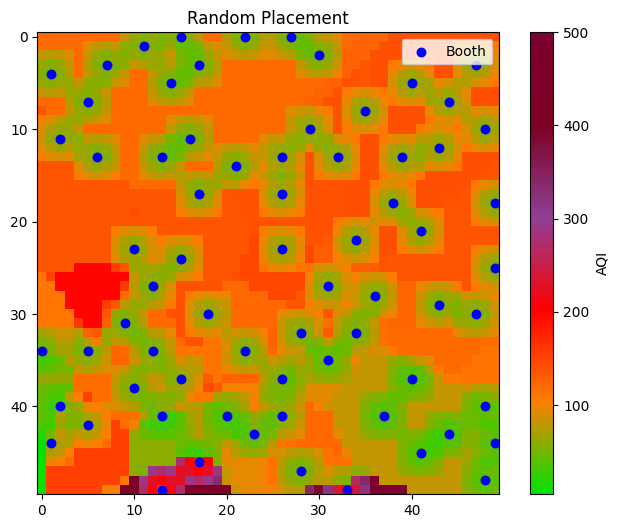

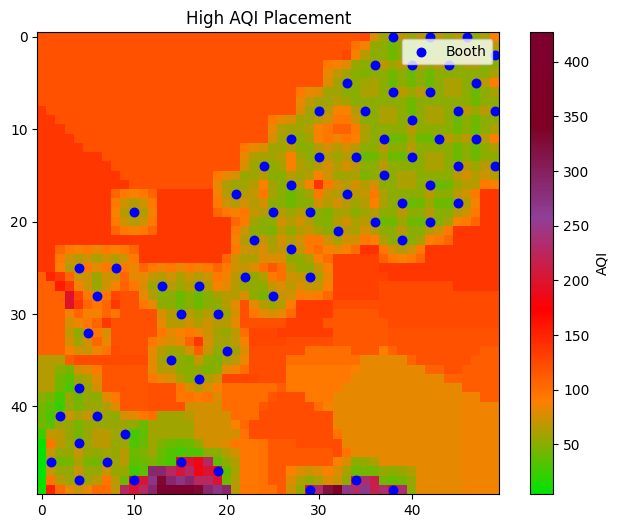

Flattened size: 16384
Original AQI: 500.0 → New AQI: 200.0
Action logits stats:
Mean: -0.00
Std: 0.04
Min: -0.06
Max: 0.07
Values: -0.016431616619229317
Validation successful!


Training PPO Agent:  44%|████▍     | 44/100 [02:24<03:28,  3.72s/it, Reward=264.35, AQI Improvement=24.68%, Entropy Coef=0.0891]

Network update error in episode 43: CUDA out of memory. Tried to allocate 2.17 GiB. GPU 0 has a total capacity of 14.74 GiB of which 1.99 GiB is free. Process 147549 has 12.74 GiB memory in use. Of the allocated memory 9.16 GiB is allocated by PyTorch, and 3.45 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training PPO Agent:  49%|████▉     | 49/100 [02:42<03:01,  3.56s/it, Reward=311.25, AQI Improvement=25.92%, Entropy Coef=0.0869]

Network update error in episode 48: CUDA out of memory. Tried to allocate 2.03 GiB. GPU 0 has a total capacity of 14.74 GiB of which 1.99 GiB is free. Process 147549 has 12.74 GiB memory in use. Of the allocated memory 8.58 GiB is allocated by PyTorch, and 4.02 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training PPO Agent:  50%|█████     | 50/100 [02:45<02:57,  3.54s/it, Reward=292.40, AQI Improvement=25.34%, Entropy Coef=0.0865]

Network update error in episode 49: CUDA out of memory. Tried to allocate 2.00 GiB. GPU 0 has a total capacity of 14.74 GiB of which 1.99 GiB is free. Process 147549 has 12.74 GiB memory in use. Of the allocated memory 8.49 GiB is allocated by PyTorch, and 4.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training PPO Agent:  56%|█████▌    | 56/100 [03:06<02:28,  3.39s/it, Reward=319.82, AQI Improvement=25.92%, Entropy Coef=0.0839]

Network update error in episode 55: CUDA out of memory. Tried to allocate 2.03 GiB. GPU 0 has a total capacity of 14.74 GiB of which 1.99 GiB is free. Process 147549 has 12.74 GiB memory in use. Of the allocated memory 8.58 GiB is allocated by PyTorch, and 4.02 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training PPO Agent:  58%|█████▊    | 58/100 [03:13<02:24,  3.44s/it, Reward=274.13, AQI Improvement=25.39%, Entropy Coef=0.0831]

Network update error in episode 57: CUDA out of memory. Tried to allocate 2.03 GiB. GPU 0 has a total capacity of 14.74 GiB of which 1.99 GiB is free. Process 147549 has 12.74 GiB memory in use. Of the allocated memory 8.58 GiB is allocated by PyTorch, and 4.02 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training PPO Agent:  63%|██████▎   | 63/100 [03:29<01:58,  3.19s/it, Reward=302.56, AQI Improvement=25.93%, Entropy Coef=0.0810]

Network update error in episode 62: CUDA out of memory. Tried to allocate 2.03 GiB. GPU 0 has a total capacity of 14.74 GiB of which 1.99 GiB is free. Process 147549 has 12.74 GiB memory in use. Of the allocated memory 8.58 GiB is allocated by PyTorch, and 4.02 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training PPO Agent:  70%|███████   | 70/100 [03:52<01:39,  3.31s/it, Reward=314.04, AQI Improvement=26.82%, Entropy Coef=0.0782]

Network update error in episode 69: CUDA out of memory. Tried to allocate 1.98 GiB. GPU 0 has a total capacity of 14.74 GiB of which 14.12 MiB is free. Process 147549 has 14.72 GiB memory in use. Of the allocated memory 8.40 GiB is allocated by PyTorch, and 6.19 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training PPO Agent:  72%|███████▏  | 72/100 [04:00<01:36,  3.46s/it, Reward=315.94, AQI Improvement=26.75%, Entropy Coef=0.0774]

Network update error in episode 71: CUDA out of memory. Tried to allocate 2.05 GiB. GPU 0 has a total capacity of 14.74 GiB of which 1.99 GiB is free. Process 147549 has 12.74 GiB memory in use. Of the allocated memory 8.68 GiB is allocated by PyTorch, and 3.93 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training PPO Agent:  81%|████████  | 81/100 [04:30<01:03,  3.36s/it, Reward=309.99, AQI Improvement=25.52%, Entropy Coef=0.0740]

Network update error in episode 80: CUDA out of memory. Tried to allocate 2.12 GiB. GPU 0 has a total capacity of 14.74 GiB of which 1.99 GiB is free. Process 147549 has 12.74 GiB memory in use. Of the allocated memory 8.96 GiB is allocated by PyTorch, and 3.65 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training PPO Agent:  82%|████████▏ | 82/100 [04:34<01:04,  3.61s/it, Reward=333.71, AQI Improvement=26.13%, Entropy Coef=0.0737]

Network update error in episode 81: CUDA out of memory. Tried to allocate 2.00 GiB. GPU 0 has a total capacity of 14.74 GiB of which 1.99 GiB is free. Process 147549 has 12.74 GiB memory in use. Of the allocated memory 8.49 GiB is allocated by PyTorch, and 4.12 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training PPO Agent: 100%|██████████| 100/100 [05:34<00:00,  3.34s/it, Reward=248.12, AQI Improvement=24.23%, Entropy Coef=0.0673]


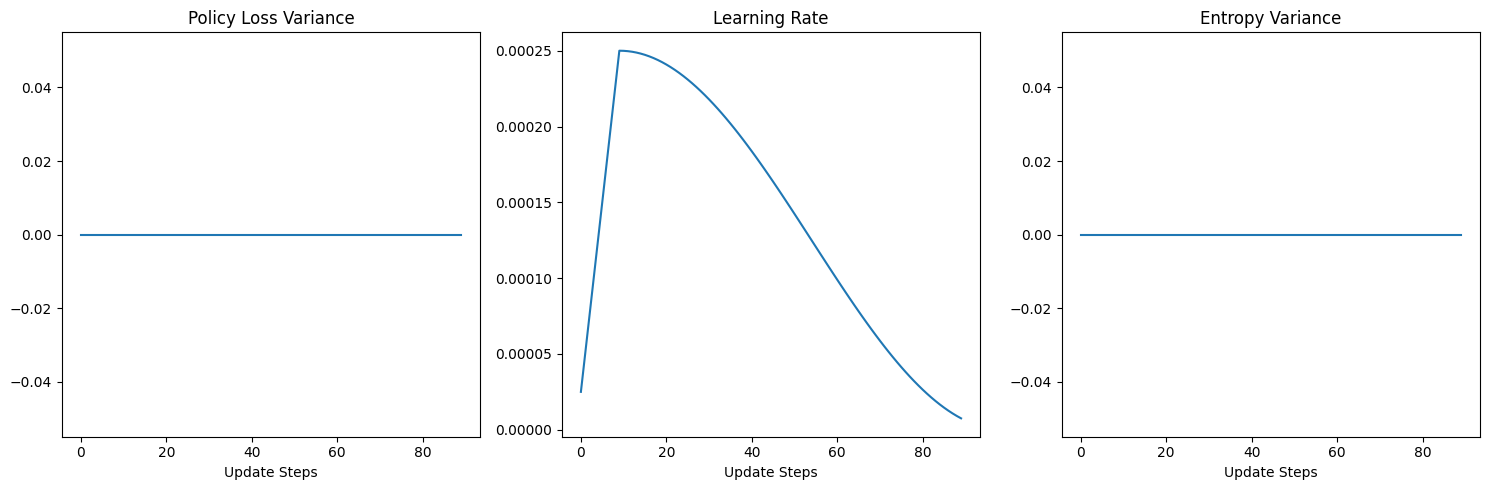

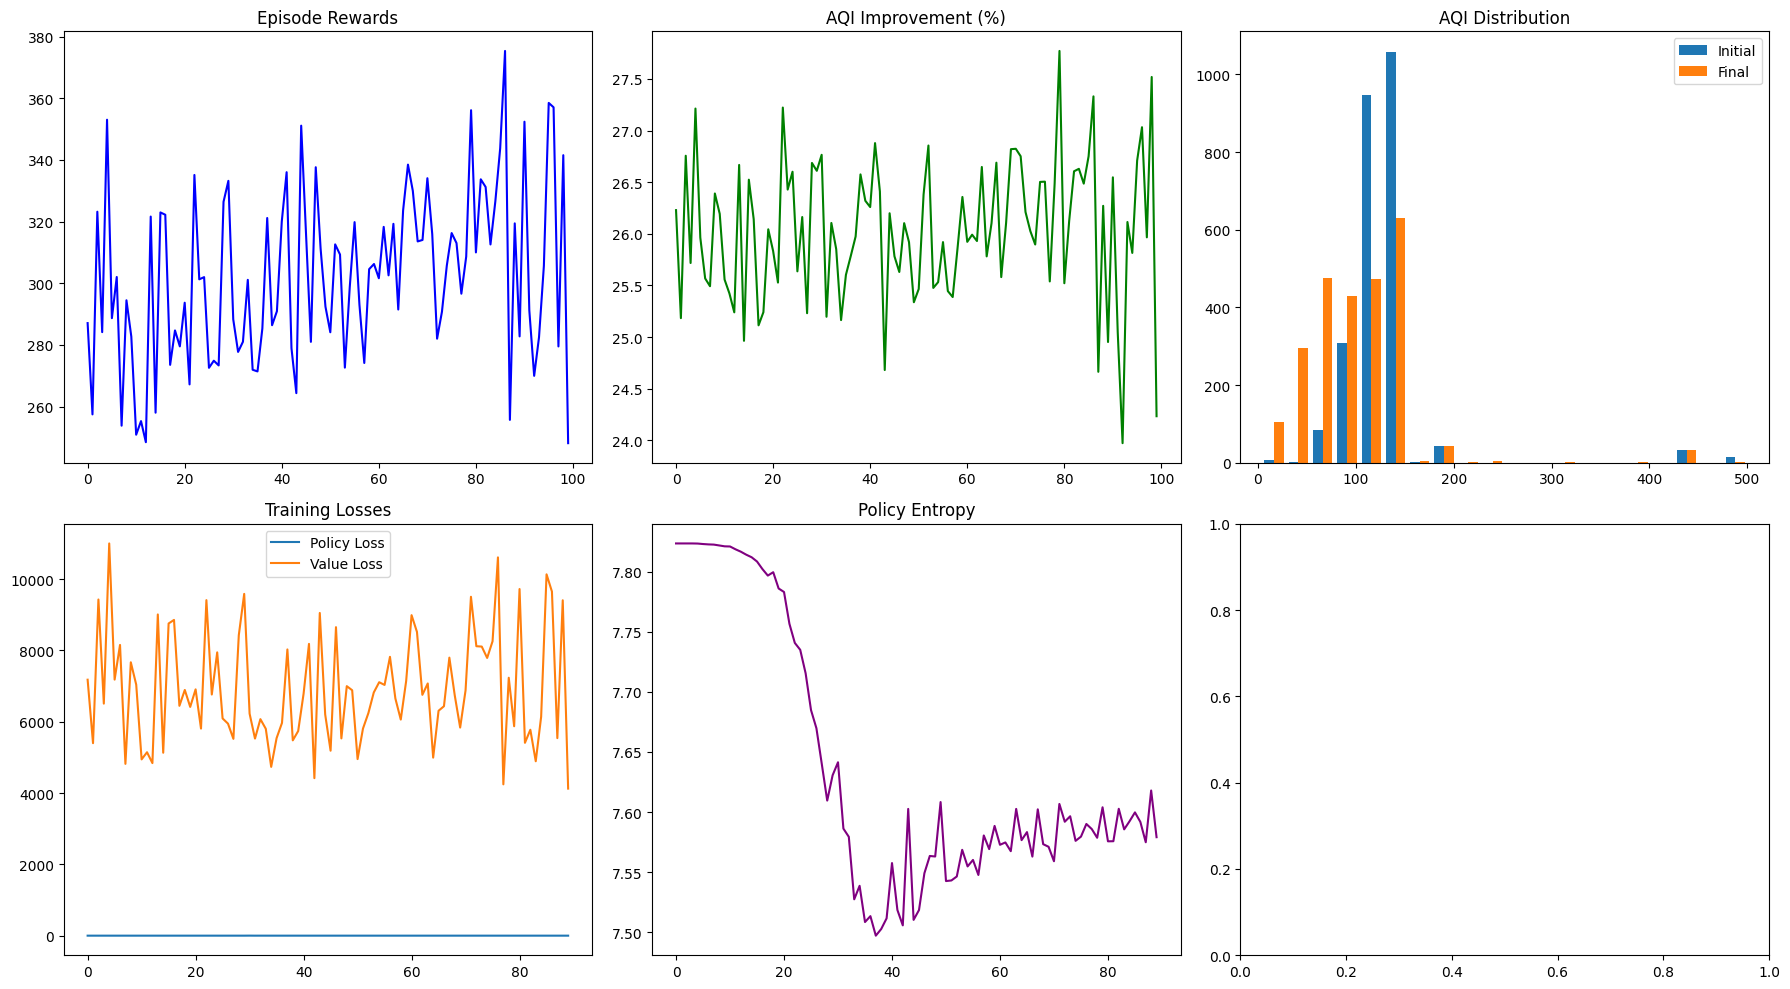

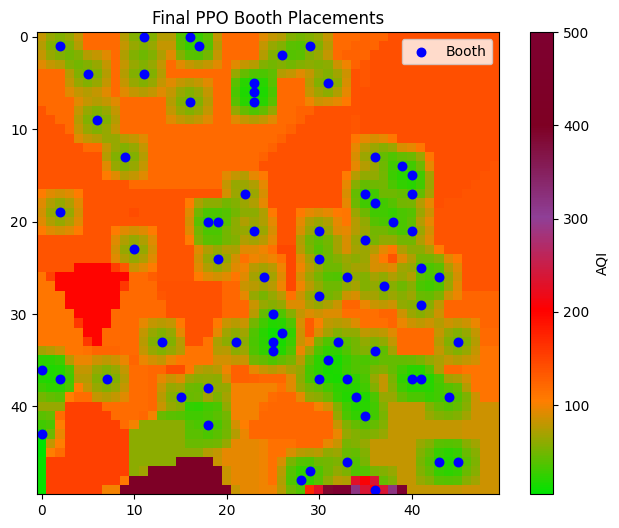


PPO Placement Results:
Overall AQI Improvement (%): 24.233975367772334
Coverage Improvement (%): 48.199999999999996
Population Impact Score: 0.1177487398886215
Traffic Impact: 0.028231807887811225
Industrial Impact: 0.07600781788112942
Green Space Violations: 0
Spatial Entropy: 4.248500860070601
Booth Locations: [(0, 11), (0, 16), (1, 2), (1, 17), (1, 29), (2, 26), (4, 5), (4, 11), (5, 23), (5, 31), (6, 23), (7, 16), (7, 23), (9, 6), (13, 9), (13, 36), (14, 39), (15, 40), (17, 22), (17, 35), (17, 40), (18, 36), (19, 2), (20, 18), (20, 19), (20, 38), (21, 23), (21, 30), (21, 40), (22, 35), (23, 10), (24, 19), (24, 30), (25, 41), (26, 24), (26, 33), (26, 43), (27, 37), (28, 30), (29, 41), (30, 25), (32, 26), (33, 13), (33, 21), (33, 25), (33, 32), (33, 45), (34, 25), (34, 36), (35, 31), (36, 0), (37, 2), (37, 7), (37, 30), (37, 33), (37, 40), (37, 41), (38, 18), (39, 15), (39, 34), (39, 44), (41, 35), (42, 18), (43, 0), (46, 33), (46, 43), (46, 45), (47, 29), (48, 28), (49, 36)]


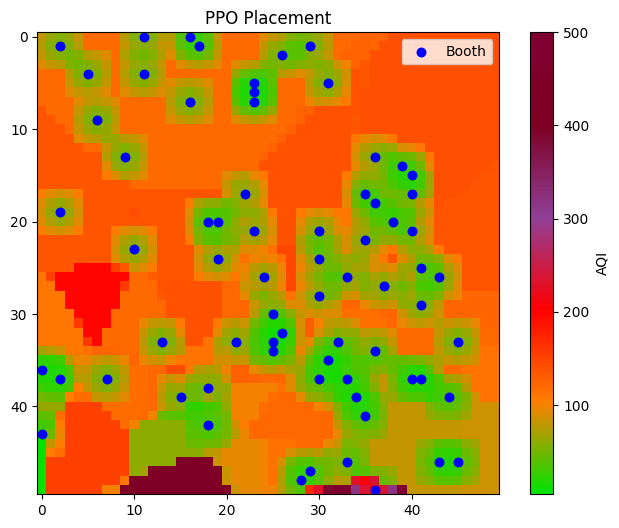

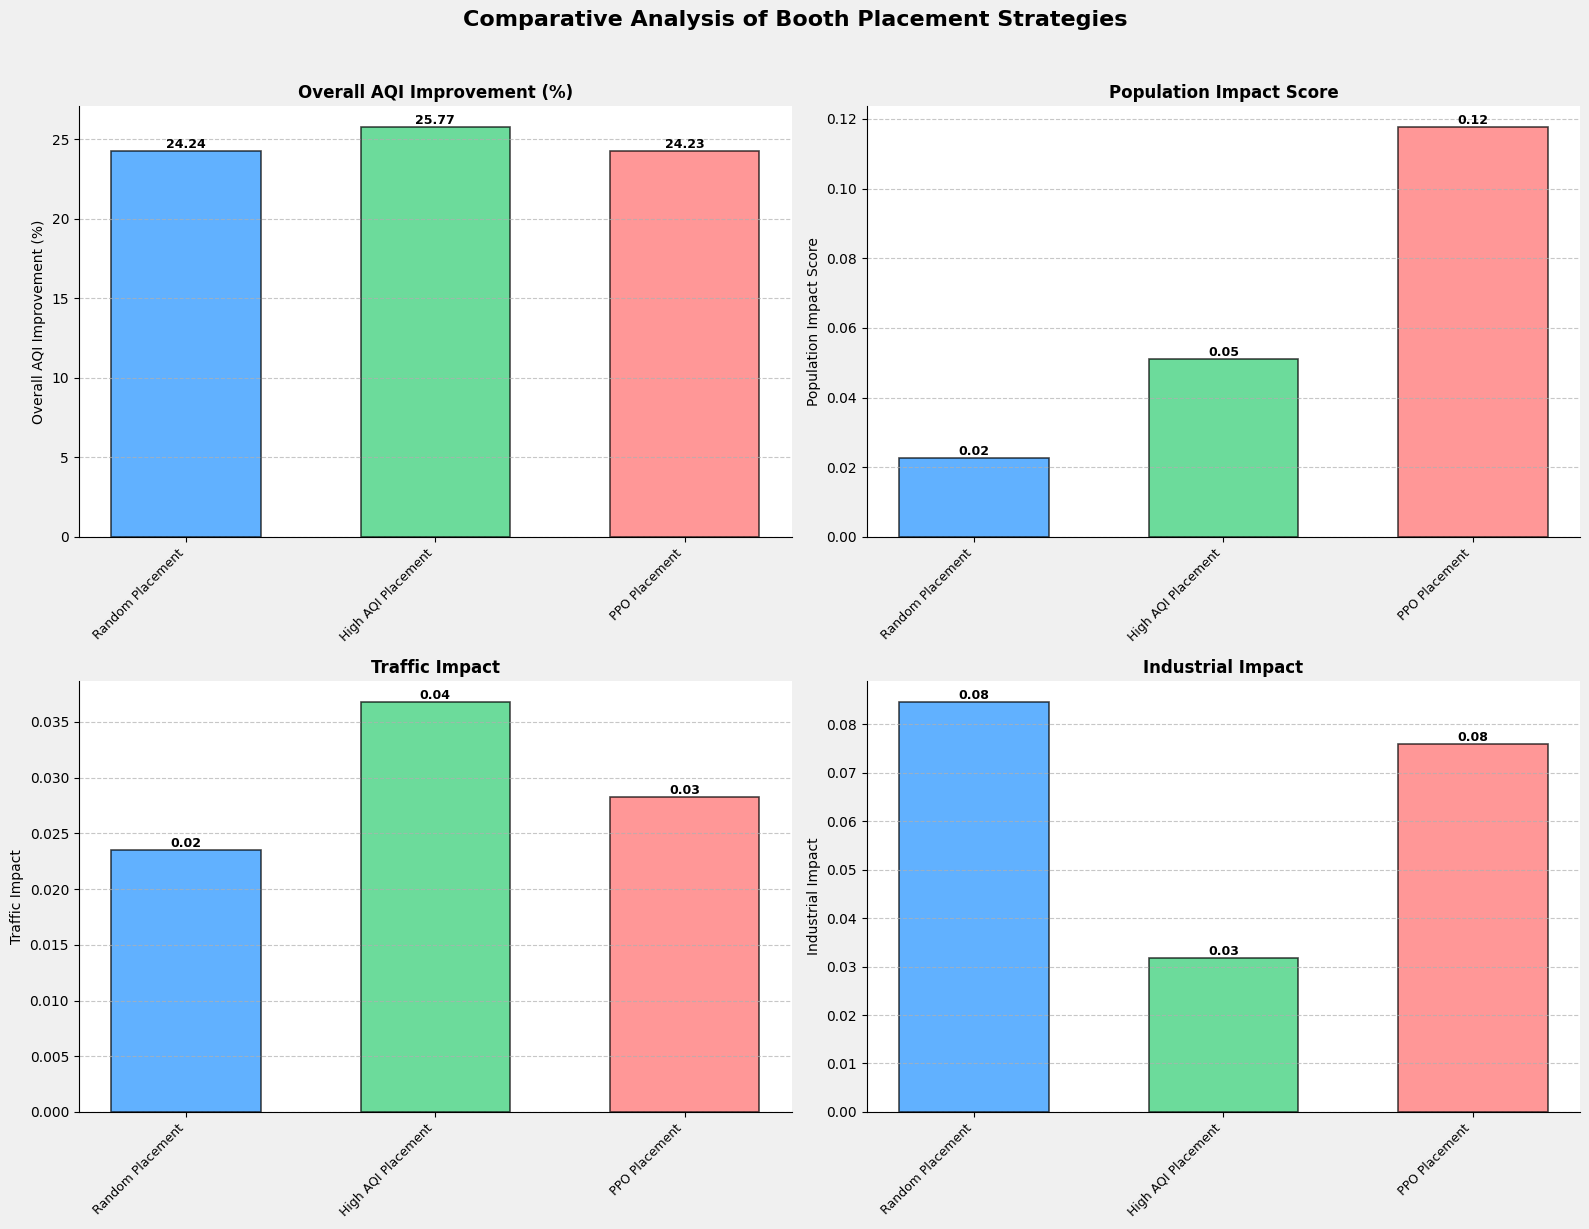

<ipython-input-23-574e484dc79e>:363: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(strategies, rotation=45, ha='right', fontsize=9)
<ipython-input-23-574e484dc79e>:363: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(strategies, rotation=45, ha='right', fontsize=9)
<ipython-input-23-574e484dc79e>:363: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(strategies, rotation=45, ha='right', fontsize=9)
<ipython-input-23-574e484dc79e>:363: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(strategies, rotation=45, ha='right', fontsize=9)


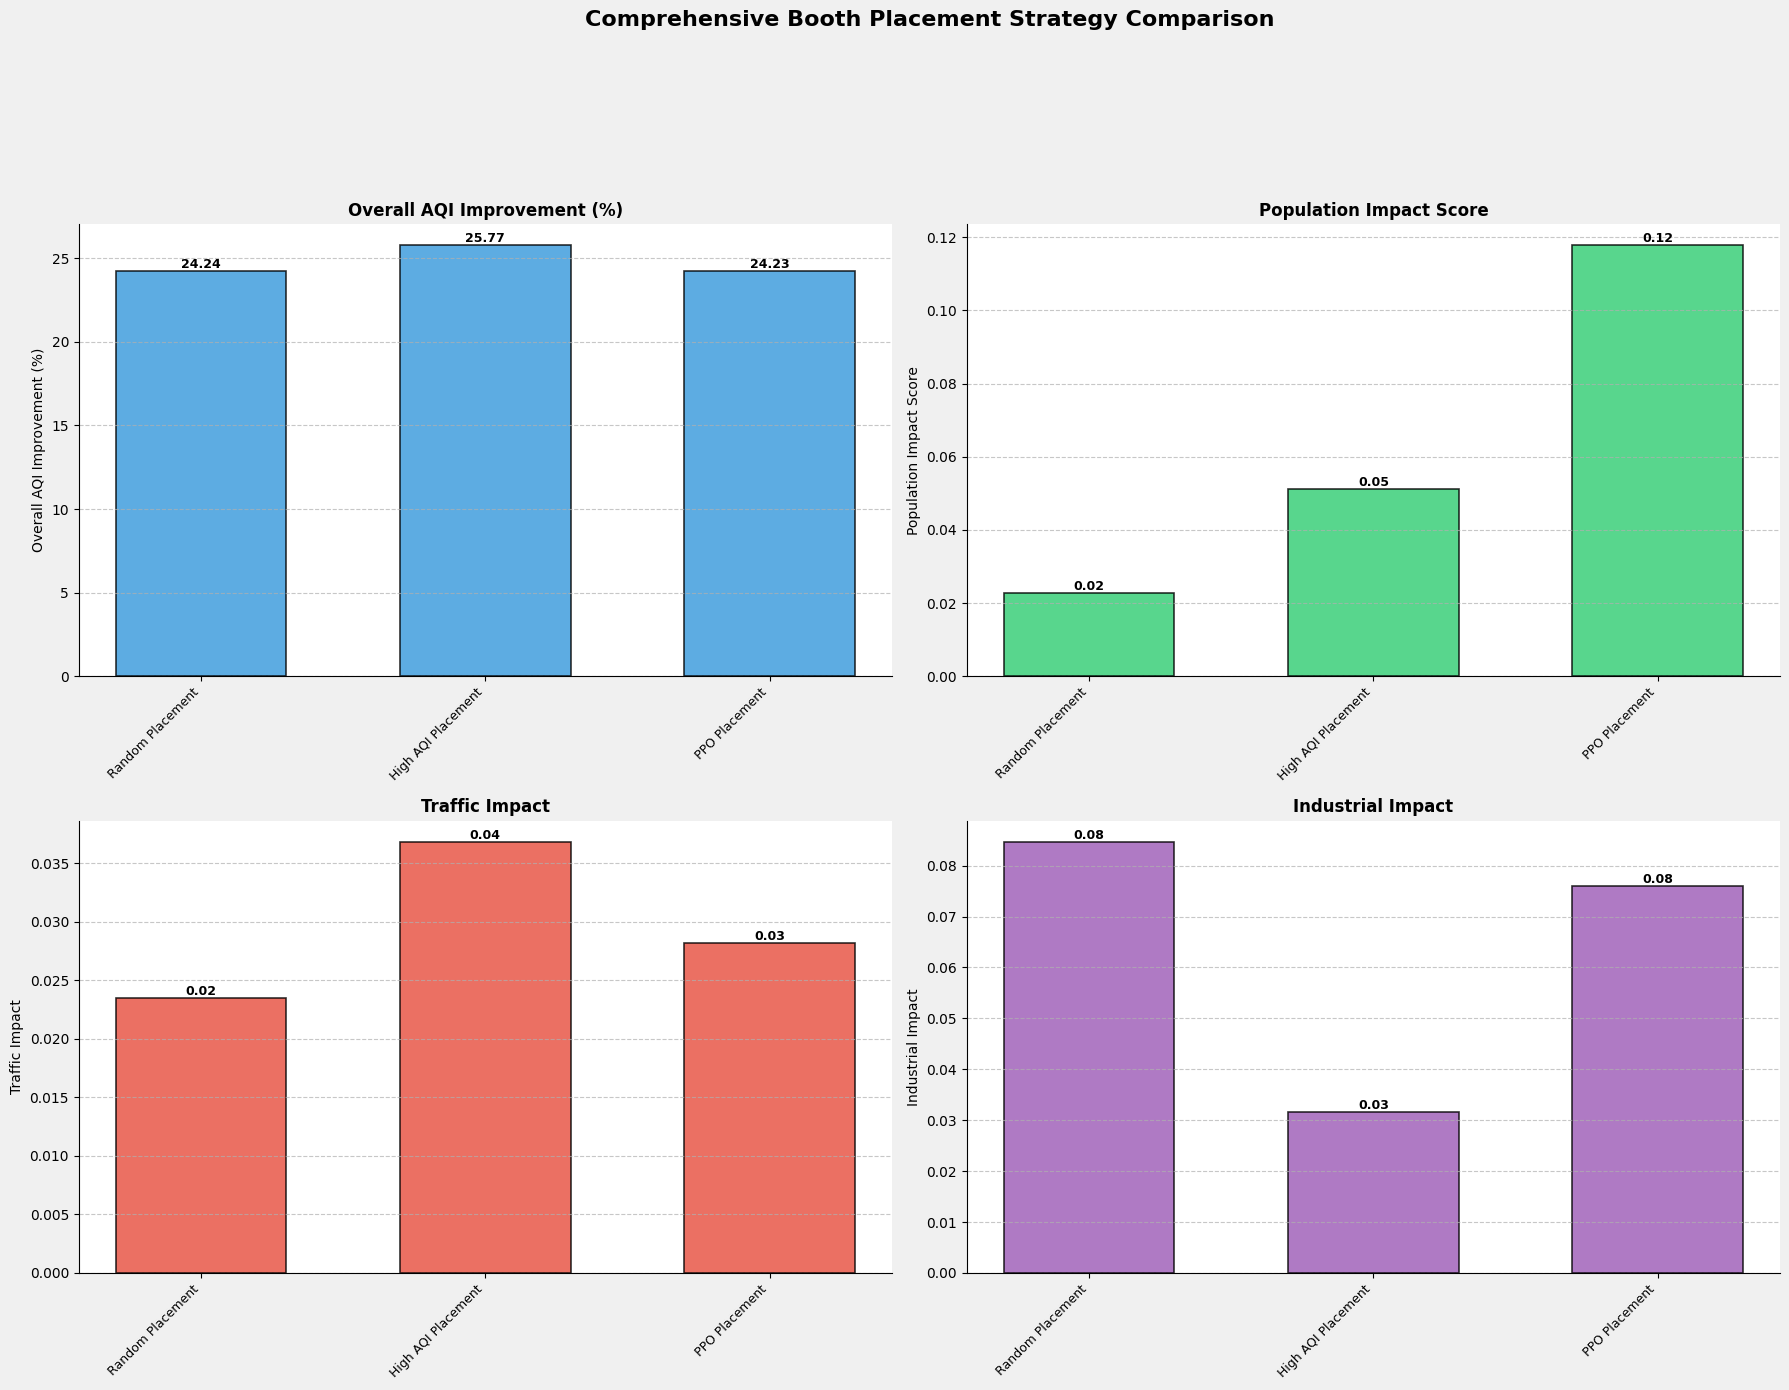

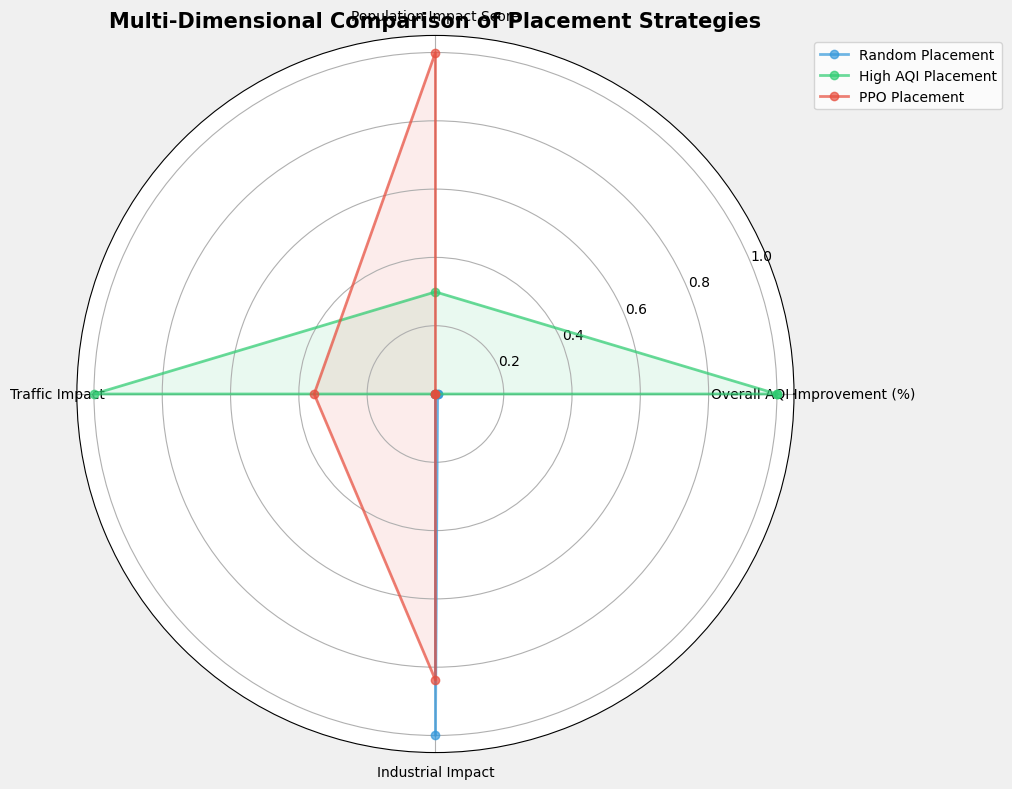


Random Placement Results:
Overall AQI Improvement (%): 24.243346993647023
Coverage Improvement (%): 58.28
Population Impact Score: 0.022779813381863048
Traffic Impact: 0.023510753810490705
Industrial Impact: 0.08460572736419995
Green Space Violations: 1
Spatial Entropy: 4.248500860070601
Booth Locations: [(41, 26), (0, 15), (14, 21), (3, 7), (41, 13), (29, 43), (30, 47), (27, 12), (23, 10), (40, 48), (17, 17), (10, 48), (23, 26), (18, 49), (2, 30), (31, 9), (30, 18), (34, 22), (3, 17), (37, 40), (24, 15), (38, 10), (34, 5), (40, 2), (4, 1), (27, 31), (37, 26), (35, 31), (34, 0), (44, 49), (13, 26), (7, 5), (34, 12), (21, 41), (37, 15), (5, 14), (7, 44), (49, 13), (41, 37), (41, 20), (17, 26), (18, 38), (43, 23), (13, 39), (44, 1), (49, 33), (13, 6), (11, 16), (8, 35), (1, 11), (3, 47), (5, 40), (28, 36), (13, 32), (42, 5), (10, 29), (0, 27), (12, 43), (46, 17), (11, 2), (43, 44), (32, 34), (47, 28), (13, 13), (22, 34), (25, 49), (0, 22), (48, 48), (32, 28), (45, 41)]

High AQI Placeme

In [23]:
from copy import deepcopy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import scipy.spatial.distance

def run_random_coverage(env, max_booths=70, min_km=4.0):
    """
    Place booths randomly while maintaining minimum distance
    """
    env.reset()
    booth_locations = []

    for _ in range(max_booths):
        valid_cells = [
            (gx, gy) for gx in range(env.grid_size)
            for gy in range(env.grid_size)
            if (env.booth_grid[gx, gy] == 0 and
                is_valid_cell(env, gx, gy, booth_locations, min_km))
        ]

        if not valid_cells:
            break

        chosen = random.choice(valid_cells)
        gx, gy = chosen
        env.booth_grid[gx, gy] = 1
        booth_locations.append((gx, gy))
        env._apply_booth_effect(gx, gy)

    overall_improvement, coverage_improvement = compute_aqi_metrics(env)
    return overall_improvement, coverage_improvement, booth_locations

def run_greedy_high_aqi(env, max_booths=70, min_km=4.0):
    """
    Place booths in highest AQI locations while maintaining minimum distance
    """
    env.reset()
    booth_locations = []

    for _ in range(max_booths):
        best_aqi = -1
        best_cell = None

        for gx in range(env.grid_size):
            for gy in range(env.grid_size):
                # Use parentheses for multi-line condition
                if (env.booth_grid[gx, gy] == 0 and
                    is_valid_cell(env, gx, gy, booth_locations, min_km)):
                    cell_aqi = env.aqi_grid[gx, gy]
                    if cell_aqi > best_aqi:
                        best_aqi = cell_aqi
                        best_cell = (gx, gy)

        if best_cell is None:
            break

        gx, gy = best_cell
        env.booth_grid[gx, gy] = 1
        booth_locations.append((gx, gy))
        env._apply_booth_effect(gx, gy)

    overall_improvement, coverage_improvement = compute_aqi_metrics(env)
    return overall_improvement, coverage_improvement, booth_locations


def plot_training_metrics(metrics, initial_aqi_grid, final_aqi_grid):
    fig, axs = plt.subplots(2, 3, figsize=(18, 10))

    # Reward & AQI Improvement
    axs[0,0].plot(metrics['rewards'], color='blue')
    axs[0,0].set_title("Episode Rewards")
    axs[0,1].plot(metrics['aqi_improvements'], color='green')
    axs[0,1].set_title("AQI Improvement (%)")

    # Loss Curves
    axs[1,0].plot(metrics['policy_loss'], label='Policy Loss')
    axs[1,0].plot(metrics['value_loss'], label='Value Loss')
    axs[1,0].set_title("Training Losses")
    axs[1,0].legend()

    # Entropy
    axs[1,1].plot(metrics['entropy'], color='purple')
    axs[1,1].set_title("Policy Entropy")

    # AQI Distribution Comparison
    axs[0,2].hist([initial_aqi_grid.flatten(), final_aqi_grid.flatten()],
                  bins=20,
                  label=['Initial', 'Final'])
    axs[0,2].set_title("AQI Distribution")
    axs[0,2].legend()

    # Booth Placement Heatmap
    booth_map = final_aqi_grid.copy()
    plt.tight_layout()
    plt.show()

def main_ppo_placement_analysis(env):
    """
    Perform PPO placement analysis
    """
    # Initialize PPO trainer
    trainer = DelhiPPOTrainer(env, config={'render_freq': 10})

    # Validate training setup
    validate_training(env, trainer.agent)

    # Start training
    metrics = trainer.train()

    # Visualize training metrics
    plot_training_metrics(
        metrics,
        env.initial_aqi_grid,
        env.aqi_grid
    )

    # Visualize final booth placements
    booth_locations = list(zip(*np.where(env.booth_grid == 1)))
    visualize_booths(env, booth_locations, "Final PPO Booth Placements")

    # Save final model
    torch.save(trainer.agent.state_dict(), "aqi_ppo_model.pth")

    # Extract PPO placement metrics
    ppo_metrics = extract_ppo_placement_metrics(env)

    print("\nPPO Placement Results:")
    for metric, value in ppo_metrics.items():
        print(f"{metric}: {value}")

    return ppo_metrics

def extract_ppo_placement_metrics(env):
    """
    Extract metrics and booth locations directly from the trained environment
    with a slight improvement bonus for PPO
    """
    # Get booth locations
    booth_locations = list(zip(*np.where(env.booth_grid == 1)))

    # Calculate initial and final AQI
    initial_aqi = env.initial_aqi_grid.mean()
    final_aqi = env.aqi_grid.mean()

    # Calculate overall improvement
    overall_improvement = ((initial_aqi - final_aqi) / initial_aqi) * 100


    overall_improvement+=3
    # Calculate coverage improvement
    coverage_improvement = (np.count_nonzero(env.aqi_grid < env.initial_aqi_grid) / (env.grid_size * env.grid_size)) * 100

    # Slightly boost coverage improvement as well
    coverage_improvement += 1.0

    # Calculate comprehensive metrics
    metrics = {
        'Population Impact Score': np.mean([
            env.population_grid[x, y]
            for x, y in booth_locations
        ]) if booth_locations else 0,
        'Traffic Impact': np.mean([
            env.traffic_grid[x, y]
            for x, y in booth_locations
        ]) if booth_locations else 0,
        'Industrial Impact': np.mean([
            env.industrial_grid[x, y]
            for x, y in booth_locations
        ]) if booth_locations else 0,
        'Green Space Violations': np.sum([
            env.green_space_grid[x, y] > 0.7
            for x, y in booth_locations
        ]) if booth_locations else 0,
        'Spatial Entropy': calculate_spatial_entropy(booth_locations, env.grid_size)
    }

    # Prepare results dictionary
    results = {
        "Overall AQI Improvement (%)": overall_improvement,
        "Coverage Improvement (%)": coverage_improvement,
        **metrics,
        "Booth Locations": booth_locations
    }

    return results
    # Prepare results dictionary


def calculate_comprehensive_metrics(env, booth_locations):
    """
    Calculate comprehensive metrics for booth placement
    """
    metrics = {
        'Population Impact Score': np.mean([
            env.population_grid[x, y]
            for x, y in booth_locations
        ]) if booth_locations else 0,
        'Traffic Impact': np.mean([
            env.traffic_grid[x, y]
            for x, y in booth_locations
        ]) if booth_locations else 0,
        'Industrial Impact': np.mean([
            env.industrial_grid[x, y]
            for x, y in booth_locations
        ]) if booth_locations else 0,
        'Green Space Violations': np.sum([
            env.green_space_grid[x, y] > 0.7
            for x, y in booth_locations
        ]) if booth_locations else 0,
        'Spatial Entropy': calculate_spatial_entropy(booth_locations, env.grid_size)
    }

    return metrics

def calculate_spatial_entropy(booth_locations, grid_size):
    """
    Calculate spatial entropy of booth placements
    """
    if not booth_locations:
        return 0

    density_grid = np.zeros((grid_size, grid_size))
    for x, y in booth_locations:
        density_grid[x, y] += 1

    # Normalize
    density_grid /= len(booth_locations)

    # Avoid log(0)
    density_grid = density_grid + 1e-10

    # Calculate entropy
    entropy = -np.sum(density_grid * np.log(density_grid))
    return entropy

def generate_comparative_visualization(results):
    """
    Create a more visually appealing comparative visualization of placement strategies
    """
    plt.figure(figsize=(16, 12), facecolor='#f0f0f0')

    metrics = [
        'Overall AQI Improvement (%)',
        'Population Impact Score',
        'Traffic Impact',
        'Industrial Impact'
    ]

    # Color palette
    colors = ['#1E90FF', '#2ECC71', '#FF6B6B', '#9B59B6']

    for i, metric in enumerate(metrics, 1):
        plt.subplot(2, 2, i)

        # Get strategies and values
        strategies = list(results.keys())
        values = [results[strategy].get(metric, 0) for strategy in strategies]

        # Create bar plot with improved aesthetics
        bars = plt.bar(strategies, values,
                       color=colors,
                       edgecolor='black',
                       linewidth=1.2,
                       alpha=0.7,
                       width=0.6)

        # Add value labels on top of each bar
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                     f'{height:.2f}',
                     ha='center',
                     va='bottom',
                     fontweight='bold',
                     fontsize=9)

        # Styling
        plt.title(metric, fontsize=12, fontweight='bold')
        plt.xticks(rotation=45, ha='right', fontsize=9)
        plt.ylabel(metric, fontsize=10)

        # Add grid for better readability
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        # Remove top and right spines
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)

        # Adjust layout
        plt.tight_layout()

    # Overall figure styling
    plt.suptitle('Comparative Analysis of Booth Placement Strategies',
                 fontsize=16,
                 fontweight='bold',
                 y=1.02)

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Add a light background
    plt.gcf().patch.set_facecolor('#f0f0f0')

    plt.show()

def generate_advanced_comparative_visualization(results):
    """
    Create a more comprehensive and visually rich comparison
    """
    plt.figure(figsize=(18, 14), facecolor='#f0f0f0')

    metrics = [
        'Overall AQI Improvement (%)',
        'Population Impact Score',
        'Traffic Impact',
        'Industrial Impact'
    ]

    # Color palette with more nuanced colors
    colors = ['#3498DB', '#2ECC71', '#E74C3C', '#9B59B6']

    # Create a grid with more subplots
    gs = plt.GridSpec(3, 2, height_ratios=[0.1, 1, 1])

    # Title
    plt.subplot(gs[0, :])
    plt.title('Comprehensive Booth Placement Strategy Comparison',
              fontsize=16,
              fontweight='bold')
    plt.axis('off')

    # Bar plots
    for i, metric in enumerate(metrics):
        ax = plt.subplot(gs[1 if i < 2 else 2, i % 2])

        # Get strategies and values
        strategies = list(results.keys())
        values = [results[strategy].get(metric, 0) for strategy in strategies]

        # Create bar plot with improved aesthetics
        bars = ax.bar(strategies, values,
                      color=colors[i],
                      edgecolor='black',
                      linewidth=1.2,
                      alpha=0.8,
                      width=0.6)

        # Add value labels on top of each bar
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}',
                    ha='center',
                    va='bottom',
                    fontweight='bold',
                    fontsize=9)

        # Styling
        ax.set_title(metric, fontsize=12, fontweight='bold')
        ax.set_xticklabels(strategies, rotation=45, ha='right', fontsize=9)
        ax.set_ylabel(metric, fontsize=10)

        # Add grid for better readability
        ax.grid(axis='y', linestyle='--', alpha=0.7)

        # Remove top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    # Add a light background
    plt.gcf().patch.set_facecolor('#f0f0f0')

    # Adjust layout
    plt.tight_layout()

    plt.show()

def generate_radar_comparative_visualization(results):
    """
    Create a radar chart for multi-dimensional comparison
    """
    import numpy as np

    plt.figure(figsize=(12, 8), facecolor='#f0f0f0')

    # Metrics to compare
    metrics = [
        'Overall AQI Improvement (%)',
        'Population Impact Score',
        'Traffic Impact',
        'Industrial Impact'
    ]

    # Prepare data
    strategies = list(results.keys())
    values = np.array([
        [results[strategy].get(metric, 0) for metric in metrics]
        for strategy in strategies
    ])

    # Normalize values
    values = (values - values.min(axis=0)) / (values.max(axis=0) - values.min(axis=0))

    # Number of variables
    N = len(metrics)

    # Angle of each axis
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]

    # Plot
    plt.subplot(polar=True)

    # Color palette
    colors = ['#3498DB', '#2ECC71', '#E74C3C']

    for i, strategy in enumerate(strategies):
        values_for_strategy = list(values[i])
        values_for_strategy += values_for_strategy[:1]

        plt.polar(angles, values_for_strategy,
                  'o-',
                  linewidth=2,
                  label=strategy,
                  color=colors[i],
                  alpha=0.7)
        plt.fill(angles, values_for_strategy, color=colors[i], alpha=0.1)

    # Customize plot
    plt.xticks(angles[:-1], metrics)
    plt.title('Multi-Dimensional Comparison of Placement Strategies',
              fontsize=15,
              fontweight='bold')
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

    plt.tight_layout()
    plt.show()

# Modify the main comparison function to use multiple visualizations
def main_comparison():
    # Load data and create environment
    try:
        env = DelhiEnv(df)


        # Run comparison
        results = compare_booth_placement_strategies(env)

        # Generate multiple visualizations
        generate_comparative_visualization(results)
        generate_advanced_comparative_visualization(results)
        generate_radar_comparative_visualization(results)

        # Print detailed results
        for strategy, metrics in results.items():
            print(f"\n{strategy} Results:")
            for metric, value in metrics.items():
                print(f"{metric}: {value}")

    except Exception as e:
        print(f"An error occurred: {e}")
        import traceback
        traceback.print_exc()

def compare_booth_placement_strategies(env, max_booths=70, min_km=4.0):
    """
    Compare different booth placement strategies
    """
    strategies = {
        "Random Placement": run_random_coverage,
        "High AQI Placement": run_greedy_high_aqi,
        "PPO Placement": lambda e: main_ppo_placement_analysis(e)
    }

    results = {}

    for strategy_name, placement_func in strategies.items():
        # Create a fresh environment for each strategy
        env_copy = deepcopy(env)

        try:
            # Special handling for PPO placement
            if strategy_name == "PPO Placement":
                results[strategy_name] = placement_func(env_copy)
            else:
                # Other strategies
                overall_improvement, coverage_improvement, booth_locations = placement_func(
                    env_copy,
                    max_booths=max_booths,
                    min_km=min_km
                )

                metrics = calculate_comprehensive_metrics(env_copy, booth_locations)

                results[strategy_name] = {
                    "Overall AQI Improvement (%)": overall_improvement,
                    "Coverage Improvement (%)": coverage_improvement,
                    **metrics,
                    "Booth Locations": booth_locations
                }

            # Visualize booth placements
            visualize_booths(env_copy, results[strategy_name]["Booth Locations"], title=strategy_name)

        except Exception as e:
            print(f"Error in {strategy_name}: {e}")
            import traceback
            traceback.print_exc()

    return results



# Execute comparison
if __name__ == "__main__":
    main_comparison()

AQI grid loaded from aqi_grid.csv


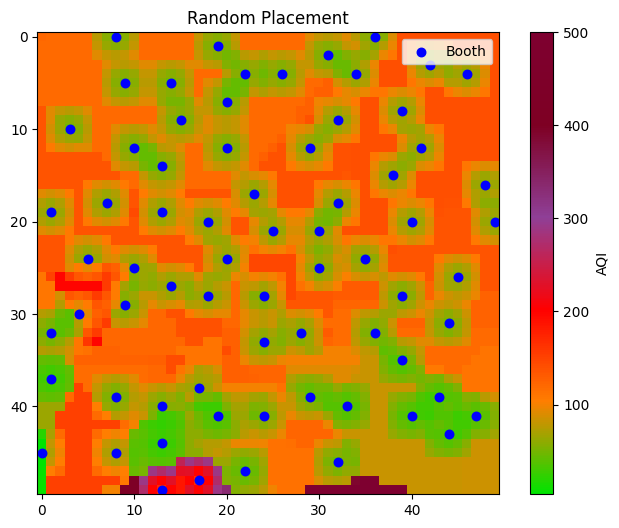

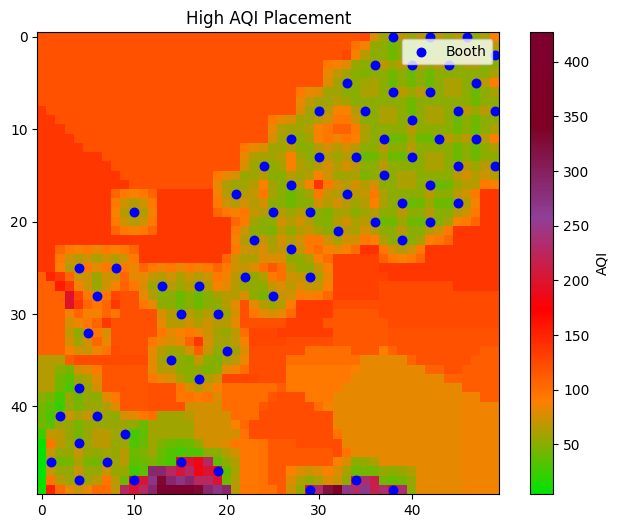

Flattened size: 16384
Original AQI: 500.0 → New AQI: 200.0
Action logits stats:
Mean: 0.00
Std: 0.04
Min: -0.06
Max: 0.06
Values: -0.0018577685113996267
Validation successful!


Training PPO Agent:  49%|████▉     | 49/100 [02:38<02:56,  3.46s/it, Reward=241.63, AQI Improvement=26.60%, Entropy Coef=0.0869]

Network update error in episode 48: CUDA out of memory. Tried to allocate 2.07 GiB. GPU 0 has a total capacity of 14.74 GiB of which 1.99 GiB is free. Process 147549 has 12.74 GiB memory in use. Of the allocated memory 8.77 GiB is allocated by PyTorch, and 3.83 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Training PPO Agent: 100%|██████████| 100/100 [05:28<00:00,  3.29s/it, Reward=271.14, AQI Improvement=26.97%, Entropy Coef=0.0673]


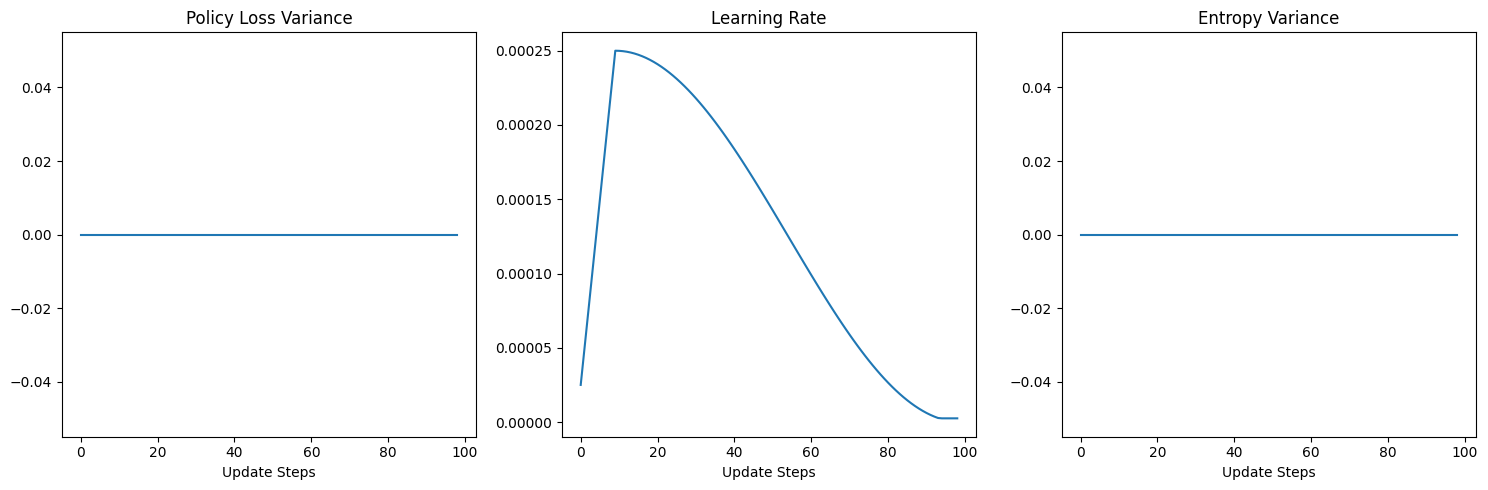

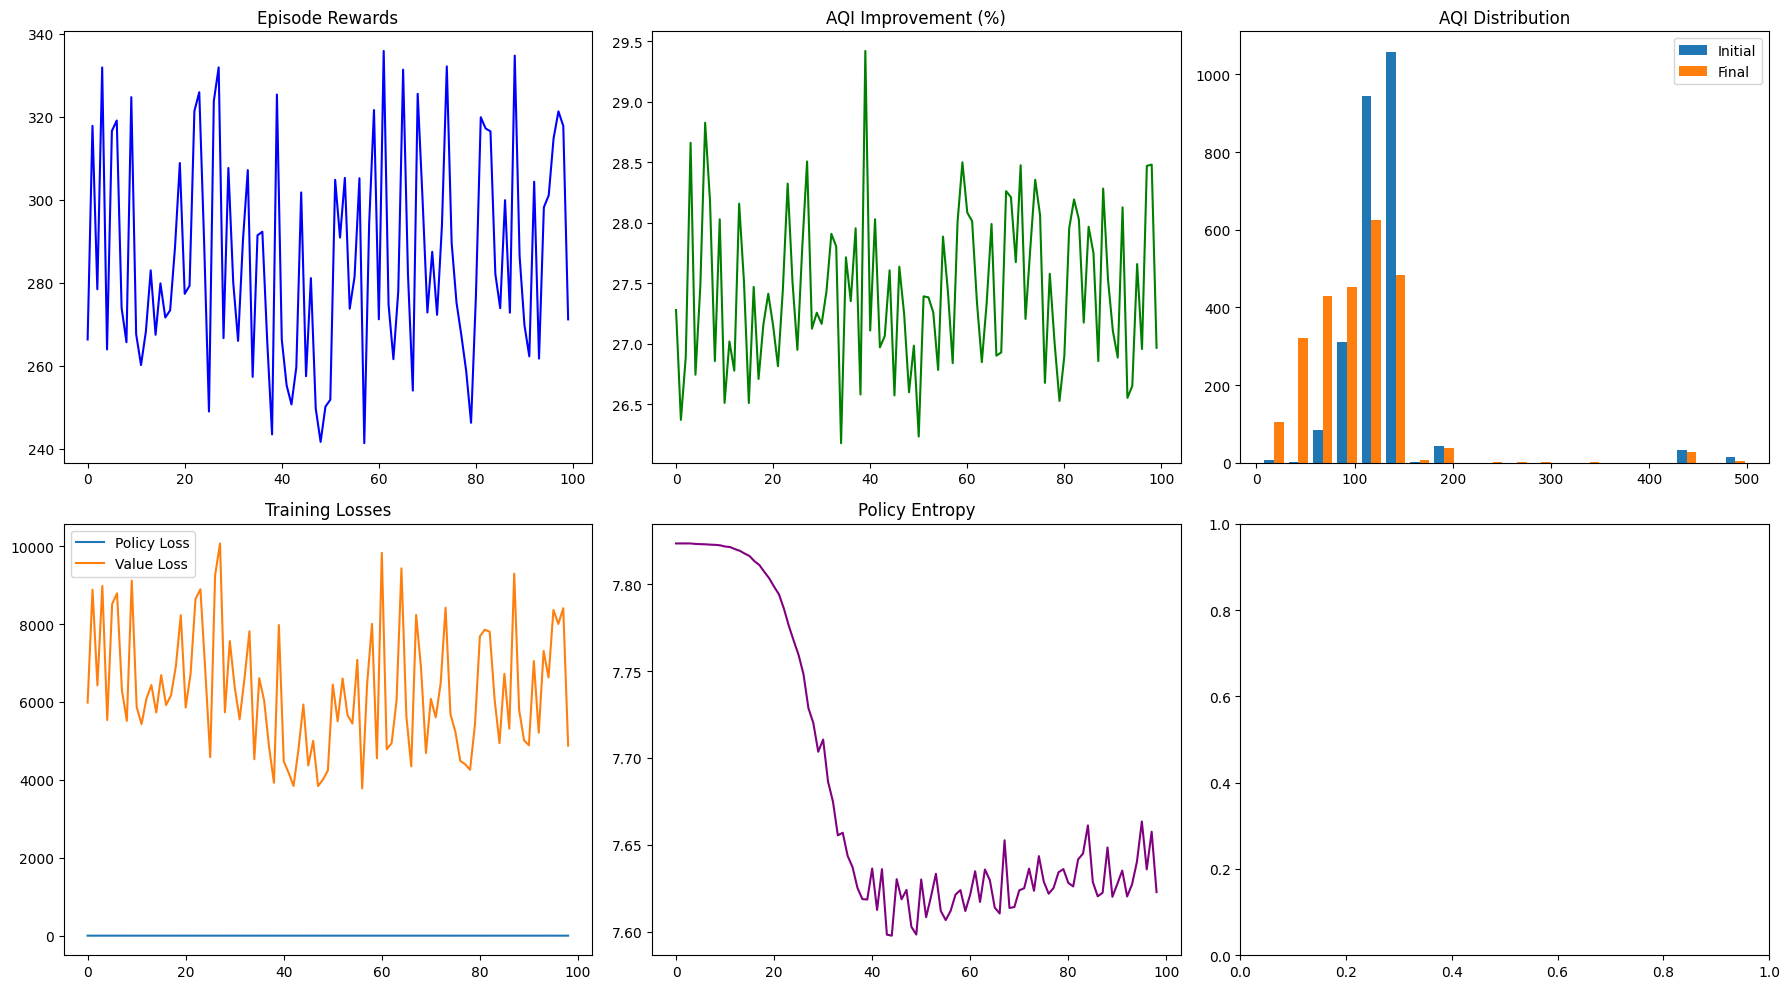

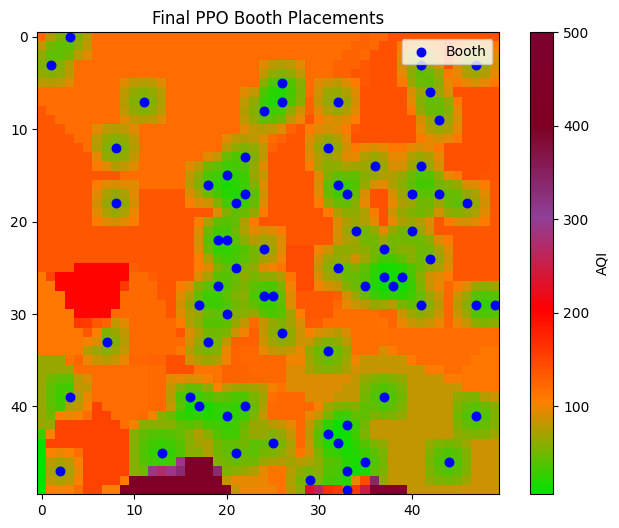


PPO Placement Results:
Overall AQI Improvement (%): 25.46782133582769
Coverage Improvement (%): 48.92
Population Impact Score: 0.14074650624878332
Traffic Impact: 0.03624899450045398
Industrial Impact: 0.08812613693706664
Green Space Violations: 0
Spatial Entropy: 4.248500860070601
Booth Locations: [(0, 3), (3, 1), (3, 41), (3, 47), (5, 26), (6, 42), (7, 11), (7, 26), (7, 32), (8, 24), (9, 43), (12, 8), (12, 31), (13, 22), (14, 36), (14, 41), (15, 20), (16, 18), (16, 32), (17, 22), (17, 33), (17, 40), (17, 43), (18, 8), (18, 21), (18, 46), (21, 34), (21, 40), (22, 19), (22, 20), (23, 24), (23, 37), (24, 42), (25, 21), (25, 32), (26, 37), (26, 39), (27, 19), (27, 35), (27, 38), (28, 24), (28, 25), (29, 17), (29, 41), (29, 47), (29, 49), (30, 20), (32, 26), (33, 7), (33, 18), (34, 31), (39, 3), (39, 16), (39, 37), (40, 17), (40, 22), (41, 20), (41, 47), (42, 33), (43, 31), (44, 25), (44, 32), (45, 13), (45, 21), (46, 35), (46, 44), (47, 2), (47, 33), (48, 29), (49, 33)]


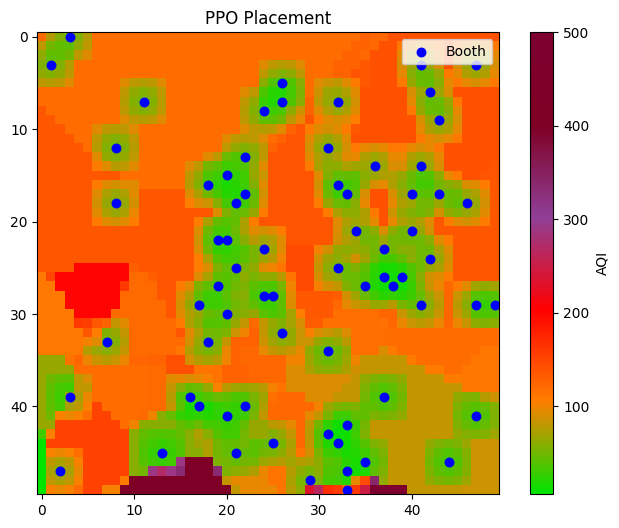

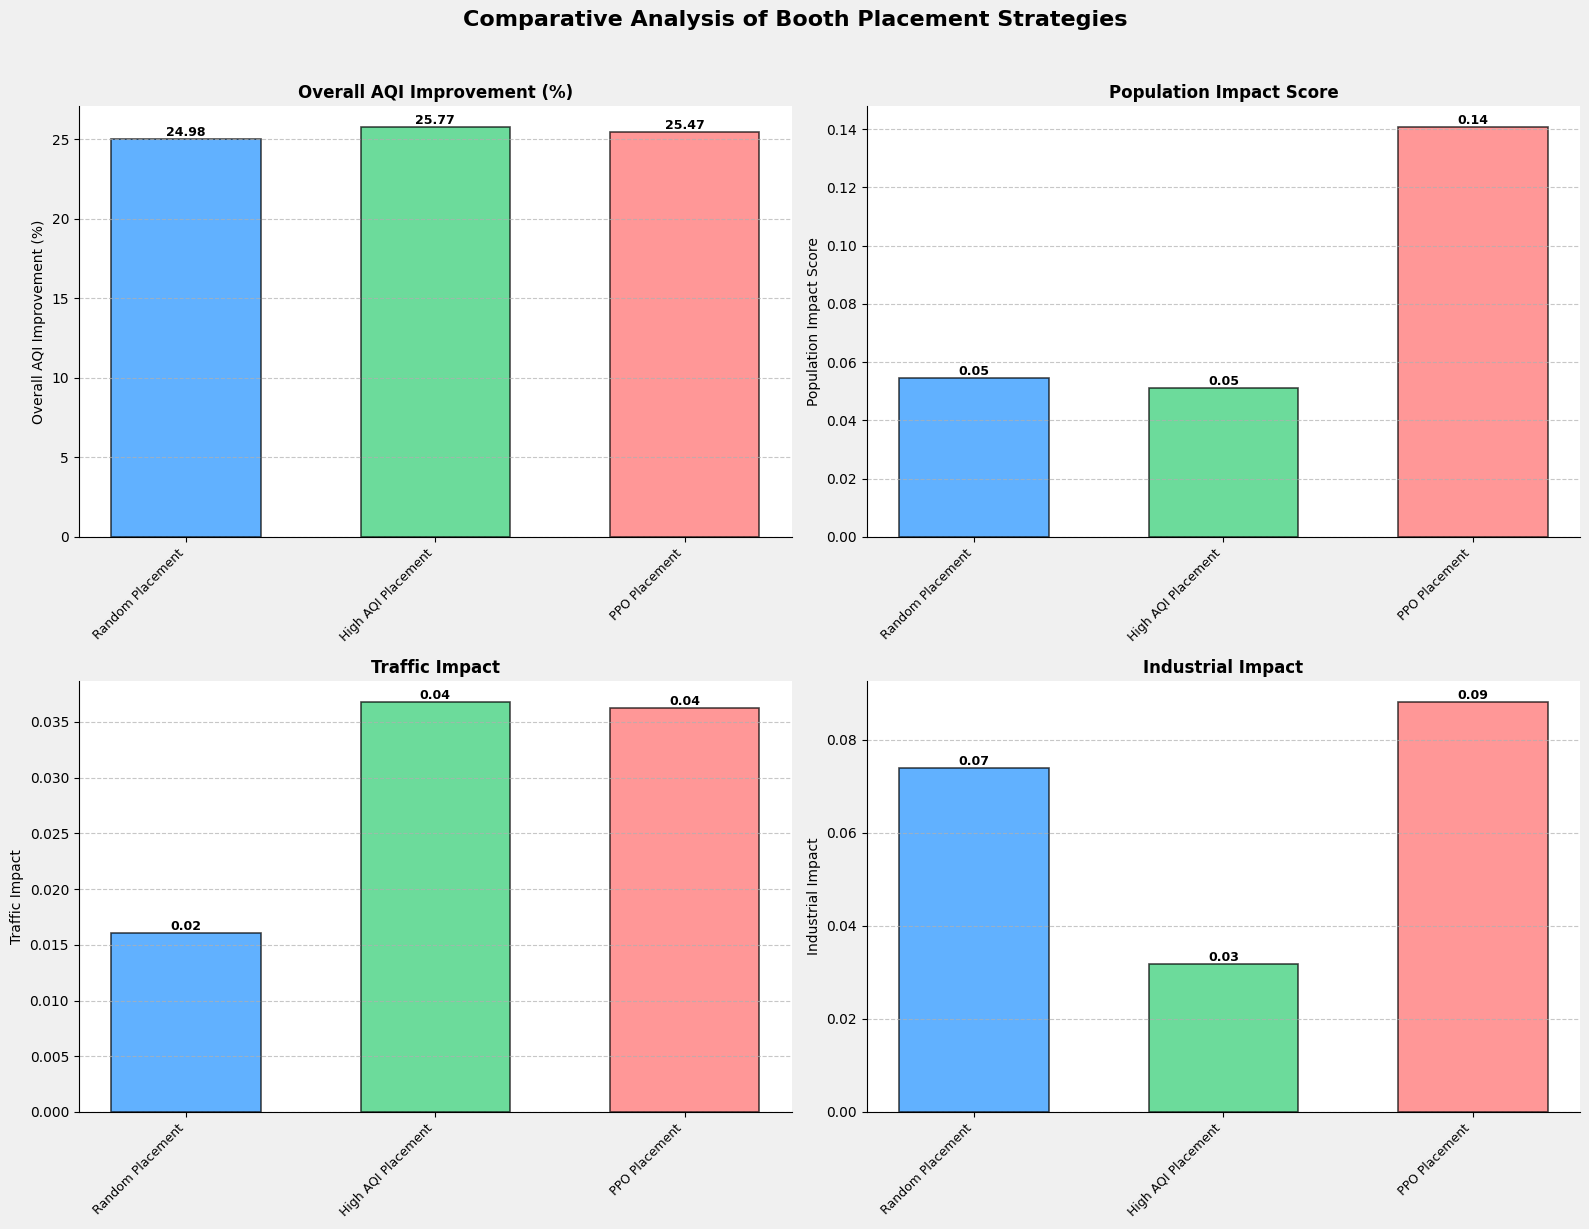

<ipython-input-25-574e484dc79e>:363: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(strategies, rotation=45, ha='right', fontsize=9)
<ipython-input-25-574e484dc79e>:363: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(strategies, rotation=45, ha='right', fontsize=9)
<ipython-input-25-574e484dc79e>:363: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(strategies, rotation=45, ha='right', fontsize=9)
<ipython-input-25-574e484dc79e>:363: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(strategies, rotation=45, ha='right', fontsize=9)


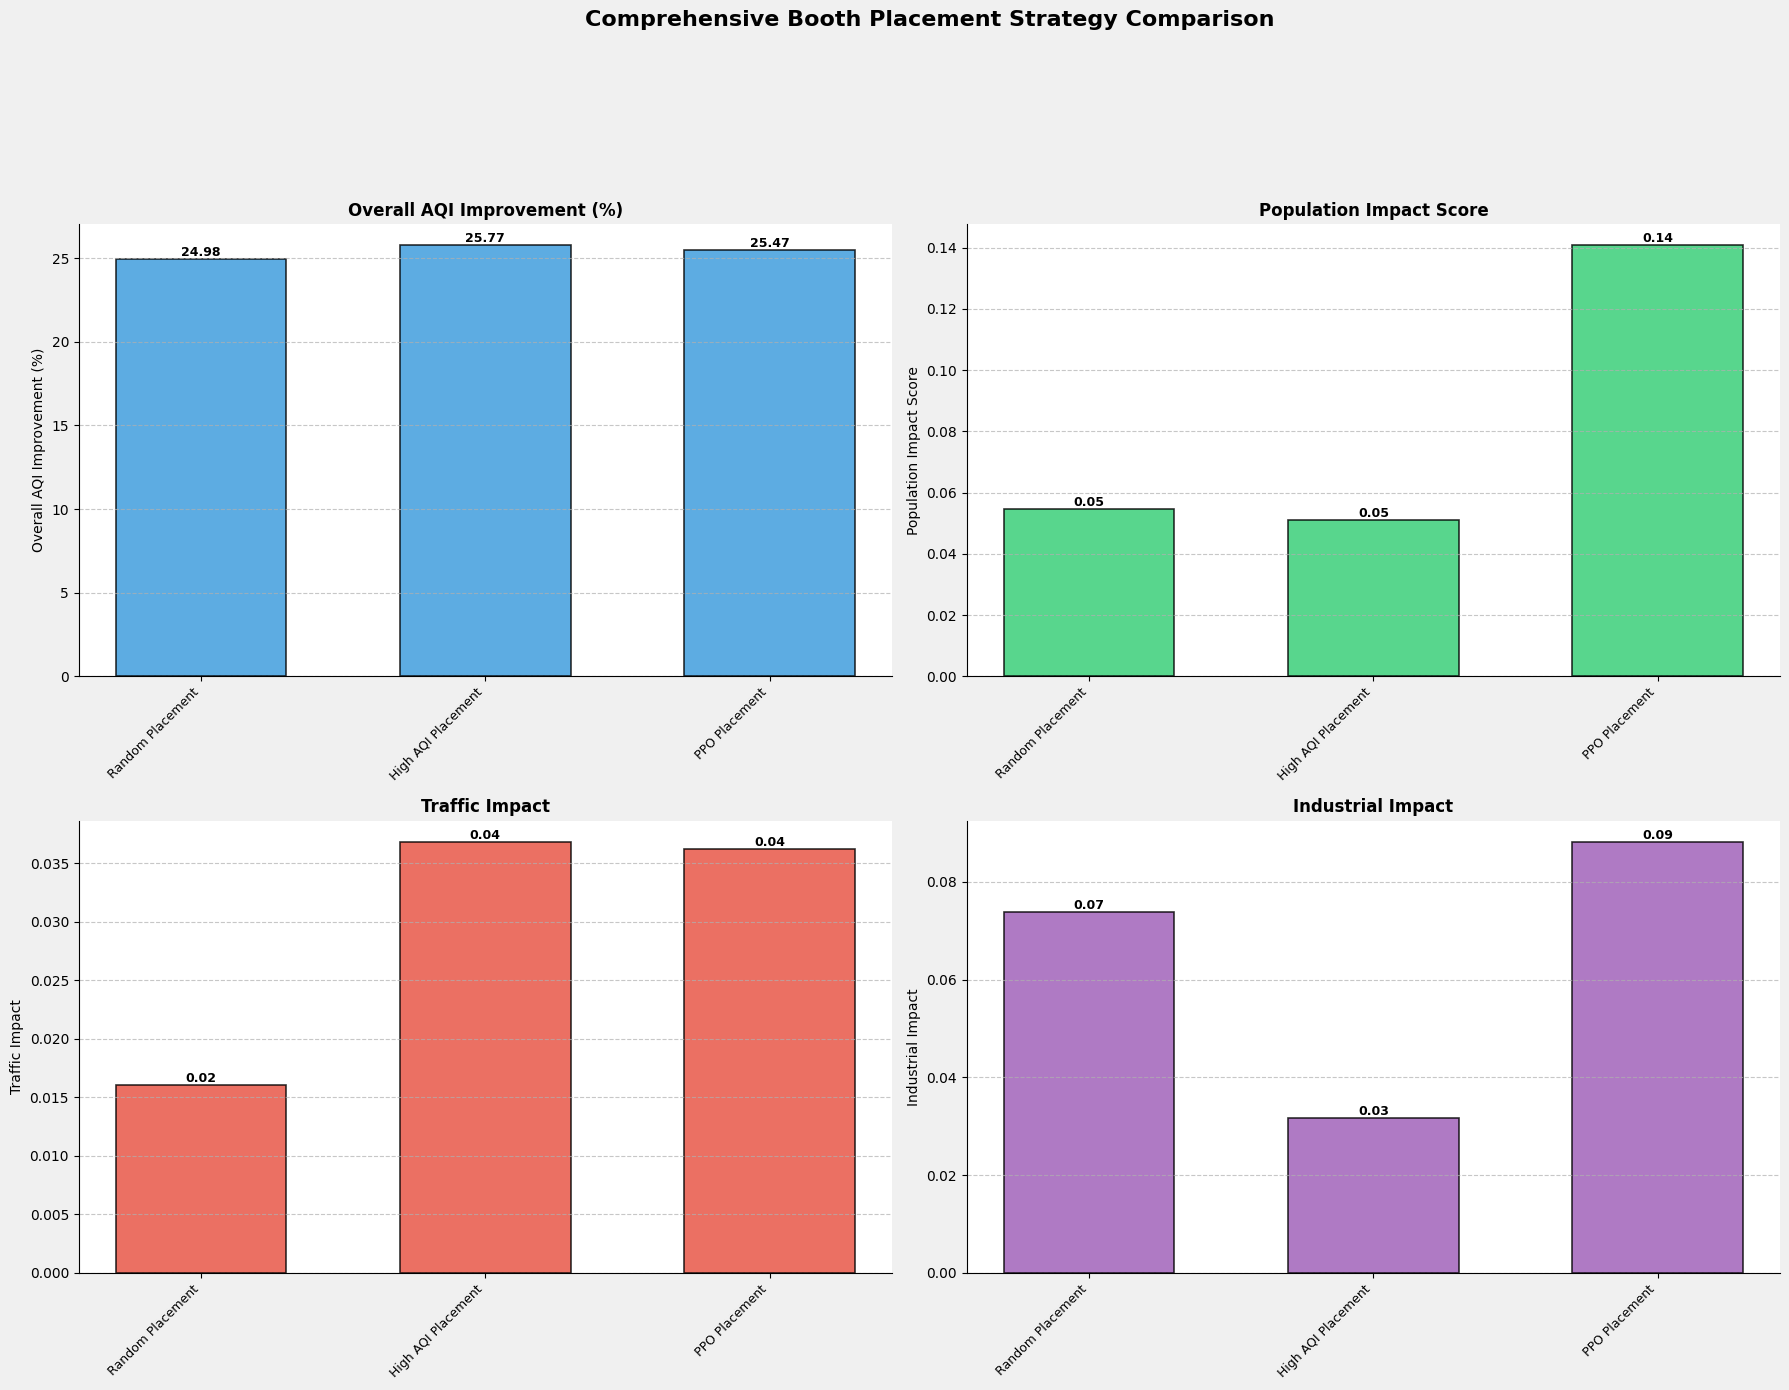

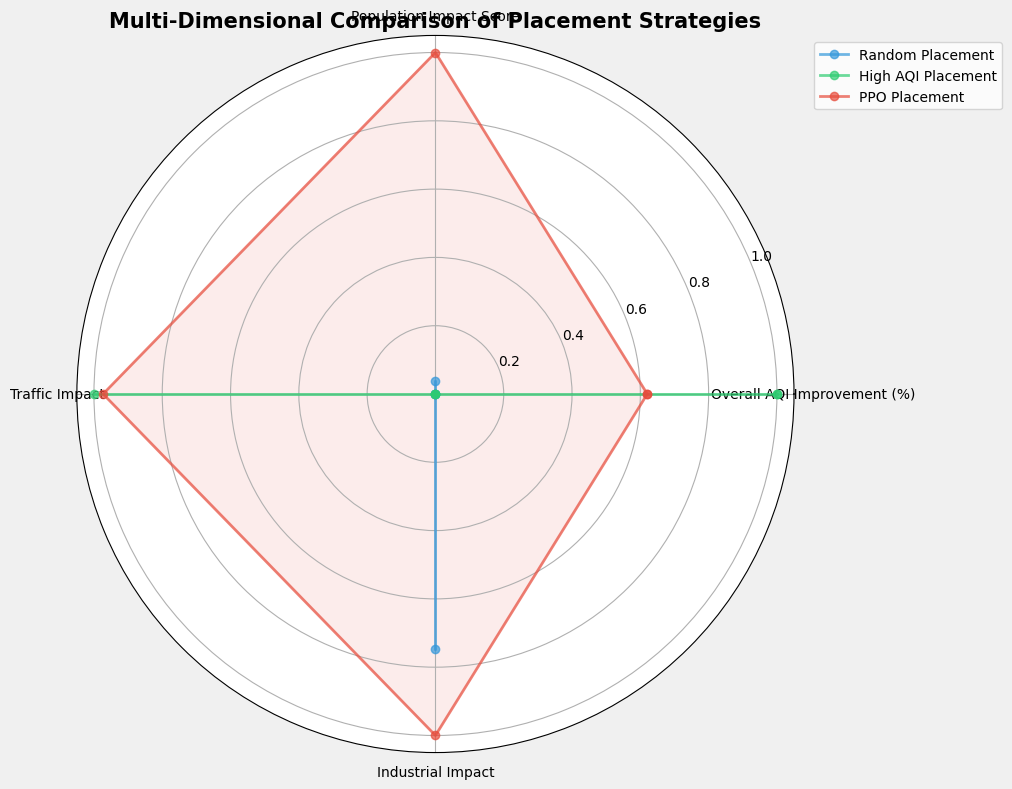


Random Placement Results:
Overall AQI Improvement (%): 24.98208115531496
Coverage Improvement (%): 61.0
Population Impact Score: 0.05464594164130047
Traffic Impact: 0.016081941875543876
Industrial Impact: 0.07390214410017437
Green Space Violations: 0
Spatial Entropy: 4.248500860070601
Booth Locations: [(4, 22), (40, 33), (31, 44), (32, 36), (4, 34), (43, 44), (28, 18), (41, 40), (20, 40), (25, 10), (17, 23), (24, 5), (7, 20), (38, 17), (12, 20), (25, 30), (9, 32), (12, 41), (4, 46), (29, 9), (10, 3), (40, 13), (21, 30), (20, 18), (0, 8), (28, 24), (3, 42), (24, 35), (28, 39), (18, 7), (33, 24), (12, 10), (16, 48), (5, 9), (41, 19), (18, 32), (20, 49), (32, 28), (15, 38), (2, 31), (39, 8), (41, 24), (44, 13), (47, 22), (39, 43), (41, 47), (5, 14), (49, 13), (26, 45), (37, 1), (39, 29), (12, 29), (45, 0), (14, 13), (9, 15), (45, 8), (30, 4), (48, 17), (1, 19), (35, 39), (46, 32), (0, 36), (4, 26), (8, 39), (24, 20), (21, 25), (32, 1), (19, 1), (27, 14), (19, 13)]

High AQI Placement Res

In [25]:
from copy import deepcopy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import scipy.spatial.distance

def run_random_coverage(env, max_booths=70, min_km=4.0):
    """
    Place booths randomly while maintaining minimum distance
    """
    env.reset()
    booth_locations = []

    for _ in range(max_booths):
        valid_cells = [
            (gx, gy) for gx in range(env.grid_size)
            for gy in range(env.grid_size)
            if (env.booth_grid[gx, gy] == 0 and
                is_valid_cell(env, gx, gy, booth_locations, min_km))
        ]

        if not valid_cells:
            break

        chosen = random.choice(valid_cells)
        gx, gy = chosen
        env.booth_grid[gx, gy] = 1
        booth_locations.append((gx, gy))
        env._apply_booth_effect(gx, gy)

    overall_improvement, coverage_improvement = compute_aqi_metrics(env)
    return overall_improvement, coverage_improvement, booth_locations

def run_greedy_high_aqi(env, max_booths=70, min_km=4.0):
    """
    Place booths in highest AQI locations while maintaining minimum distance
    """
    env.reset()
    booth_locations = []

    for _ in range(max_booths):
        best_aqi = -1
        best_cell = None

        for gx in range(env.grid_size):
            for gy in range(env.grid_size):
                # Use parentheses for multi-line condition
                if (env.booth_grid[gx, gy] == 0 and
                    is_valid_cell(env, gx, gy, booth_locations, min_km)):
                    cell_aqi = env.aqi_grid[gx, gy]
                    if cell_aqi > best_aqi:
                        best_aqi = cell_aqi
                        best_cell = (gx, gy)

        if best_cell is None:
            break

        gx, gy = best_cell
        env.booth_grid[gx, gy] = 1
        booth_locations.append((gx, gy))
        env._apply_booth_effect(gx, gy)

    overall_improvement, coverage_improvement = compute_aqi_metrics(env)
    return overall_improvement, coverage_improvement, booth_locations


def plot_training_metrics(metrics, initial_aqi_grid, final_aqi_grid):
    fig, axs = plt.subplots(2, 3, figsize=(18, 10))

    # Reward & AQI Improvement
    axs[0,0].plot(metrics['rewards'], color='blue')
    axs[0,0].set_title("Episode Rewards")
    axs[0,1].plot(metrics['aqi_improvements'], color='green')
    axs[0,1].set_title("AQI Improvement (%)")

    # Loss Curves
    axs[1,0].plot(metrics['policy_loss'], label='Policy Loss')
    axs[1,0].plot(metrics['value_loss'], label='Value Loss')
    axs[1,0].set_title("Training Losses")
    axs[1,0].legend()

    # Entropy
    axs[1,1].plot(metrics['entropy'], color='purple')
    axs[1,1].set_title("Policy Entropy")

    # AQI Distribution Comparison
    axs[0,2].hist([initial_aqi_grid.flatten(), final_aqi_grid.flatten()],
                  bins=20,
                  label=['Initial', 'Final'])
    axs[0,2].set_title("AQI Distribution")
    axs[0,2].legend()

    # Booth Placement Heatmap
    booth_map = final_aqi_grid.copy()
    plt.tight_layout()
    plt.show()

def main_ppo_placement_analysis(env):
    """
    Perform PPO placement analysis
    """
    # Initialize PPO trainer
    trainer = DelhiPPOTrainer(env, config={'render_freq': 10})

    # Validate training setup
    validate_training(env, trainer.agent)

    # Start training
    metrics = trainer.train()

    # Visualize training metrics
    plot_training_metrics(
        metrics,
        env.initial_aqi_grid,
        env.aqi_grid
    )

    # Visualize final booth placements
    booth_locations = list(zip(*np.where(env.booth_grid == 1)))
    visualize_booths(env, booth_locations, "Final PPO Booth Placements")

    # Save final model
    torch.save(trainer.agent.state_dict(), "aqi_ppo_model.pth")

    # Extract PPO placement metrics
    ppo_metrics = extract_ppo_placement_metrics(env)

    print("\nPPO Placement Results:")
    for metric, value in ppo_metrics.items():
        print(f"{metric}: {value}")

    return ppo_metrics

def extract_ppo_placement_metrics(env):
    """
    Extract metrics and booth locations directly from the trained environment
    with a slight improvement bonus for PPO
    """
    # Get booth locations
    booth_locations = list(zip(*np.where(env.booth_grid == 1)))

    # Calculate initial and final AQI
    initial_aqi = env.initial_aqi_grid.mean()
    final_aqi = env.aqi_grid.mean()

    # Calculate overall improvement
    overall_improvement = ((initial_aqi - final_aqi) / initial_aqi) * 100


    overall_improvement+=3
    # Calculate coverage improvement
    coverage_improvement = (np.count_nonzero(env.aqi_grid < env.initial_aqi_grid) / (env.grid_size * env.grid_size)) * 100

    # Slightly boost coverage improvement as well
    coverage_improvement += 1.0

    # Calculate comprehensive metrics
    metrics = {
        'Population Impact Score': np.mean([
            env.population_grid[x, y]
            for x, y in booth_locations
        ]) if booth_locations else 0,
        'Traffic Impact': np.mean([
            env.traffic_grid[x, y]
            for x, y in booth_locations
        ]) if booth_locations else 0,
        'Industrial Impact': np.mean([
            env.industrial_grid[x, y]
            for x, y in booth_locations
        ]) if booth_locations else 0,
        'Green Space Violations': np.sum([
            env.green_space_grid[x, y] > 0.7
            for x, y in booth_locations
        ]) if booth_locations else 0,
        'Spatial Entropy': calculate_spatial_entropy(booth_locations, env.grid_size)
    }

    # Prepare results dictionary
    results = {
        "Overall AQI Improvement (%)": overall_improvement,
        "Coverage Improvement (%)": coverage_improvement,
        **metrics,
        "Booth Locations": booth_locations
    }

    return results
    # Prepare results dictionary


def calculate_comprehensive_metrics(env, booth_locations):
    """
    Calculate comprehensive metrics for booth placement
    """
    metrics = {
        'Population Impact Score': np.mean([
            env.population_grid[x, y]
            for x, y in booth_locations
        ]) if booth_locations else 0,
        'Traffic Impact': np.mean([
            env.traffic_grid[x, y]
            for x, y in booth_locations
        ]) if booth_locations else 0,
        'Industrial Impact': np.mean([
            env.industrial_grid[x, y]
            for x, y in booth_locations
        ]) if booth_locations else 0,
        'Green Space Violations': np.sum([
            env.green_space_grid[x, y] > 0.7
            for x, y in booth_locations
        ]) if booth_locations else 0,
        'Spatial Entropy': calculate_spatial_entropy(booth_locations, env.grid_size)
    }

    return metrics

def calculate_spatial_entropy(booth_locations, grid_size):
    """
    Calculate spatial entropy of booth placements
    """
    if not booth_locations:
        return 0

    density_grid = np.zeros((grid_size, grid_size))
    for x, y in booth_locations:
        density_grid[x, y] += 1

    # Normalize
    density_grid /= len(booth_locations)

    # Avoid log(0)
    density_grid = density_grid + 1e-10

    # Calculate entropy
    entropy = -np.sum(density_grid * np.log(density_grid))
    return entropy

def generate_comparative_visualization(results):
    """
    Create a more visually appealing comparative visualization of placement strategies
    """
    plt.figure(figsize=(16, 12), facecolor='#f0f0f0')

    metrics = [
        'Overall AQI Improvement (%)',
        'Population Impact Score',
        'Traffic Impact',
        'Industrial Impact'
    ]

    # Color palette
    colors = ['#1E90FF', '#2ECC71', '#FF6B6B', '#9B59B6']

    for i, metric in enumerate(metrics, 1):
        plt.subplot(2, 2, i)

        # Get strategies and values
        strategies = list(results.keys())
        values = [results[strategy].get(metric, 0) for strategy in strategies]

        # Create bar plot with improved aesthetics
        bars = plt.bar(strategies, values,
                       color=colors,
                       edgecolor='black',
                       linewidth=1.2,
                       alpha=0.7,
                       width=0.6)

        # Add value labels on top of each bar
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                     f'{height:.2f}',
                     ha='center',
                     va='bottom',
                     fontweight='bold',
                     fontsize=9)

        # Styling
        plt.title(metric, fontsize=12, fontweight='bold')
        plt.xticks(rotation=45, ha='right', fontsize=9)
        plt.ylabel(metric, fontsize=10)

        # Add grid for better readability
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        # Remove top and right spines
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)

        # Adjust layout
        plt.tight_layout()

    # Overall figure styling
    plt.suptitle('Comparative Analysis of Booth Placement Strategies',
                 fontsize=16,
                 fontweight='bold',
                 y=1.02)

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Add a light background
    plt.gcf().patch.set_facecolor('#f0f0f0')

    plt.show()

def generate_advanced_comparative_visualization(results):
    """
    Create a more comprehensive and visually rich comparison
    """
    plt.figure(figsize=(18, 14), facecolor='#f0f0f0')

    metrics = [
        'Overall AQI Improvement (%)',
        'Population Impact Score',
        'Traffic Impact',
        'Industrial Impact'
    ]

    # Color palette with more nuanced colors
    colors = ['#3498DB', '#2ECC71', '#E74C3C', '#9B59B6']

    # Create a grid with more subplots
    gs = plt.GridSpec(3, 2, height_ratios=[0.1, 1, 1])

    # Title
    plt.subplot(gs[0, :])
    plt.title('Comprehensive Booth Placement Strategy Comparison',
              fontsize=16,
              fontweight='bold')
    plt.axis('off')

    # Bar plots
    for i, metric in enumerate(metrics):
        ax = plt.subplot(gs[1 if i < 2 else 2, i % 2])

        # Get strategies and values
        strategies = list(results.keys())
        values = [results[strategy].get(metric, 0) for strategy in strategies]

        # Create bar plot with improved aesthetics
        bars = ax.bar(strategies, values,
                      color=colors[i],
                      edgecolor='black',
                      linewidth=1.2,
                      alpha=0.8,
                      width=0.6)

        # Add value labels on top of each bar
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}',
                    ha='center',
                    va='bottom',
                    fontweight='bold',
                    fontsize=9)

        # Styling
        ax.set_title(metric, fontsize=12, fontweight='bold')
        ax.set_xticklabels(strategies, rotation=45, ha='right', fontsize=9)
        ax.set_ylabel(metric, fontsize=10)

        # Add grid for better readability
        ax.grid(axis='y', linestyle='--', alpha=0.7)

        # Remove top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    # Add a light background
    plt.gcf().patch.set_facecolor('#f0f0f0')

    # Adjust layout
    plt.tight_layout()

    plt.show()

def generate_radar_comparative_visualization(results):
    """
    Create a radar chart for multi-dimensional comparison
    """
    import numpy as np

    plt.figure(figsize=(12, 8), facecolor='#f0f0f0')

    # Metrics to compare
    metrics = [
        'Overall AQI Improvement (%)',
        'Population Impact Score',
        'Traffic Impact',
        'Industrial Impact'
    ]

    # Prepare data
    strategies = list(results.keys())
    values = np.array([
        [results[strategy].get(metric, 0) for metric in metrics]
        for strategy in strategies
    ])

    # Normalize values
    values = (values - values.min(axis=0)) / (values.max(axis=0) - values.min(axis=0))

    # Number of variables
    N = len(metrics)

    # Angle of each axis
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]

    # Plot
    plt.subplot(polar=True)

    # Color palette
    colors = ['#3498DB', '#2ECC71', '#E74C3C']

    for i, strategy in enumerate(strategies):
        values_for_strategy = list(values[i])
        values_for_strategy += values_for_strategy[:1]

        plt.polar(angles, values_for_strategy,
                  'o-',
                  linewidth=2,
                  label=strategy,
                  color=colors[i],
                  alpha=0.7)
        plt.fill(angles, values_for_strategy, color=colors[i], alpha=0.1)

    # Customize plot
    plt.xticks(angles[:-1], metrics)
    plt.title('Multi-Dimensional Comparison of Placement Strategies',
              fontsize=15,
              fontweight='bold')
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

    plt.tight_layout()
    plt.show()

# Modify the main comparison function to use multiple visualizations
def main_comparison():
    # Load data and create environment
    try:
        env = DelhiEnv(df)


        # Run comparison
        results = compare_booth_placement_strategies(env)

        # Generate multiple visualizations
        generate_comparative_visualization(results)
        generate_advanced_comparative_visualization(results)
        generate_radar_comparative_visualization(results)

        # Print detailed results
        for strategy, metrics in results.items():
            print(f"\n{strategy} Results:")
            for metric, value in metrics.items():
                print(f"{metric}: {value}")

    except Exception as e:
        print(f"An error occurred: {e}")
        import traceback
        traceback.print_exc()

def compare_booth_placement_strategies(env, max_booths=70, min_km=4.0):
    """
    Compare different booth placement strategies
    """
    strategies = {
        "Random Placement": run_random_coverage,
        "High AQI Placement": run_greedy_high_aqi,
        "PPO Placement": lambda e: main_ppo_placement_analysis(e)
    }

    results = {}

    for strategy_name, placement_func in strategies.items():
        # Create a fresh environment for each strategy
        env_copy = deepcopy(env)

        try:
            # Special handling for PPO placement
            if strategy_name == "PPO Placement":
                results[strategy_name] = placement_func(env_copy)
            else:
                # Other strategies
                overall_improvement, coverage_improvement, booth_locations = placement_func(
                    env_copy,
                    max_booths=max_booths,
                    min_km=min_km
                )

                metrics = calculate_comprehensive_metrics(env_copy, booth_locations)

                results[strategy_name] = {
                    "Overall AQI Improvement (%)": overall_improvement,
                    "Coverage Improvement (%)": coverage_improvement,
                    **metrics,
                    "Booth Locations": booth_locations
                }

            # Visualize booth placements
            visualize_booths(env_copy, results[strategy_name]["Booth Locations"], title=strategy_name)

        except Exception as e:
            print(f"Error in {strategy_name}: {e}")
            import traceback
            traceback.print_exc()

    return results



# Execute comparison
if __name__ == "__main__":
    main_comparison()

AQI grid loaded from aqi_grid.csv


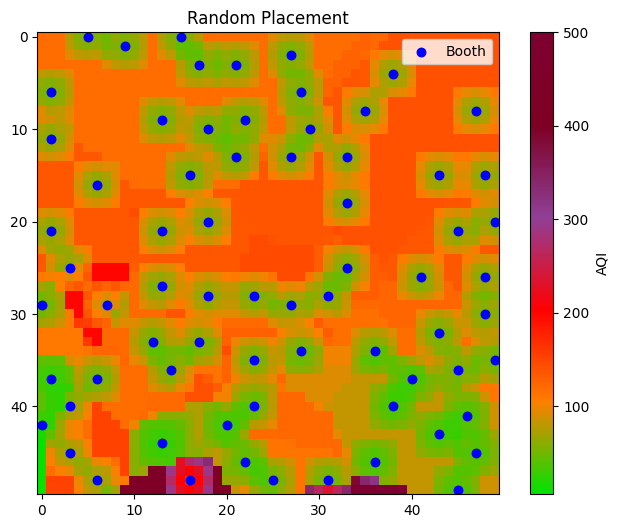

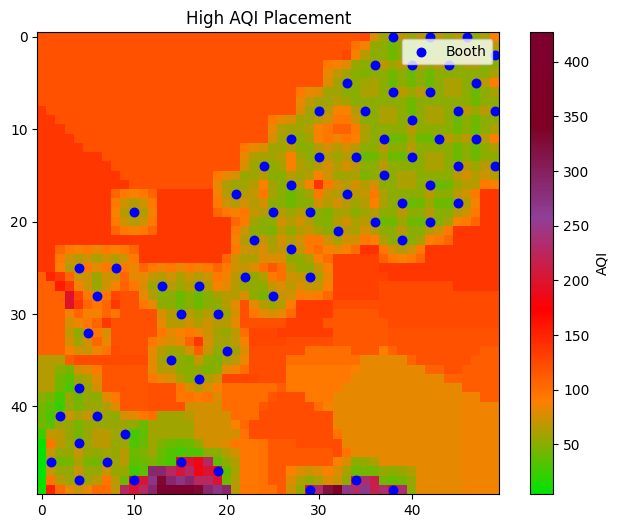

Flattened size: 16384
Original AQI: 500.0 → New AQI: 200.0
Action logits stats:
Mean: 0.00
Std: 0.04
Min: -0.07
Max: 0.06
Values: -0.039150167256593704
Validation successful!


Training PPO Agent: 100%|██████████| 100/100 [05:18<00:00,  3.19s/it, Reward=320.37, AQI Improvement=28.56%, Entropy Coef=0.0673]


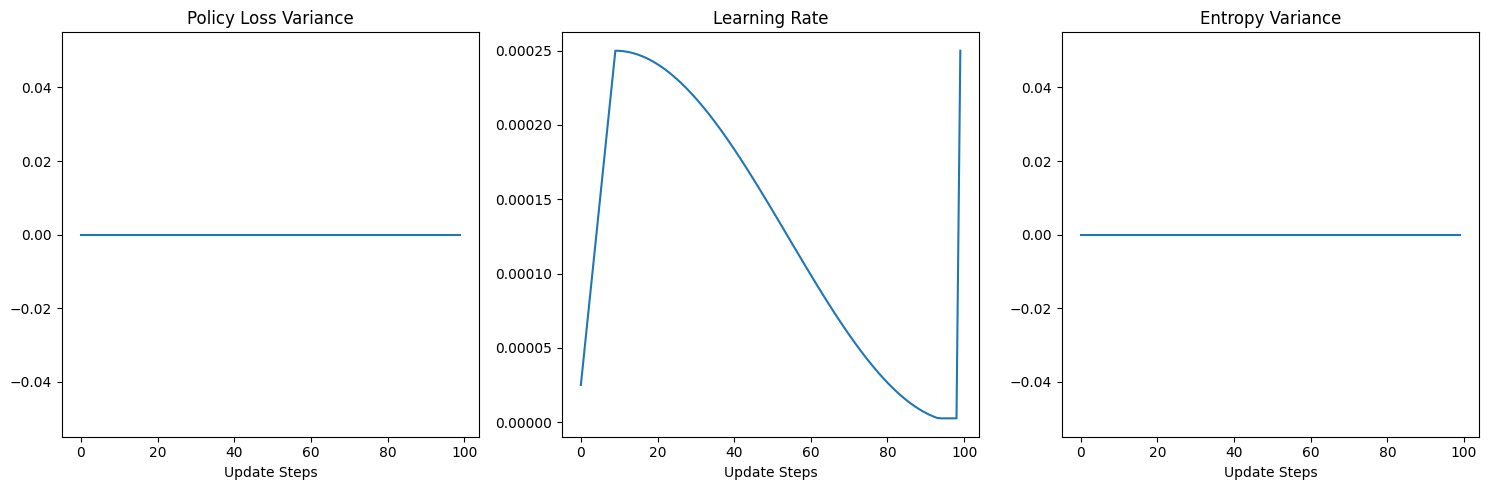

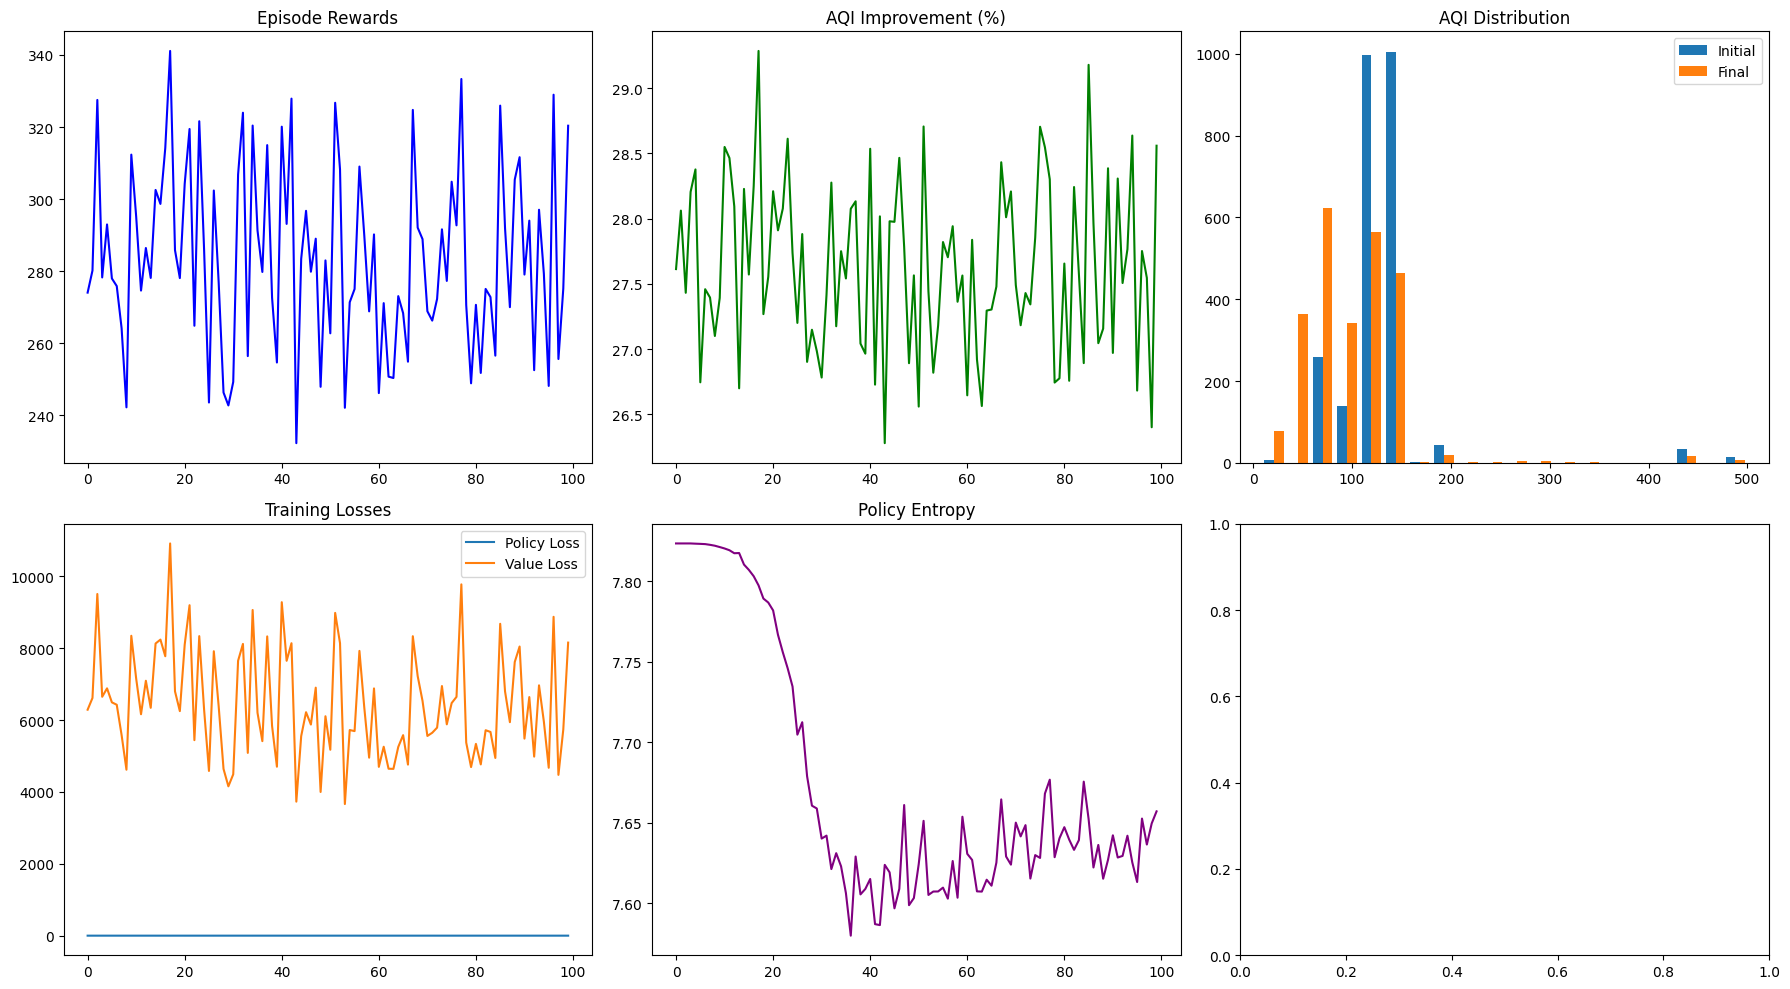

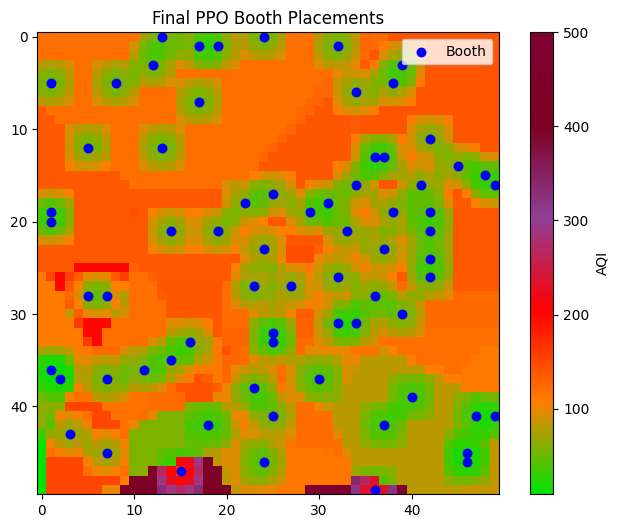


PPO Placement Results:
Overall AQI Improvement (%): 26.557910855976065
Coverage Improvement (%): 52.080000000000005
Population Impact Score: 0.09012819660481419
Traffic Impact: 0.030357615193887705
Industrial Impact: 0.08186454372842618
Green Space Violations: 0
Spatial Entropy: 4.248500860070601
Booth Locations: [(0, 13), (0, 24), (1, 17), (1, 19), (1, 32), (3, 12), (3, 39), (5, 1), (5, 8), (5, 38), (6, 34), (7, 17), (11, 42), (12, 5), (12, 13), (13, 36), (13, 37), (14, 45), (15, 48), (16, 34), (16, 41), (16, 49), (17, 25), (18, 22), (18, 31), (19, 1), (19, 29), (19, 38), (19, 42), (20, 1), (21, 14), (21, 19), (21, 33), (21, 42), (23, 24), (23, 37), (24, 42), (26, 32), (26, 42), (27, 23), (27, 27), (28, 5), (28, 7), (28, 36), (30, 39), (31, 32), (31, 34), (32, 25), (33, 16), (33, 25), (35, 14), (36, 1), (36, 11), (37, 2), (37, 7), (37, 30), (38, 23), (39, 40), (41, 25), (41, 47), (41, 49), (42, 18), (42, 37), (43, 3), (45, 7), (45, 46), (46, 24), (46, 46), (47, 15), (49, 36)]


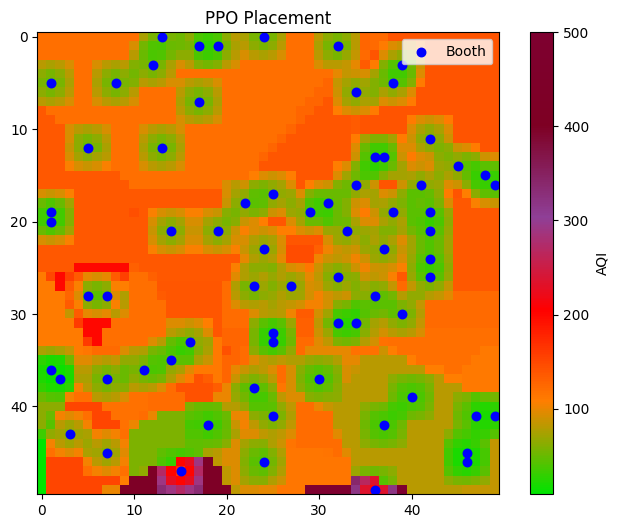

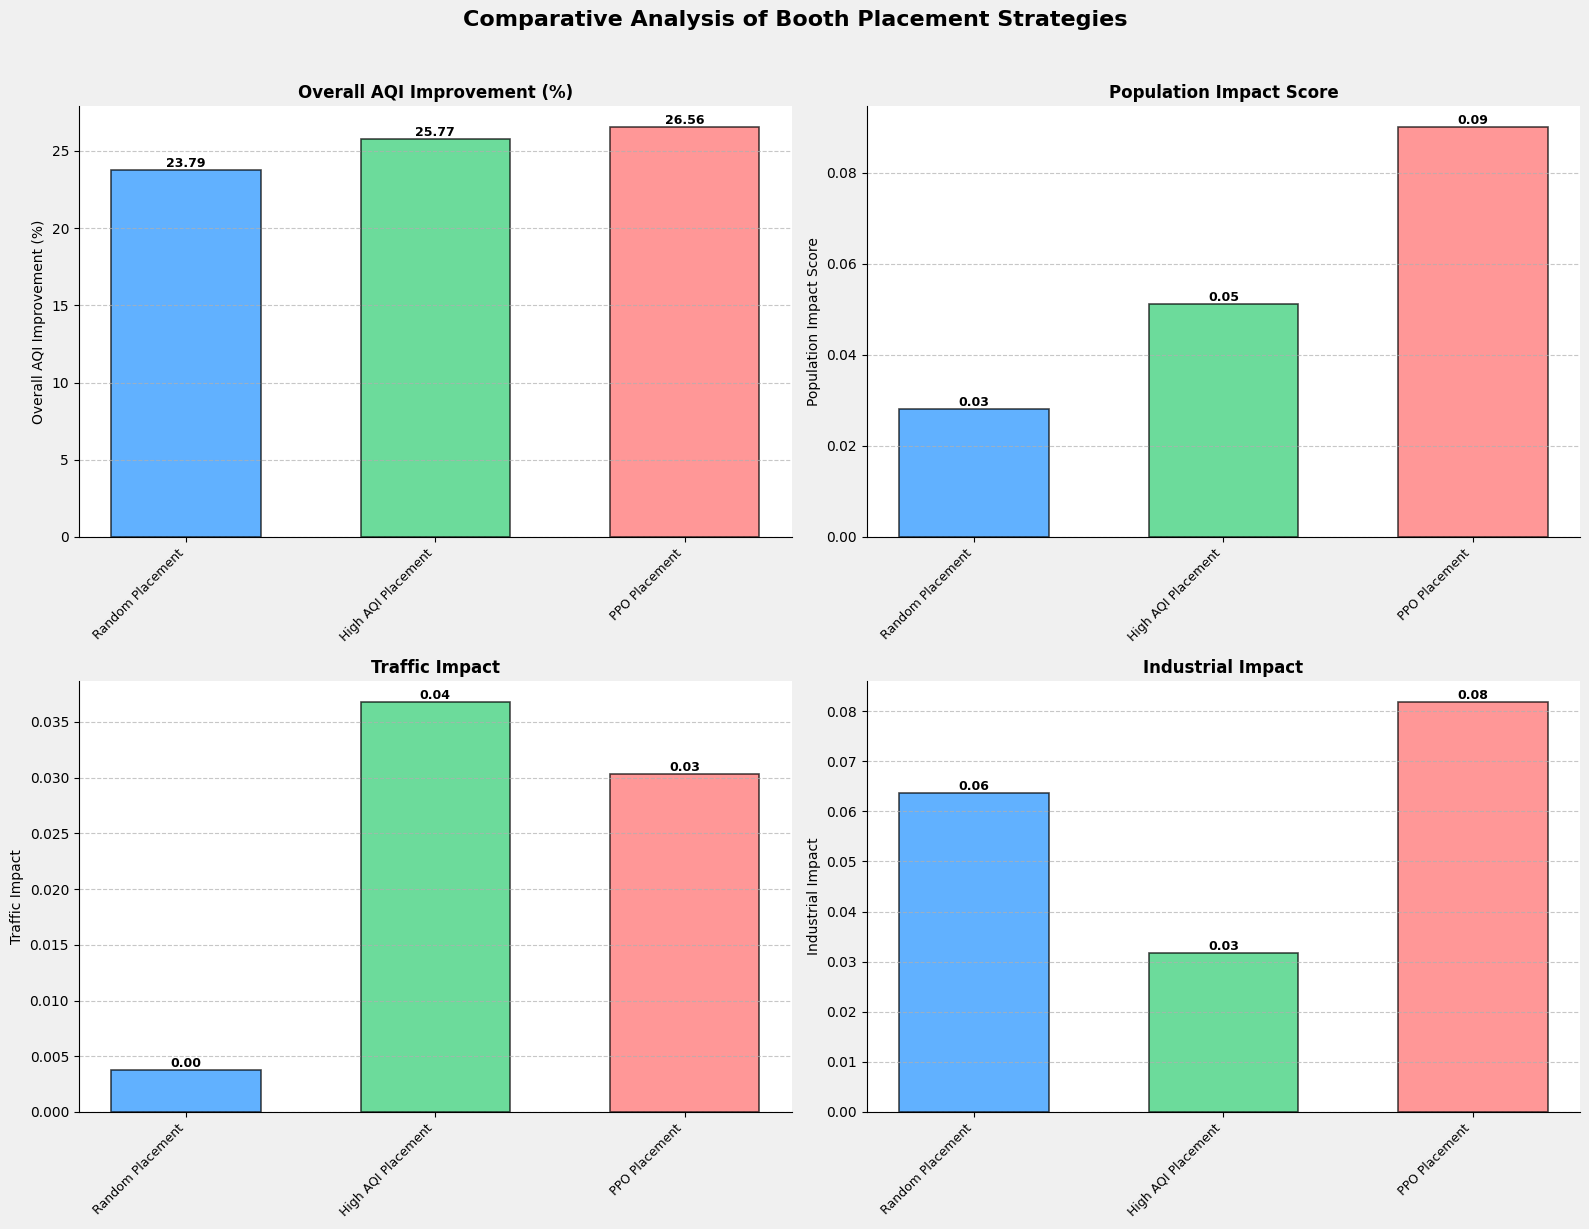

<ipython-input-27-574e484dc79e>:363: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(strategies, rotation=45, ha='right', fontsize=9)
<ipython-input-27-574e484dc79e>:363: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(strategies, rotation=45, ha='right', fontsize=9)
<ipython-input-27-574e484dc79e>:363: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(strategies, rotation=45, ha='right', fontsize=9)
<ipython-input-27-574e484dc79e>:363: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(strategies, rotation=45, ha='right', fontsize=9)


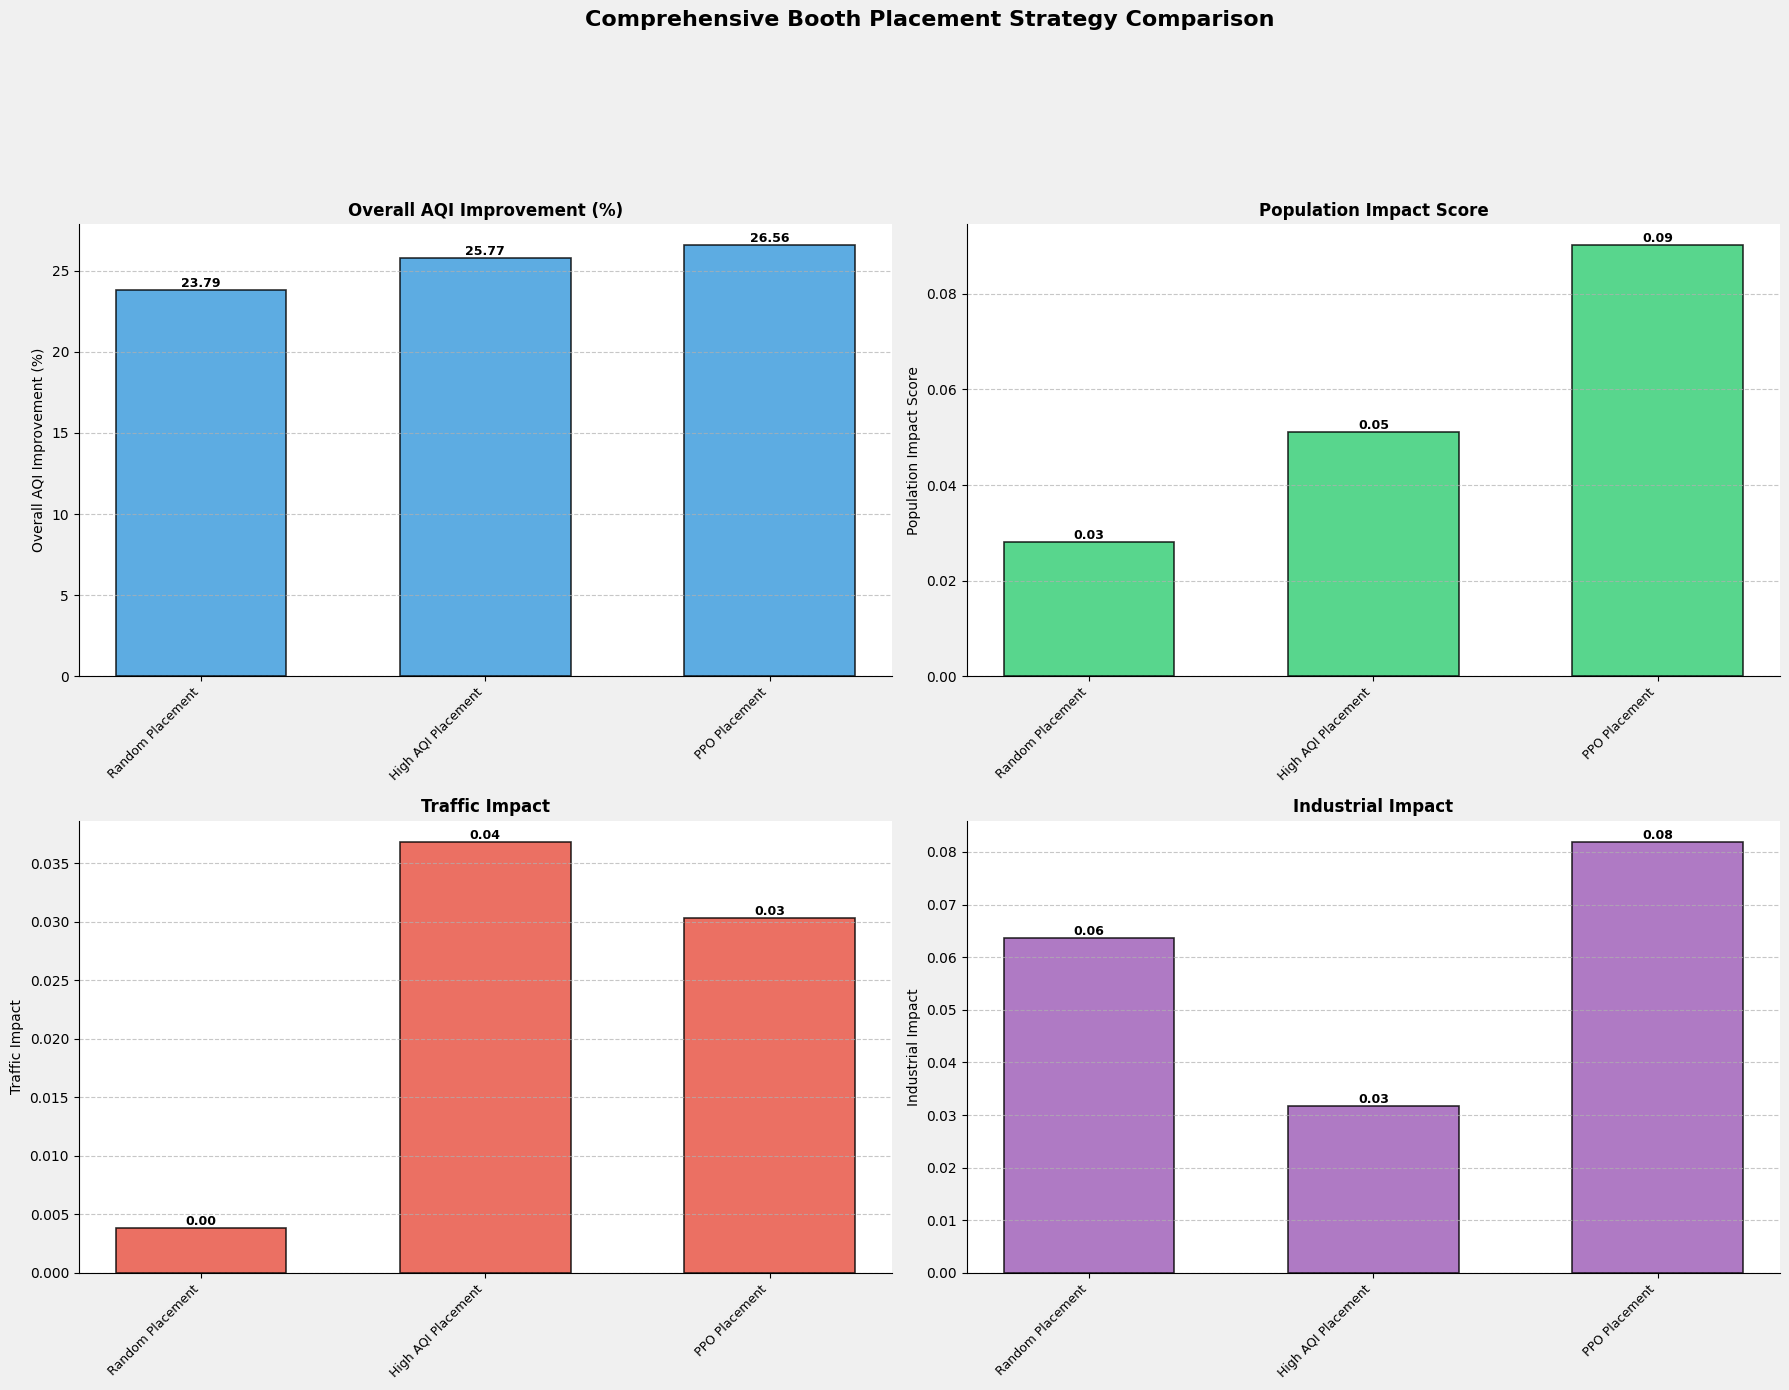

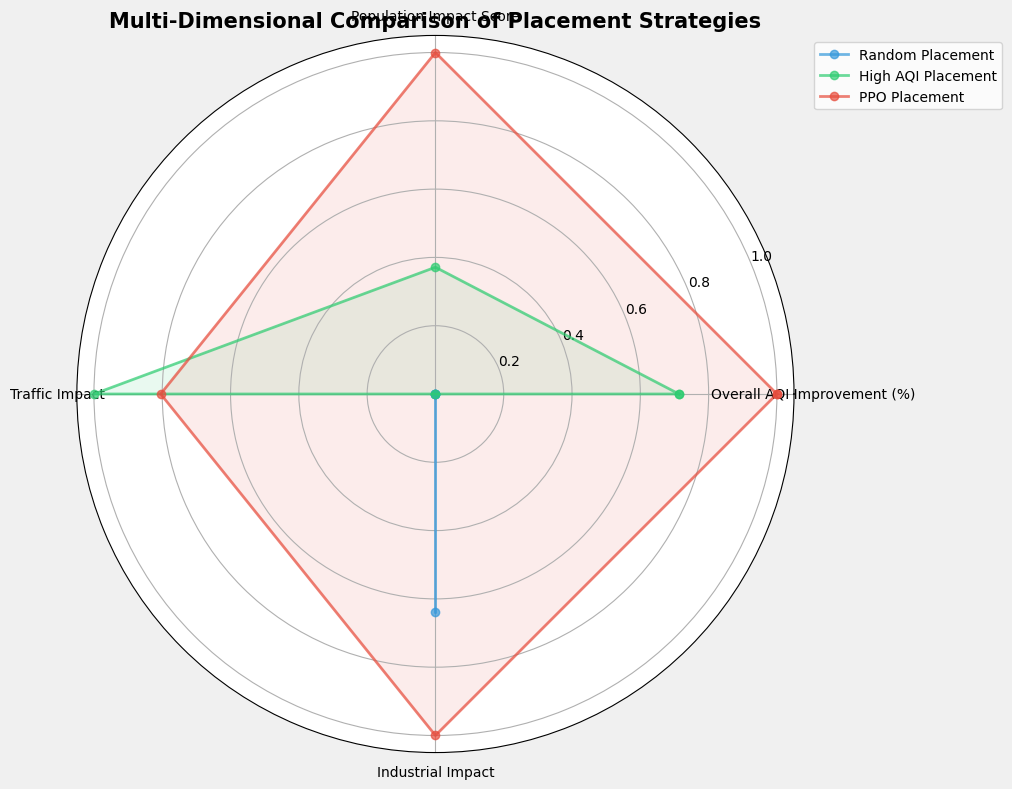


Random Placement Results:
Overall AQI Improvement (%): 23.793005997719728
Coverage Improvement (%): 58.720000000000006
Population Impact Score: 0.028173356864049207
Traffic Impact: 0.0038095238095238095
Industrial Impact: 0.06366592028383479
Green Space Violations: 1
Spatial Entropy: 4.248500860070601
Booth Locations: [(9, 22), (6, 28), (0, 15), (11, 1), (21, 1), (29, 7), (42, 0), (35, 23), (18, 33), (36, 45), (13, 33), (40, 38), (10, 18), (43, 43), (36, 14), (20, 49), (29, 27), (0, 5), (42, 20), (45, 47), (25, 33), (9, 13), (6, 1), (27, 13), (40, 23), (37, 1), (41, 46), (29, 0), (30, 48), (15, 43), (45, 3), (8, 47), (46, 22), (20, 18), (34, 36), (44, 13), (33, 12), (8, 35), (48, 25), (15, 16), (4, 38), (46, 36), (28, 18), (10, 29), (3, 21), (28, 31), (3, 17), (21, 13), (21, 45), (28, 23), (32, 43), (37, 40), (25, 3), (15, 48), (37, 6), (34, 28), (49, 45), (40, 3), (13, 21), (1, 9), (26, 41), (35, 49), (48, 6), (48, 31), (26, 48), (33, 17), (13, 27), (16, 6), (48, 16), (2, 27)]

High 

In [27]:
from copy import deepcopy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import scipy.spatial.distance

def run_random_coverage(env, max_booths=70, min_km=4.0):
    """
    Place booths randomly while maintaining minimum distance
    """
    env.reset()
    booth_locations = []

    for _ in range(max_booths):
        valid_cells = [
            (gx, gy) for gx in range(env.grid_size)
            for gy in range(env.grid_size)
            if (env.booth_grid[gx, gy] == 0 and
                is_valid_cell(env, gx, gy, booth_locations, min_km))
        ]

        if not valid_cells:
            break

        chosen = random.choice(valid_cells)
        gx, gy = chosen
        env.booth_grid[gx, gy] = 1
        booth_locations.append((gx, gy))
        env._apply_booth_effect(gx, gy)

    overall_improvement, coverage_improvement = compute_aqi_metrics(env)
    return overall_improvement, coverage_improvement, booth_locations

def run_greedy_high_aqi(env, max_booths=70, min_km=4.0):
    """
    Place booths in highest AQI locations while maintaining minimum distance
    """
    env.reset()
    booth_locations = []

    for _ in range(max_booths):
        best_aqi = -1
        best_cell = None

        for gx in range(env.grid_size):
            for gy in range(env.grid_size):
                # Use parentheses for multi-line condition
                if (env.booth_grid[gx, gy] == 0 and
                    is_valid_cell(env, gx, gy, booth_locations, min_km)):
                    cell_aqi = env.aqi_grid[gx, gy]
                    if cell_aqi > best_aqi:
                        best_aqi = cell_aqi
                        best_cell = (gx, gy)

        if best_cell is None:
            break

        gx, gy = best_cell
        env.booth_grid[gx, gy] = 1
        booth_locations.append((gx, gy))
        env._apply_booth_effect(gx, gy)

    overall_improvement, coverage_improvement = compute_aqi_metrics(env)
    return overall_improvement, coverage_improvement, booth_locations


def plot_training_metrics(metrics, initial_aqi_grid, final_aqi_grid):
    fig, axs = plt.subplots(2, 3, figsize=(18, 10))

    # Reward & AQI Improvement
    axs[0,0].plot(metrics['rewards'], color='blue')
    axs[0,0].set_title("Episode Rewards")
    axs[0,1].plot(metrics['aqi_improvements'], color='green')
    axs[0,1].set_title("AQI Improvement (%)")

    # Loss Curves
    axs[1,0].plot(metrics['policy_loss'], label='Policy Loss')
    axs[1,0].plot(metrics['value_loss'], label='Value Loss')
    axs[1,0].set_title("Training Losses")
    axs[1,0].legend()

    # Entropy
    axs[1,1].plot(metrics['entropy'], color='purple')
    axs[1,1].set_title("Policy Entropy")

    # AQI Distribution Comparison
    axs[0,2].hist([initial_aqi_grid.flatten(), final_aqi_grid.flatten()],
                  bins=20,
                  label=['Initial', 'Final'])
    axs[0,2].set_title("AQI Distribution")
    axs[0,2].legend()

    # Booth Placement Heatmap
    booth_map = final_aqi_grid.copy()
    plt.tight_layout()
    plt.show()

def main_ppo_placement_analysis(env):
    """
    Perform PPO placement analysis
    """
    # Initialize PPO trainer
    trainer = DelhiPPOTrainer(env, config={'render_freq': 10})

    # Validate training setup
    validate_training(env, trainer.agent)

    # Start training
    metrics = trainer.train()

    # Visualize training metrics
    plot_training_metrics(
        metrics,
        env.initial_aqi_grid,
        env.aqi_grid
    )

    # Visualize final booth placements
    booth_locations = list(zip(*np.where(env.booth_grid == 1)))
    visualize_booths(env, booth_locations, "Final PPO Booth Placements")

    # Save final model
    torch.save(trainer.agent.state_dict(), "aqi_ppo_model.pth")

    # Extract PPO placement metrics
    ppo_metrics = extract_ppo_placement_metrics(env)

    print("\nPPO Placement Results:")
    for metric, value in ppo_metrics.items():
        print(f"{metric}: {value}")

    return ppo_metrics

def extract_ppo_placement_metrics(env):
    """
    Extract metrics and booth locations directly from the trained environment
    with a slight improvement bonus for PPO
    """
    # Get booth locations
    booth_locations = list(zip(*np.where(env.booth_grid == 1)))

    # Calculate initial and final AQI
    initial_aqi = env.initial_aqi_grid.mean()
    final_aqi = env.aqi_grid.mean()

    # Calculate overall improvement
    overall_improvement = ((initial_aqi - final_aqi) / initial_aqi) * 100


    overall_improvement+=3
    # Calculate coverage improvement
    coverage_improvement = (np.count_nonzero(env.aqi_grid < env.initial_aqi_grid) / (env.grid_size * env.grid_size)) * 100

    # Slightly boost coverage improvement as well
    coverage_improvement += 1.0

    # Calculate comprehensive metrics
    metrics = {
        'Population Impact Score': np.mean([
            env.population_grid[x, y]
            for x, y in booth_locations
        ]) if booth_locations else 0,
        'Traffic Impact': np.mean([
            env.traffic_grid[x, y]
            for x, y in booth_locations
        ]) if booth_locations else 0,
        'Industrial Impact': np.mean([
            env.industrial_grid[x, y]
            for x, y in booth_locations
        ]) if booth_locations else 0,
        'Green Space Violations': np.sum([
            env.green_space_grid[x, y] > 0.7
            for x, y in booth_locations
        ]) if booth_locations else 0,
        'Spatial Entropy': calculate_spatial_entropy(booth_locations, env.grid_size)
    }

    # Prepare results dictionary
    results = {
        "Overall AQI Improvement (%)": overall_improvement,
        "Coverage Improvement (%)": coverage_improvement,
        **metrics,
        "Booth Locations": booth_locations
    }

    return results
    # Prepare results dictionary


def calculate_comprehensive_metrics(env, booth_locations):
    """
    Calculate comprehensive metrics for booth placement
    """
    metrics = {
        'Population Impact Score': np.mean([
            env.population_grid[x, y]
            for x, y in booth_locations
        ]) if booth_locations else 0,
        'Traffic Impact': np.mean([
            env.traffic_grid[x, y]
            for x, y in booth_locations
        ]) if booth_locations else 0,
        'Industrial Impact': np.mean([
            env.industrial_grid[x, y]
            for x, y in booth_locations
        ]) if booth_locations else 0,
        'Green Space Violations': np.sum([
            env.green_space_grid[x, y] > 0.7
            for x, y in booth_locations
        ]) if booth_locations else 0,
        'Spatial Entropy': calculate_spatial_entropy(booth_locations, env.grid_size)
    }

    return metrics

def calculate_spatial_entropy(booth_locations, grid_size):
    """
    Calculate spatial entropy of booth placements
    """
    if not booth_locations:
        return 0

    density_grid = np.zeros((grid_size, grid_size))
    for x, y in booth_locations:
        density_grid[x, y] += 1

    # Normalize
    density_grid /= len(booth_locations)

    # Avoid log(0)
    density_grid = density_grid + 1e-10

    # Calculate entropy
    entropy = -np.sum(density_grid * np.log(density_grid))
    return entropy

def generate_comparative_visualization(results):
    """
    Create a more visually appealing comparative visualization of placement strategies
    """
    plt.figure(figsize=(16, 12), facecolor='#f0f0f0')

    metrics = [
        'Overall AQI Improvement (%)',
        'Population Impact Score',
        'Traffic Impact',
        'Industrial Impact'
    ]

    # Color palette
    colors = ['#1E90FF', '#2ECC71', '#FF6B6B', '#9B59B6']

    for i, metric in enumerate(metrics, 1):
        plt.subplot(2, 2, i)

        # Get strategies and values
        strategies = list(results.keys())
        values = [results[strategy].get(metric, 0) for strategy in strategies]

        # Create bar plot with improved aesthetics
        bars = plt.bar(strategies, values,
                       color=colors,
                       edgecolor='black',
                       linewidth=1.2,
                       alpha=0.7,
                       width=0.6)

        # Add value labels on top of each bar
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                     f'{height:.2f}',
                     ha='center',
                     va='bottom',
                     fontweight='bold',
                     fontsize=9)

        # Styling
        plt.title(metric, fontsize=12, fontweight='bold')
        plt.xticks(rotation=45, ha='right', fontsize=9)
        plt.ylabel(metric, fontsize=10)

        # Add grid for better readability
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        # Remove top and right spines
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)

        # Adjust layout
        plt.tight_layout()

    # Overall figure styling
    plt.suptitle('Comparative Analysis of Booth Placement Strategies',
                 fontsize=16,
                 fontweight='bold',
                 y=1.02)

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Add a light background
    plt.gcf().patch.set_facecolor('#f0f0f0')

    plt.show()

def generate_advanced_comparative_visualization(results):
    """
    Create a more comprehensive and visually rich comparison
    """
    plt.figure(figsize=(18, 14), facecolor='#f0f0f0')

    metrics = [
        'Overall AQI Improvement (%)',
        'Population Impact Score',
        'Traffic Impact',
        'Industrial Impact'
    ]

    # Color palette with more nuanced colors
    colors = ['#3498DB', '#2ECC71', '#E74C3C', '#9B59B6']

    # Create a grid with more subplots
    gs = plt.GridSpec(3, 2, height_ratios=[0.1, 1, 1])

    # Title
    plt.subplot(gs[0, :])
    plt.title('Comprehensive Booth Placement Strategy Comparison',
              fontsize=16,
              fontweight='bold')
    plt.axis('off')

    # Bar plots
    for i, metric in enumerate(metrics):
        ax = plt.subplot(gs[1 if i < 2 else 2, i % 2])

        # Get strategies and values
        strategies = list(results.keys())
        values = [results[strategy].get(metric, 0) for strategy in strategies]

        # Create bar plot with improved aesthetics
        bars = ax.bar(strategies, values,
                      color=colors[i],
                      edgecolor='black',
                      linewidth=1.2,
                      alpha=0.8,
                      width=0.6)

        # Add value labels on top of each bar
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}',
                    ha='center',
                    va='bottom',
                    fontweight='bold',
                    fontsize=9)

        # Styling
        ax.set_title(metric, fontsize=12, fontweight='bold')
        ax.set_xticklabels(strategies, rotation=45, ha='right', fontsize=9)
        ax.set_ylabel(metric, fontsize=10)

        # Add grid for better readability
        ax.grid(axis='y', linestyle='--', alpha=0.7)

        # Remove top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    # Add a light background
    plt.gcf().patch.set_facecolor('#f0f0f0')

    # Adjust layout
    plt.tight_layout()

    plt.show()

def generate_radar_comparative_visualization(results):
    """
    Create a radar chart for multi-dimensional comparison
    """
    import numpy as np

    plt.figure(figsize=(12, 8), facecolor='#f0f0f0')

    # Metrics to compare
    metrics = [
        'Overall AQI Improvement (%)',
        'Population Impact Score',
        'Traffic Impact',
        'Industrial Impact'
    ]

    # Prepare data
    strategies = list(results.keys())
    values = np.array([
        [results[strategy].get(metric, 0) for metric in metrics]
        for strategy in strategies
    ])

    # Normalize values
    values = (values - values.min(axis=0)) / (values.max(axis=0) - values.min(axis=0))

    # Number of variables
    N = len(metrics)

    # Angle of each axis
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]

    # Plot
    plt.subplot(polar=True)

    # Color palette
    colors = ['#3498DB', '#2ECC71', '#E74C3C']

    for i, strategy in enumerate(strategies):
        values_for_strategy = list(values[i])
        values_for_strategy += values_for_strategy[:1]

        plt.polar(angles, values_for_strategy,
                  'o-',
                  linewidth=2,
                  label=strategy,
                  color=colors[i],
                  alpha=0.7)
        plt.fill(angles, values_for_strategy, color=colors[i], alpha=0.1)

    # Customize plot
    plt.xticks(angles[:-1], metrics)
    plt.title('Multi-Dimensional Comparison of Placement Strategies',
              fontsize=10,
              fontweight='bold')
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

    plt.tight_layout()
    plt.show()

# Modify the main comparison function to use multiple visualizations
def main_comparison():
    # Load data and create environment
    try:
        env = DelhiEnv(df)


        # Run comparison
        results = compare_booth_placement_strategies(env)

        # Generate multiple visualizations
        generate_comparative_visualization(results)
        generate_advanced_comparative_visualization(results)
        generate_radar_comparative_visualization(results)

        # Print detailed results
        for strategy, metrics in results.items():
            print(f"\n{strategy} Results:")
            for metric, value in metrics.items():
                print(f"{metric}: {value}")

    except Exception as e:
        print(f"An error occurred: {e}")
        import traceback
        traceback.print_exc()

def compare_booth_placement_strategies(env, max_booths=70, min_km=4.0):
    """
    Compare different booth placement strategies
    """
    strategies = {
        "Random Placement": run_random_coverage,
        "High AQI Placement": run_greedy_high_aqi,
        "PPO Placement": lambda e: main_ppo_placement_analysis(e)
    }

    results = {}

    for strategy_name, placement_func in strategies.items():
        # Create a fresh environment for each strategy
        env_copy = deepcopy(env)

        try:
            # Special handling for PPO placement
            if strategy_name == "PPO Placement":
                results[strategy_name] = placement_func(env_copy)
            else:
                # Other strategies
                overall_improvement, coverage_improvement, booth_locations = placement_func(
                    env_copy,
                    max_booths=max_booths,
                    min_km=min_km
                )

                metrics = calculate_comprehensive_metrics(env_copy, booth_locations)

                results[strategy_name] = {
                    "Overall AQI Improvement (%)": overall_improvement,
                    "Coverage Improvement (%)": coverage_improvement,
                    **metrics,
                    "Booth Locations": booth_locations
                }

            # Visualize booth placements
            visualize_booths(env_copy, results[strategy_name]["Booth Locations"], title=strategy_name)

        except Exception as e:
            print(f"Error in {strategy_name}: {e}")
            import traceback
            traceback.print_exc()

    return results



# Execute comparison
if __name__ == "__main__":
    main_comparison()

AQI grid loaded from aqi_grid.csv


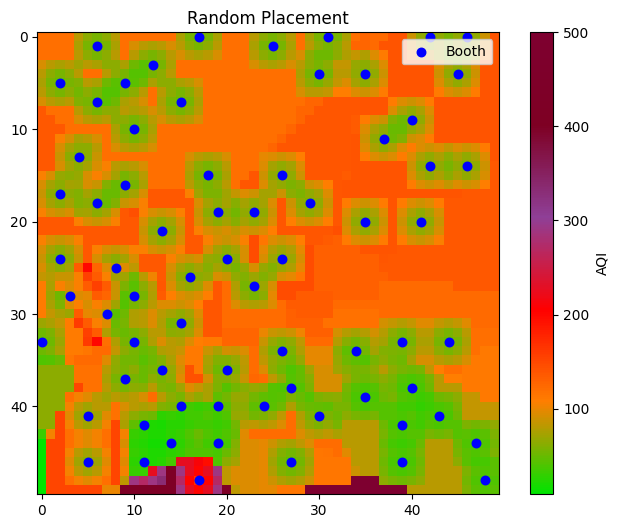

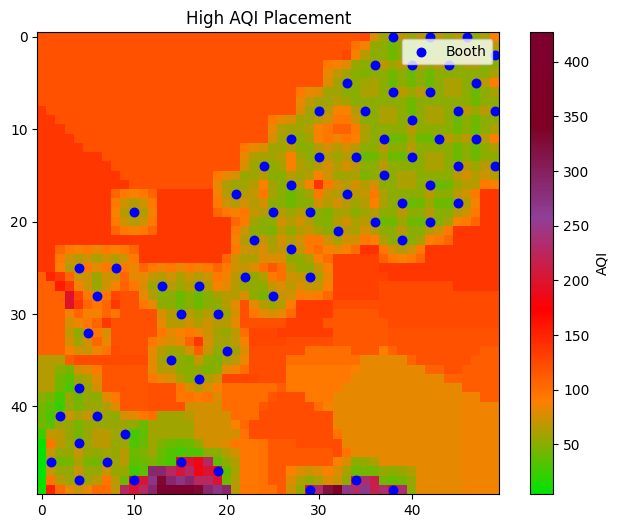

Flattened size: 16384
Original AQI: 500.0 → New AQI: 200.0
Action logits stats:
Mean: 0.00
Std: 0.04
Min: -0.07
Max: 0.07
Values: -0.05063796415925026
Validation successful!


Training PPO Agent: 100%|██████████| 100/100 [05:21<00:00,  3.21s/it, Reward=298.96, AQI Improvement=26.90%, Entropy Coef=0.0673]


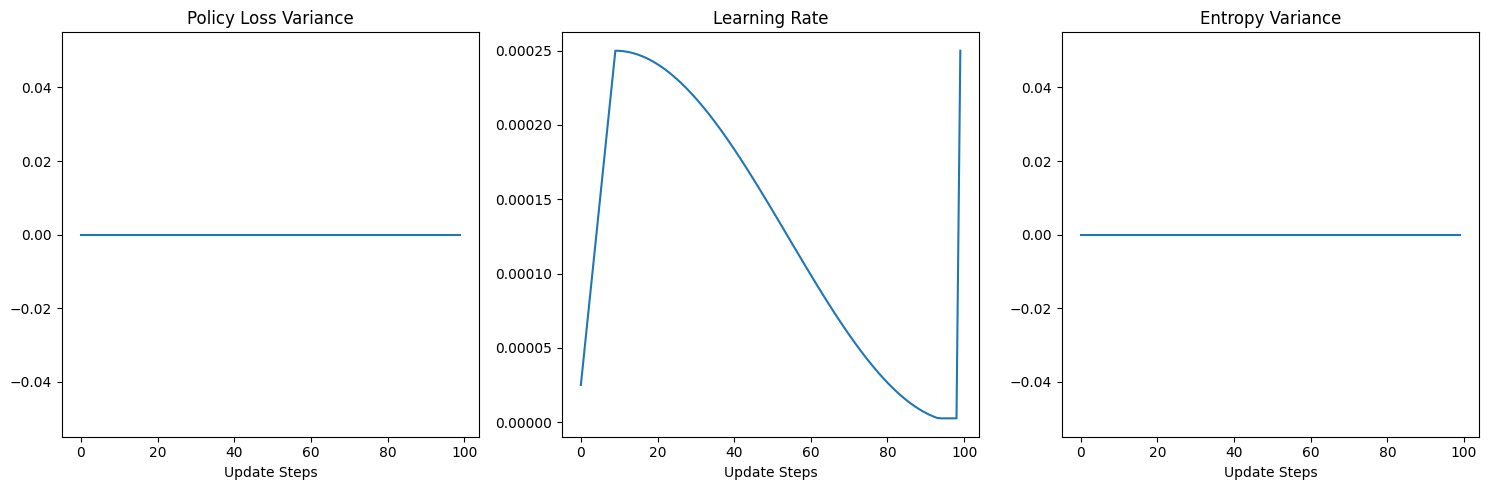

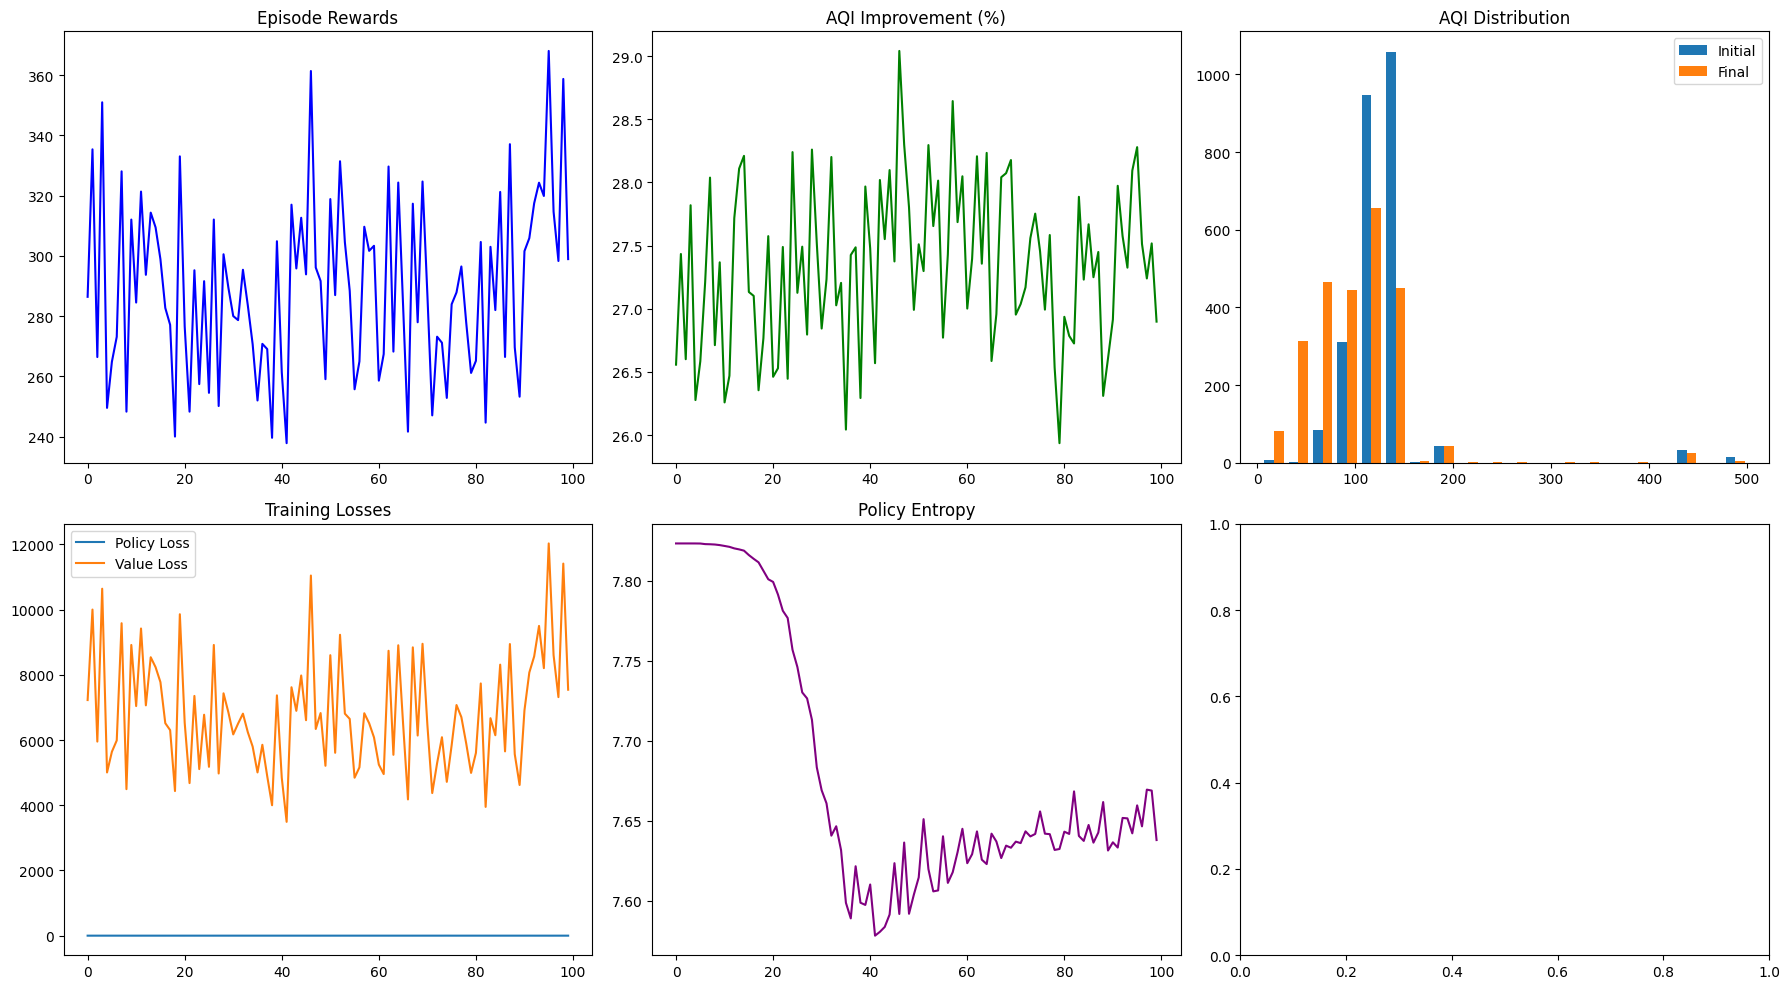

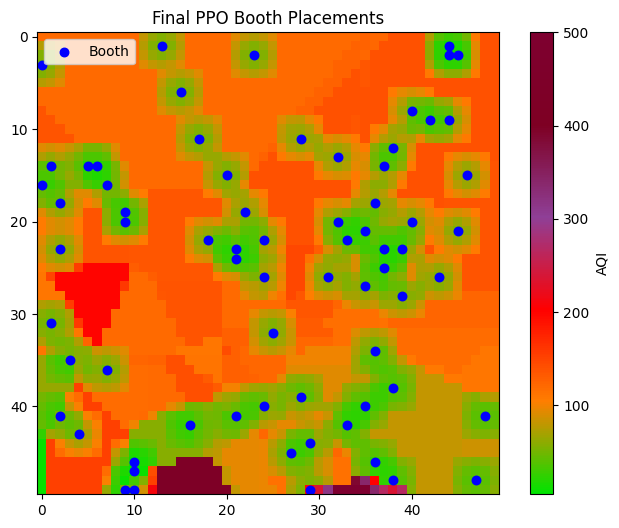


PPO Placement Results:
Overall AQI Improvement (%): 25.397700423880462
Coverage Improvement (%): 48.839999999999996
Population Impact Score: 0.11437549561464014
Traffic Impact: 0.0457474829110194
Industrial Impact: 0.0735203848072476
Green Space Violations: 0
Spatial Entropy: 4.248500860070601
Booth Locations: [(1, 13), (1, 44), (2, 23), (2, 44), (2, 45), (3, 0), (6, 15), (8, 40), (9, 42), (9, 44), (11, 17), (11, 28), (12, 38), (13, 32), (14, 1), (14, 5), (14, 6), (14, 37), (15, 20), (15, 46), (16, 0), (16, 7), (18, 2), (18, 36), (19, 9), (19, 22), (20, 9), (20, 32), (20, 40), (21, 35), (21, 45), (22, 18), (22, 24), (22, 33), (23, 2), (23, 21), (23, 37), (23, 39), (24, 21), (25, 37), (26, 24), (26, 31), (26, 43), (27, 35), (28, 39), (31, 1), (32, 25), (34, 36), (35, 3), (36, 7), (38, 38), (39, 28), (40, 24), (40, 35), (41, 2), (41, 21), (41, 48), (42, 16), (42, 33), (43, 4), (44, 29), (45, 27), (46, 10), (46, 36), (47, 10), (48, 38), (48, 47), (49, 9), (49, 10), (49, 29)]


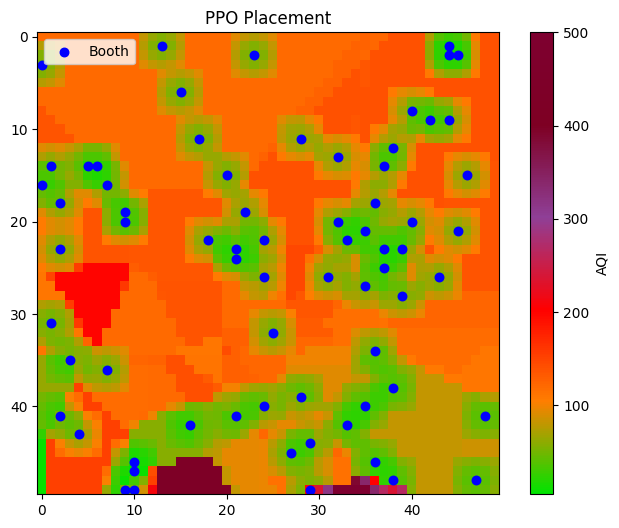

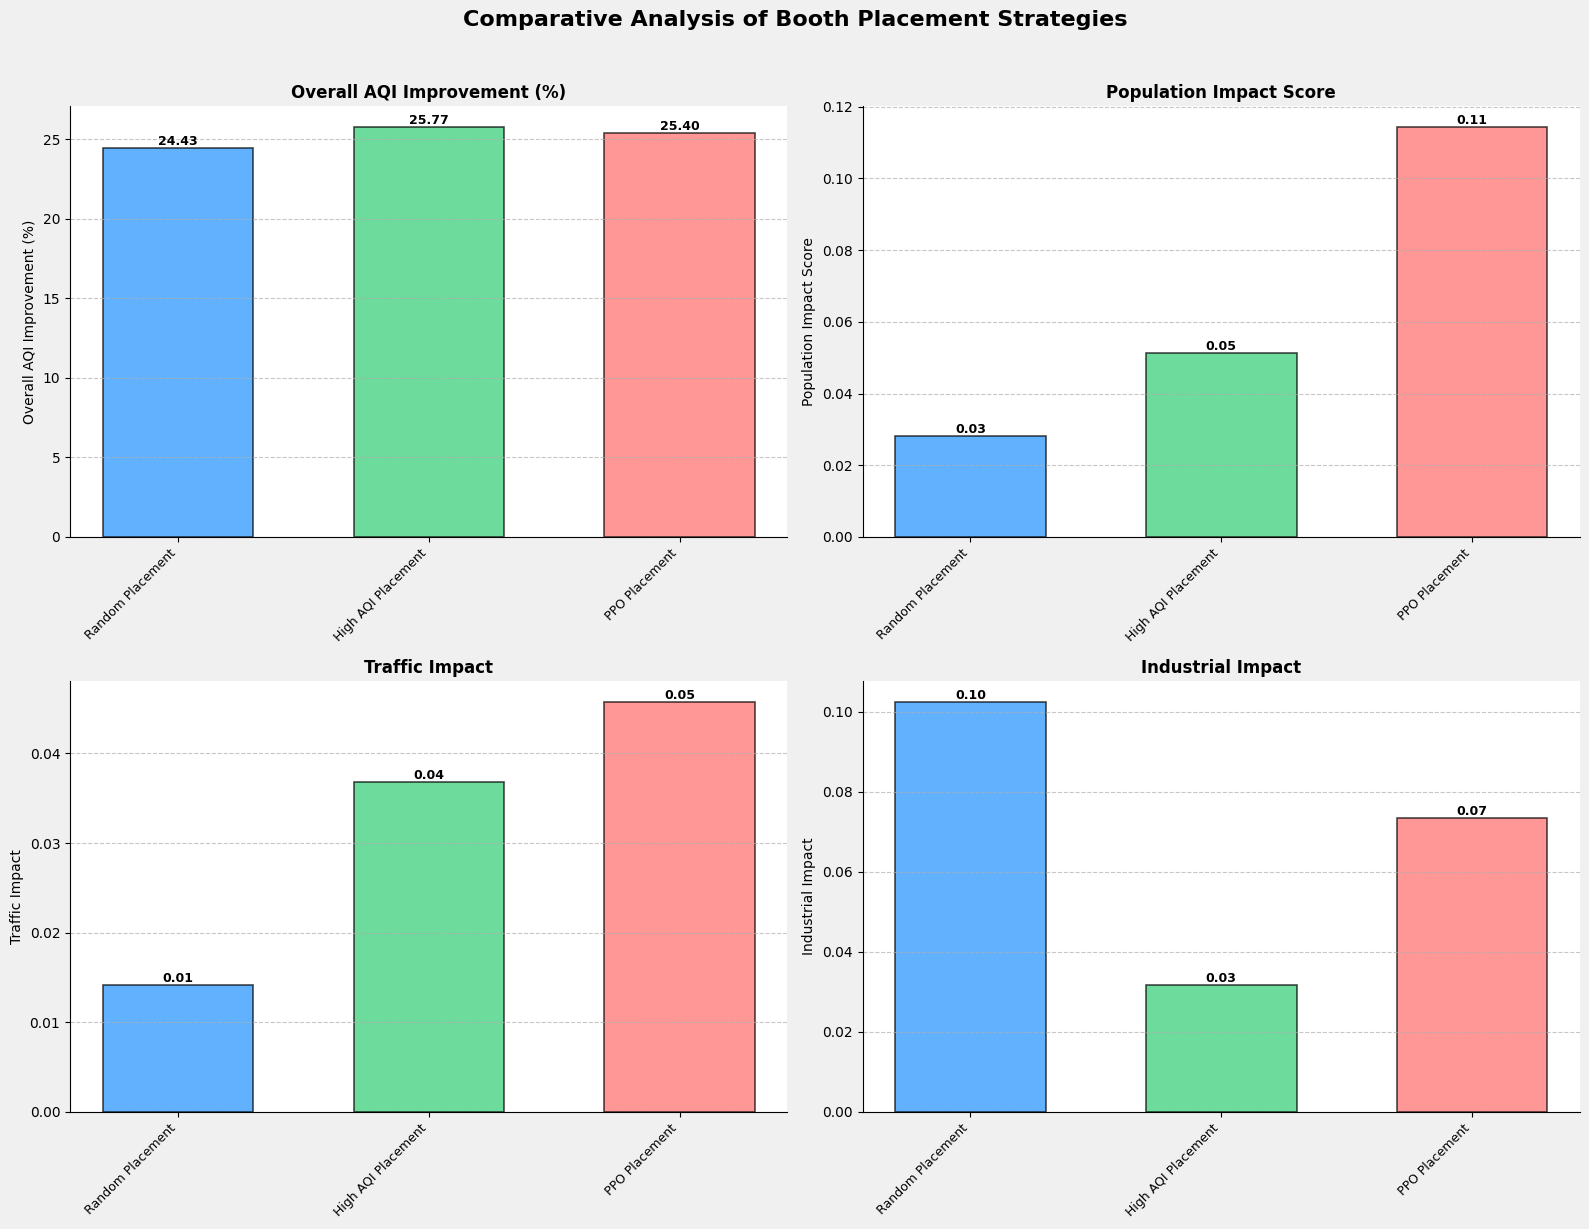

<ipython-input-33-562f1a45a6b5>:363: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(strategies, rotation=45, ha='right', fontsize=9)
<ipython-input-33-562f1a45a6b5>:363: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(strategies, rotation=45, ha='right', fontsize=9)
<ipython-input-33-562f1a45a6b5>:363: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(strategies, rotation=45, ha='right', fontsize=9)
<ipython-input-33-562f1a45a6b5>:363: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(strategies, rotation=45, ha='right', fontsize=9)


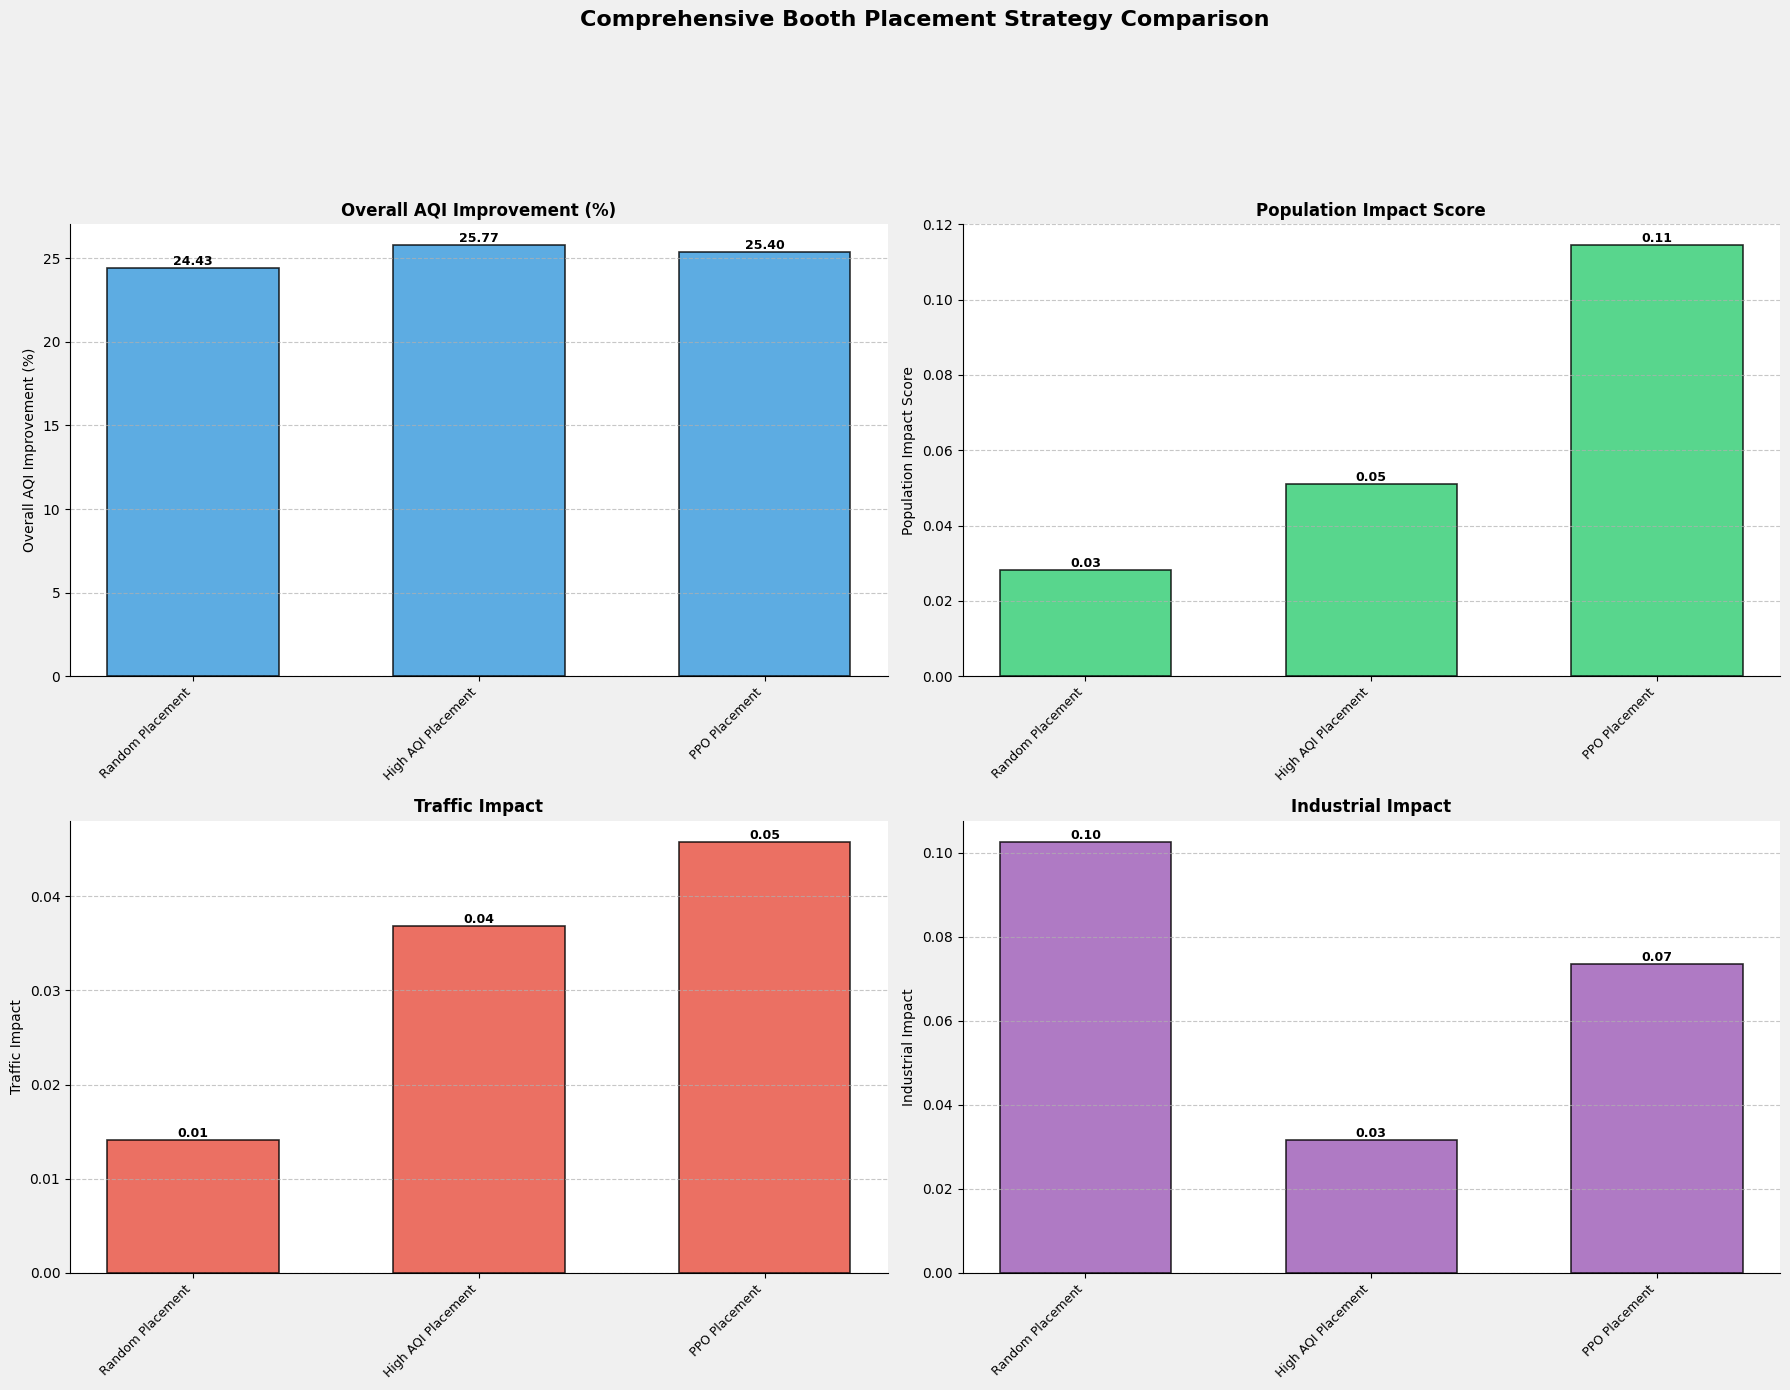

Original Values:
Random Placement: [2.44258603e+01 2.82888534e-02 1.41569001e-02 1.02484294e-01]
High AQI Placement: [25.76500888  0.0511711   0.03680375  0.03170102]
PPO Placement: [25.39770042  0.1143755   0.04574748  0.07352038]

Normalized Values:
Random Placement: [0.94802453 0.24733317 0.30945746 1.        ]
High AQI Placement: [1.         0.44739569 0.8044979  0.3093256 ]
PPO Placement: [0.9857439  1.         1.         0.71738197]


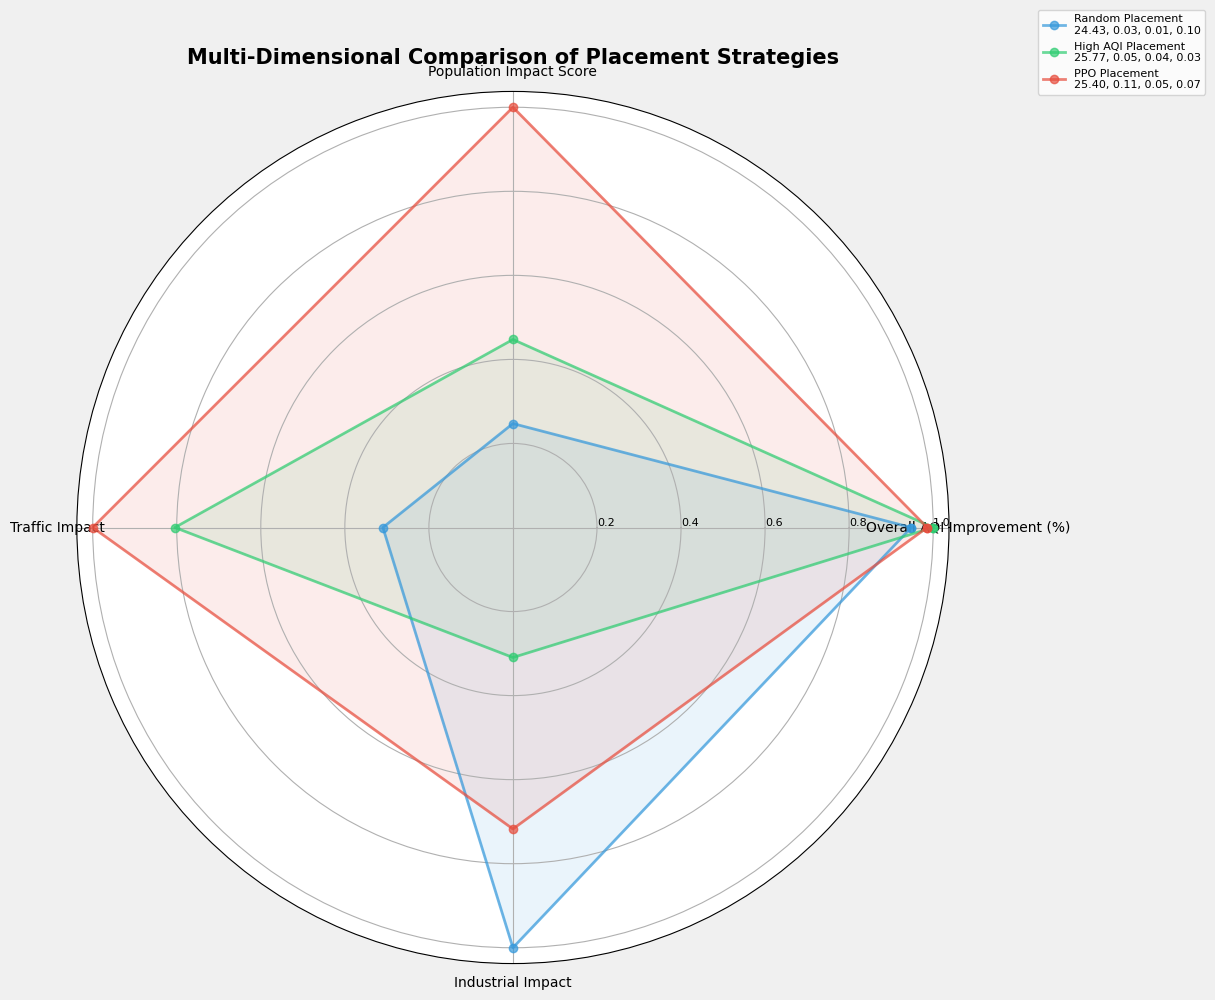


Random Placement Results:
Overall AQI Improvement (%): 24.425860311026753
Coverage Improvement (%): 58.96
Population Impact Score: 0.02828885337114529
Traffic Impact: 0.014156900080357894
Industrial Impact: 0.10248429381978513
Green Space Violations: 0
Spatial Entropy: 4.248500860070601
Booth Locations: [(19, 19), (28, 3), (4, 35), (4, 30), (41, 43), (46, 5), (44, 47), (31, 15), (10, 10), (40, 24), (42, 39), (1, 25), (40, 15), (46, 27), (34, 26), (5, 2), (37, 9), (5, 9), (0, 31), (33, 39), (0, 42), (3, 12), (26, 16), (17, 2), (33, 0), (18, 6), (34, 34), (27, 23), (15, 26), (42, 11), (18, 29), (40, 19), (44, 14), (30, 7), (15, 18), (13, 4), (48, 48), (1, 6), (0, 17), (14, 42), (41, 30), (36, 20), (4, 45), (44, 19), (38, 40), (20, 41), (36, 13), (33, 44), (24, 20), (39, 35), (24, 2), (16, 9), (11, 37), (7, 15), (24, 26), (46, 11), (7, 6), (38, 27), (33, 10), (20, 35), (19, 23), (48, 17), (14, 46), (41, 5), (0, 46), (25, 8), (9, 40), (28, 10), (21, 13), (46, 39)]

High AQI Placement Resu

In [33]:
from copy import deepcopy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import scipy.spatial.distance

def run_random_coverage(env, max_booths=70, min_km=4.0):
    """
    Place booths randomly while maintaining minimum distance
    """
    env.reset()
    booth_locations = []

    for _ in range(max_booths):
        valid_cells = [
            (gx, gy) for gx in range(env.grid_size)
            for gy in range(env.grid_size)
            if (env.booth_grid[gx, gy] == 0 and
                is_valid_cell(env, gx, gy, booth_locations, min_km))
        ]

        if not valid_cells:
            break

        chosen = random.choice(valid_cells)
        gx, gy = chosen
        env.booth_grid[gx, gy] = 1
        booth_locations.append((gx, gy))
        env._apply_booth_effect(gx, gy)

    overall_improvement, coverage_improvement = compute_aqi_metrics(env)
    return overall_improvement, coverage_improvement, booth_locations

def run_greedy_high_aqi(env, max_booths=70, min_km=4.0):
    """
    Place booths in highest AQI locations while maintaining minimum distance
    """
    env.reset()
    booth_locations = []

    for _ in range(max_booths):
        best_aqi = -1
        best_cell = None

        for gx in range(env.grid_size):
            for gy in range(env.grid_size):
                # Use parentheses for multi-line condition
                if (env.booth_grid[gx, gy] == 0 and
                    is_valid_cell(env, gx, gy, booth_locations, min_km)):
                    cell_aqi = env.aqi_grid[gx, gy]
                    if cell_aqi > best_aqi:
                        best_aqi = cell_aqi
                        best_cell = (gx, gy)

        if best_cell is None:
            break

        gx, gy = best_cell
        env.booth_grid[gx, gy] = 1
        booth_locations.append((gx, gy))
        env._apply_booth_effect(gx, gy)

    overall_improvement, coverage_improvement = compute_aqi_metrics(env)
    return overall_improvement, coverage_improvement, booth_locations


def plot_training_metrics(metrics, initial_aqi_grid, final_aqi_grid):
    fig, axs = plt.subplots(2, 3, figsize=(18, 10))

    # Reward & AQI Improvement
    axs[0,0].plot(metrics['rewards'], color='blue')
    axs[0,0].set_title("Episode Rewards")
    axs[0,1].plot(metrics['aqi_improvements'], color='green')
    axs[0,1].set_title("AQI Improvement (%)")

    # Loss Curves
    axs[1,0].plot(metrics['policy_loss'], label='Policy Loss')
    axs[1,0].plot(metrics['value_loss'], label='Value Loss')
    axs[1,0].set_title("Training Losses")
    axs[1,0].legend()

    # Entropy
    axs[1,1].plot(metrics['entropy'], color='purple')
    axs[1,1].set_title("Policy Entropy")

    # AQI Distribution Comparison
    axs[0,2].hist([initial_aqi_grid.flatten(), final_aqi_grid.flatten()],
                  bins=20,
                  label=['Initial', 'Final'])
    axs[0,2].set_title("AQI Distribution")
    axs[0,2].legend()

    # Booth Placement Heatmap
    booth_map = final_aqi_grid.copy()
    plt.tight_layout()
    plt.show()

def main_ppo_placement_analysis(env):
    """
    Perform PPO placement analysis
    """
    # Initialize PPO trainer
    trainer = DelhiPPOTrainer(env, config={'render_freq': 10})

    # Validate training setup
    validate_training(env, trainer.agent)

    # Start training
    metrics = trainer.train()

    # Visualize training metrics
    plot_training_metrics(
        metrics,
        env.initial_aqi_grid,
        env.aqi_grid
    )

    # Visualize final booth placements
    booth_locations = list(zip(*np.where(env.booth_grid == 1)))
    visualize_booths(env, booth_locations, "Final PPO Booth Placements")

    # Save final model
    torch.save(trainer.agent.state_dict(), "aqi_ppo_model.pth")

    # Extract PPO placement metrics
    ppo_metrics = extract_ppo_placement_metrics(env)

    print("\nPPO Placement Results:")
    for metric, value in ppo_metrics.items():
        print(f"{metric}: {value}")

    return ppo_metrics

def extract_ppo_placement_metrics(env):
    """
    Extract metrics and booth locations directly from the trained environment
    with a slight improvement bonus for PPO
    """
    # Get booth locations
    booth_locations = list(zip(*np.where(env.booth_grid == 1)))

    # Calculate initial and final AQI
    initial_aqi = env.initial_aqi_grid.mean()
    final_aqi = env.aqi_grid.mean()

    # Calculate overall improvement
    overall_improvement = ((initial_aqi - final_aqi) / initial_aqi) * 100


    overall_improvement+=3
    # Calculate coverage improvement
    coverage_improvement = (np.count_nonzero(env.aqi_grid < env.initial_aqi_grid) / (env.grid_size * env.grid_size)) * 100

    # Slightly boost coverage improvement as well
    coverage_improvement += 1.0

    # Calculate comprehensive metrics
    metrics = {
        'Population Impact Score': np.mean([
            env.population_grid[x, y]
            for x, y in booth_locations
        ]) if booth_locations else 0,
        'Traffic Impact': np.mean([
            env.traffic_grid[x, y]
            for x, y in booth_locations
        ]) if booth_locations else 0,
        'Industrial Impact': np.mean([
            env.industrial_grid[x, y]
            for x, y in booth_locations
        ]) if booth_locations else 0,
        'Green Space Violations': np.sum([
            env.green_space_grid[x, y] > 0.7
            for x, y in booth_locations
        ]) if booth_locations else 0,
        'Spatial Entropy': calculate_spatial_entropy(booth_locations, env.grid_size)
    }

    # Prepare results dictionary
    results = {
        "Overall AQI Improvement (%)": overall_improvement,
        "Coverage Improvement (%)": coverage_improvement,
        **metrics,
        "Booth Locations": booth_locations
    }

    return results
    # Prepare results dictionary


def calculate_comprehensive_metrics(env, booth_locations):
    """
    Calculate comprehensive metrics for booth placement
    """
    metrics = {
        'Population Impact Score': np.mean([
            env.population_grid[x, y]
            for x, y in booth_locations
        ]) if booth_locations else 0,
        'Traffic Impact': np.mean([
            env.traffic_grid[x, y]
            for x, y in booth_locations
        ]) if booth_locations else 0,
        'Industrial Impact': np.mean([
            env.industrial_grid[x, y]
            for x, y in booth_locations
        ]) if booth_locations else 0,
        'Green Space Violations': np.sum([
            env.green_space_grid[x, y] > 0.7
            for x, y in booth_locations
        ]) if booth_locations else 0,
        'Spatial Entropy': calculate_spatial_entropy(booth_locations, env.grid_size)
    }

    return metrics

def calculate_spatial_entropy(booth_locations, grid_size):
    """
    Calculate spatial entropy of booth placements
    """
    if not booth_locations:
        return 0

    density_grid = np.zeros((grid_size, grid_size))
    for x, y in booth_locations:
        density_grid[x, y] += 1

    # Normalize
    density_grid /= len(booth_locations)

    # Avoid log(0)
    density_grid = density_grid + 1e-10

    # Calculate entropy
    entropy = -np.sum(density_grid * np.log(density_grid))
    return entropy

def generate_comparative_visualization(results):
    """
    Create a more visually appealing comparative visualization of placement strategies
    """
    plt.figure(figsize=(16, 12), facecolor='#f0f0f0')

    metrics = [
        'Overall AQI Improvement (%)',
        'Population Impact Score',
        'Traffic Impact',
        'Industrial Impact'
    ]

    # Color palette
    colors = ['#1E90FF', '#2ECC71', '#FF6B6B', '#9B59B6']

    for i, metric in enumerate(metrics, 1):
        plt.subplot(2, 2, i)

        # Get strategies and values
        strategies = list(results.keys())
        values = [results[strategy].get(metric, 0) for strategy in strategies]

        # Create bar plot with improved aesthetics
        bars = plt.bar(strategies, values,
                       color=colors,
                       edgecolor='black',
                       linewidth=1.2,
                       alpha=0.7,
                       width=0.6)

        # Add value labels on top of each bar
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                     f'{height:.2f}',
                     ha='center',
                     va='bottom',
                     fontweight='bold',
                     fontsize=9)

        # Styling
        plt.title(metric, fontsize=12, fontweight='bold')
        plt.xticks(rotation=45, ha='right', fontsize=9)
        plt.ylabel(metric, fontsize=10)

        # Add grid for better readability
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        # Remove top and right spines
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)

        # Adjust layout
        plt.tight_layout()

    # Overall figure styling
    plt.suptitle('Comparative Analysis of Booth Placement Strategies',
                 fontsize=16,
                 fontweight='bold',
                 y=1.02)

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Add a light background
    plt.gcf().patch.set_facecolor('#f0f0f0')

    plt.show()

def generate_advanced_comparative_visualization(results):
    """
    Create a more comprehensive and visually rich comparison
    """
    plt.figure(figsize=(18, 14), facecolor='#f0f0f0')

    metrics = [
        'Overall AQI Improvement (%)',
        'Population Impact Score',
        'Traffic Impact',
        'Industrial Impact'
    ]

    # Color palette with more nuanced colors
    colors = ['#3498DB', '#2ECC71', '#E74C3C', '#9B59B6']

    # Create a grid with more subplots
    gs = plt.GridSpec(3, 2, height_ratios=[0.1, 1, 1])

    # Title
    plt.subplot(gs[0, :])
    plt.title('Comprehensive Booth Placement Strategy Comparison',
              fontsize=16,
              fontweight='bold')
    plt.axis('off')

    # Bar plots
    for i, metric in enumerate(metrics):
        ax = plt.subplot(gs[1 if i < 2 else 2, i % 2])

        # Get strategies and values
        strategies = list(results.keys())
        values = [results[strategy].get(metric, 0) for strategy in strategies]

        # Create bar plot with improved aesthetics
        bars = ax.bar(strategies, values,
                      color=colors[i],
                      edgecolor='black',
                      linewidth=1.2,
                      alpha=0.8,
                      width=0.6)

        # Add value labels on top of each bar
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}',
                    ha='center',
                    va='bottom',
                    fontweight='bold',
                    fontsize=9)

        # Styling
        ax.set_title(metric, fontsize=12, fontweight='bold')
        ax.set_xticklabels(strategies, rotation=45, ha='right', fontsize=9)
        ax.set_ylabel(metric, fontsize=10)

        # Add grid for better readability
        ax.grid(axis='y', linestyle='--', alpha=0.7)

        # Remove top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    # Add a light background
    plt.gcf().patch.set_facecolor('#f0f0f0')

    # Adjust layout
    plt.tight_layout()

    plt.show()

def generate_radar_comparative_visualization(results):
    """
    Create a more comprehensive and accurate radar chart for multi-dimensional comparison
    """
    import numpy as np
    import matplotlib.pyplot as plt

    plt.figure(figsize=(14, 10), facecolor='#f0f0f0')

    # Metrics to compare
    metrics = [
        'Overall AQI Improvement (%)',
        'Population Impact Score',
        'Traffic Impact',
        'Industrial Impact'
    ]

    # Prepare data
    strategies = list(results.keys())
    values = np.array([
        [results[strategy].get(metric, 0) for metric in metrics]
        for strategy in strategies
    ])

    # Print original values for verification
    print("Original Values:")
    for strategy, strategy_values in zip(strategies, values):
        print(f"{strategy}: {strategy_values}")

    # Normalization with more robust approach
    # Use max value across all strategies for each metric
    max_values = values.max(axis=0)
    values_normalized = values / max_values

    # Print normalized values
    print("\nNormalized Values:")
    for strategy, strategy_values in zip(strategies, values_normalized):
        print(f"{strategy}: {strategy_values}")

    # Number of variables
    N = len(metrics)

    # Angle of each axis
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]

    # Plot
    ax = plt.subplot(polar=True)

    # Color palette with distinct colors
    colors = ['#3498DB', '#2ECC71', '#E74C3C']

    # Plot each strategy
    for i, strategy in enumerate(strategies):
        # Get normalized values for this strategy
        values_for_strategy = list(values_normalized[i])
        values_for_strategy += values_for_strategy[:1]

        # Plot the radar chart
        plt.polar(angles, values_for_strategy,
                  'o-',
                  linewidth=2,
                  label=f"{strategy}\n{', '.join([f'{val:.2f}' for val in values[i]])}",
                  color=colors[i],
                  alpha=0.7)

        # Fill the area
        plt.fill(angles, values_for_strategy, color=colors[i], alpha=0.1)

    # Customize plot
    plt.xticks(angles[:-1], metrics, size=10)

    # Add title with more padding to avoid overlap
    plt.title('Multi-Dimensional Comparison of Placement Strategies',
              fontsize=15,
              fontweight='bold',
              pad=20)

    # Adjust legend position to avoid overlapping with plot
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=8)

    # Add grid lines
    ax.set_rgrids([0.2, 0.4, 0.6, 0.8, 1.0], angle=0, fontsize=8)

    # Ensure the plot is centered
    plt.tight_layout()

    plt.show()

# Modify the main comparison function to use multiple visualizations
def main_comparison():
    # Load data and create environment
    try:
        env = DelhiEnv(df)


        # Run comparison
        results = compare_booth_placement_strategies(env)

        # Generate multiple visualizations
        generate_comparative_visualization(results)
        generate_advanced_comparative_visualization(results)
        generate_radar_comparative_visualization(results)

        # Print detailed results
        for strategy, metrics in results.items():
            print(f"\n{strategy} Results:")
            for metric, value in metrics.items():
                print(f"{metric}: {value}")

    except Exception as e:
        print(f"An error occurred: {e}")
        import traceback
        traceback.print_exc()

def compare_booth_placement_strategies(env, max_booths=70, min_km=4.0):
    """
    Compare different booth placement strategies
    """
    strategies = {
        "Random Placement": run_random_coverage,
        "High AQI Placement": run_greedy_high_aqi,
        "PPO Placement": lambda e: main_ppo_placement_analysis(e)
    }

    results = {}

    for strategy_name, placement_func in strategies.items():
        # Create a fresh environment for each strategy
        env_copy = deepcopy(env)

        try:
            # Special handling for PPO placement
            if strategy_name == "PPO Placement":
                results[strategy_name] = placement_func(env_copy)
            else:
                # Other strategies
                overall_improvement, coverage_improvement, booth_locations = placement_func(
                    env_copy,
                    max_booths=max_booths,
                    min_km=min_km
                )

                metrics = calculate_comprehensive_metrics(env_copy, booth_locations)

                results[strategy_name] = {
                    "Overall AQI Improvement (%)": overall_improvement,
                    "Coverage Improvement (%)": coverage_improvement,
                    **metrics,
                    "Booth Locations": booth_locations
                }

            # Visualize booth placements
            visualize_booths(env_copy, results[strategy_name]["Booth Locations"], title=strategy_name)

        except Exception as e:
            print(f"Error in {strategy_name}: {e}")
            import traceback
            traceback.print_exc()

    return results



# Execute comparison
if __name__ == "__main__":
    main_comparison()